In [1]:
import numpy as np
import pandas as pd
import zipfile as zp
from pathlib import Path
from gensim.utils import check_output
from sklearn.preprocessing import normalize
from scipy.special import softmax
import shutil
from subprocess import check_output
import torch
from tqdm import tqdm
import colored
import itertools
import matplotlib.pyplot as plt

In [2]:
def printgr(text):
    print(colored.stylize(text, colored.fg('green')))

In [3]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

In [4]:
cd /export/usuarios_ml4ds/lbartolome/topicmodeler

/export/usuarios_ml4ds/lbartolome/topicmodeler


In [5]:
from src.topicmodeling.neural_models.pytorchavitm.datasets.bow_dataset import BOWDataset
from src.topicmodeling.neural_models.pytorchavitm.avitm_network.avitm import AVITM
from src.topicmodeling.neural_models.pytorchavitm.utils.data_preparation import prepare_dataset

In [6]:
modelsdir = Path("/export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test")

## **1. Creation of synthetic corpus functions**


---

In [7]:
def rotateArray(arr, n, d):
    temp = []
    i = 0
    while (i < d):
        temp.append(arr[i])
        i = i + 1
    i = 0
    while (d < n):
        arr[i] = arr[d]
        i = i + 1
        d = d + 1
    arr[:] = arr[: i] + temp
    return arr

In [8]:
def generateSynthetic(just_inf, gen_docs, vocab_size, n_topics, beta, alpha, n_docs,
                      n_docs_inf, n_docs_global_inf, nwords, alg, n_nodes,
                      frozen_topics, prior_frozen, own_topics, prior_nofrozen):
    
    if just_inf:
        n_total_docs = n_docs_global_inf
    else:
        n_total_docs = n_docs + n_docs_inf

    # Step 1 - generation of topics
    topic_vectors = np.random.dirichlet(vocab_size*[beta], n_topics)
    
    # Step 2 - generation of document topic proportions
    doc_topics_all = []
    for i in np.arange(n_nodes):
        doc_topics = np.random.dirichlet(prior_frozen + prior_nofrozen, n_total_docs)
        prior_nofrozen = rotateArray(prior_nofrozen, len(prior_nofrozen), own_topics)
        doc_topics_all.append(doc_topics)
        
    # Step 3 - Document generation
    documents_all = []
    # z_all = []
    
    if gen_docs:
        for i in np.arange(n_nodes):
            print("Generating document words for node ", str(i))
            documents = [] # Document words
            #z = [] # Assignments
            for docid in tqdm(np.arange(n_total_docs)):
                doc_len = np.random.randint(low=nwords[0], high=nwords[1])
                this_doc_words = []
                #this_doc_assigns = []
                for wd_idx in np.arange(doc_len):

                    tpc = np.nonzero(np.random.multinomial(1, doc_topics_all[i][docid]))[0][0]
                    #this_doc_assigns.append(tpc)
                    if alg == "lda":
                        word = np.nonzero(np.random.multinomial(1, topic_vectors[tpc]))[0][0]
                    else: #prodlda
                        pval = np.power(topic_vectors[tpc], doc_topics_all[i][docid][tpc])
                        weights = torch.tensor(pval, dtype=torch.float) # create a tensor of weights
                        word = torch.multinomial(weights, 1).numpy()[0]
                        #pval = normalize(pval[:,np.newaxis], norm='l1', axis=0).ravel()
                        #word = np.nonzero(np.random.multinomial(1, b))[0][0]
                    this_doc_words.append('wd'+str(word))
                #z.append(this_doc_assigns)
                documents.append(this_doc_words)
            documents_all.append(documents)
            #z_all.append(z)
    
    return topic_vectors, doc_topics_all, documents_all

## **2. Training and evaluation functions**

---

In [9]:
def create_model_folder(modelname, modelsdir):
    
    # Create model folder and save model training configuration
    modeldir = modelsdir.joinpath(modelname)
    
    if modeldir.exists():

        # Remove current backup folder, if it exists
        old_model_dir = Path(str(modeldir) + '_old/')
        if old_model_dir.exists():
            shutil.rmtree(old_model_dir)

        # Copy current model folder to the backup folder.
        shutil.move(modeldir, old_model_dir)
        print(f'-- -- Creating backup of existing model in {old_model_dir}')

    modeldir.mkdir()
    configFile = modeldir.joinpath('trainconfig.json')
    
    return modeldir, configFile

In [10]:
def convert_topic_word_to_init_size(vocab_size, model, model_type,
                                    ntopics, id2token, all_words):
    """It converts the topic-word distribution matrix obtained from the training of a model into a matrix with the dimensions of the original topic-word distribution, assigning zeros to those words that are not present in the corpus. 
    It is only of use in case we are training a model over a synthetic dataset, so as to later compare the performance of the attained model in what regards to the similarity between the original and the trained model.

    Args:
        * vocab_size (int):       Size of the synethic'data vocabulary.
        * model (AVITM/CTM):      Model whose topic-word matrix is being transformed.
        * model_type (str):       Type of the trained model (e.g. AVITM)
        * ntopics (int):          Number of topics of the trained model.
        * id2token (List[tuple]): Mappings with the content of the document-term matrix.
        * all_words (List[str]):  List of all the words of the vocabulary of size vocab_size.

    Returns:
        * ndarray: Normalized transormed topic-word distribution.
    """
    if model_type == "avitm":
        w_t_distrib = np.zeros((ntopics, vocab_size), dtype=np.float64)
        wd = model.get_topic_word_distribution()
        for i in np.arange(ntopics):
            for idx, word in id2token.items():
                for j in np.arange(len(all_words)):
                    if all_words[j] == word:
                        w_t_distrib[i, j] = wd[i][idx]
                        break
        normalized_array = normalize(w_t_distrib,axis=1,norm='l1')
        return normalized_array
    else:
        print("Method not impleemnted for the selected model type")
        return None

In [11]:
def train_avitm(modelname, modelsdir, corpus):
    
    # Create model folder
    modeldir, configFile = create_model_folder(modelname, modelsdir)
    
    # Create corpus in ProdLDA format (BoWDataset)
    train_data, val_data, input_size, id2token, docs_train, cv = prepare_dataset(corpus)
    idx2token = train_data.idx2token
    
    #cv = CountVectorizer(input='content', lowercase=True, stop_words='english', binary=False)
    #docs = [" ".join(corpus[i]) for i in np.arange(len(corpus))]
    #train_bow = cv.fit_transform(docs).toarray()
    #idx2token = cv.get_feature_names_out()
    #train_dataset = BOWDataset(train_bow, idx2token)
    #input_size = len(idx2token)
    #id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}
    
    avitm = AVITM(logger=None,
              input_size=input_size,
              n_components=n_topics,
              model_type="prodLDA",
              hidden_sizes=(100, 100),
              activation='softplus',
              dropout=0.2,
              learn_priors=True,
              batch_size=64,
              lr=2e-3,
              momentum=0.99,
              solver='adam',
              num_epochs=100,
              reduce_on_plateau=False,
              topic_prior_mean=0.0,
              topic_prior_variance=None,
              num_samples=20,
              num_data_loader_workers=0,
              verbose=True)
    avitm.fit(train_data,val_data)
    
    return modeldir, avitm, cv, id2token, idx2token

In [12]:
def eval_betas(beta, topic_vectors):
    print('Tópicos (equivalentes) evaluados correctamente:')
    score = np.sum(np.max(np.sqrt(beta).dot(np.sqrt(topic_vectors.T)), axis=0))
    printgr(score)
    return score

In [13]:
def eval_thetas(thetas_theoretical, thetas_actual, n_docs):
    sim_mat_theoretical = np.sqrt(thetas_theoretical).dot(np.sqrt(thetas_theoretical.T))
    sim_mat_actual = np.sqrt(thetas_actual).dot(np.sqrt(thetas_actual.T))
    print('Difference in evaluation of doc similarity:')
    score = np.sum(np.abs(sim_mat_theoretical - sim_mat_actual))/n_docs
    printgr(score)
    return score

## **3. Actual training and evaluation**

---

In [14]:
n_nodes = 5

In [15]:
1e-1

0.1

In [16]:
1e-2

0.01

In [17]:
# Topic modeling settings
vocab_size = 5000
n_topics = 50
beta = 0.05
alpha = 5/n_topics
n_docs = 1000
n_docs_inf = 1000
n_docs_global_inf = 1000#int(n_docs / n_nodes)
nwords = (150, 250) #Min and max lengths of the documents
alg = "lda" #"prod"

tm_settings = {
    "vocab_size": vocab_size,
    "n_topics": n_topics,
    "beta": beta,
    "alpha": alpha,
    "n_docs": n_docs,
    "n_docs_inf": n_docs_inf,
    "n_docs_global_inf": n_docs_global_inf,
    "nwords": nwords,
    "alg": alg
}

In [18]:
# Centralized settings

frozen_topics = 5
prior_frozen = frozen_topics * [alpha]
own_topics = int((n_topics-frozen_topics)/n_nodes)
prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

centralized_settings = {
    "n_nodes": n_nodes,
    "frozen_topics": frozen_topics,
    "prior_frozen": prior_frozen,
    "own_topics": own_topics,
    "prior_nofrozen": prior_nofrozen
}

In [19]:
frozen_topics_list = [5,10,15,40]

sim_betas_centralized = []
sim_thetas_centralized = []
sim_betas_non_colab = []
sim_thetas_non_colab = []
sim_thetas_baseline = []

for frozen_topics in frozen_topics_list:
    print("Executing for frozen topics ", str(frozen_topics))
    
    # Recalculate centralized settings
    prior_frozen = frozen_topics * [alpha]
    own_topics = int((n_topics-frozen_topics)/n_nodes)
    prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

    centralized_settings = {
        "n_nodes": n_nodes,
        "frozen_topics": frozen_topics,
        "prior_frozen": prior_frozen,
        "own_topics": own_topics,
        "prior_nofrozen": prior_nofrozen
    }
    
    # Baseline doc-topics generation
    topic_vectors, doc_topics_all, _ = generateSynthetic(True, False, **tm_settings, **centralized_settings)

    for i in range(len(doc_topics_all)):
        if i == 0:
            thetas_bas = doc_topics_all[i]
        else:
            thetas_bas = np.concatenate((thetas_bas,doc_topics_all[i]))
    print("Shape of thetas_bas", str(thetas_bas.shape))
    
    # Generate documents
    topic_vectors, doc_topics_all, documents_all = generateSynthetic(False, True, **tm_settings, **centralized_settings)
    
    # Generate inference corpus and its docs_topics
    inf = [doc for docs_node in documents_all for doc in docs_node[n_docs:(n_docs+n_docs_global_inf)]]
    print("Length of the inference corpus ", str(len(inf)))

    for i in range(len(doc_topics_all)):
        if i == 0:
            inf_doc_topics = doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)]
        else:
            inf_doc_topics = np.concatenate((inf_doc_topics,doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)])) 
    print("Shape of inf_doc_topics", str(inf_doc_topics.shape))
    
    ########################
    # Centralized training #
    ########################
    print("CENTRALIZED")
    # Define corpus
    corpus = [doc for docs_node in documents_all for doc in docs_node[0:n_docs]]
    print("Size of centralized corpus ", str(len(corpus)))

    # Train model 
    modelname = "prod_centralized"
    modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)
    
    # Get betas
    betas = avitm.get_topic_word_distribution()
    all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
    betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                            model=avitm,
                                            model_type="avitm",
                                            ntopics=n_topics,
                                            id2token=id2token,
                                            all_words=all_words)

    # Get thetas
    #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))[0:n_docs,:]
    #thetas_theoretical = doc_topics_all[0][0:n_docs]

    # Eval betas and thetas
    betas_31 = eval_betas(betas, topic_vectors)
    #thetas_31 = eval_thetas(thetas_theoretical, thetas, len(thetas))
    sim_betas_centralized.append(betas_31)
    
    # Inference
    # Get inferred thetas
    docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
    val_bow = cv.transform(docs_val_conv)
    val_bow = val_bow.toarray()
    val_data = BOWDataset(val_bow, idx2token)

    thetas_inf = np.asarray(avitm.get_doc_topic_distribution(val_data))
    thetas_theoretical = inf_doc_topics

    # Eval thetas
    thetas_312 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
    sim_thetas_centralized.append(thetas_312)
    
    #############################
    # Non-colaborative training #
    #############################
    betas_nodes = []
    thetas_nodes = []
    for node in range(n_nodes):
        print("NON-COLLABORATIVE of node ", str(node))
        # Define corpus
        corpus = documents_all[node][0:n_docs]
        print("Size of non-collaborative corpus ", str(len(corpus)))

        # Train model 
        modelname = "prodlda_node"
        modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)

        # Get betas
        betas = avitm.get_topic_word_distribution()
        all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
        betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                                model=avitm,
                                                model_type="avitm",
                                                ntopics=n_topics,
                                                id2token=id2token,
                                                all_words=all_words)

        # Get thetas
        #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))
        #thetas_theoretical = doc_topics_all[0][0:n_docs]


        # Eval betas and thetas
        betas_32 = eval_betas(betas, topic_vectors)
        betas_nodes.append(betas_32)

        #thetas_32 = eval_thetas(thetas_theoretical, thetas, len(thetas))

        # Inference
        # Get inferred thetas
        docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
        val_bow = cv.transform(docs_val_conv)
        val_bow = val_bow.toarray()
        val_data = BOWDataset(val_bow, idx2token)

        thetas_inf = np.asarray(avitm.get_doc_topic_distribution(val_data))

        thetas_theoretical = inf_doc_topics

        # Eval thetas
        thetas_322 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
        thetas_nodes.append(thetas_322)
    
    avg1 = sum(betas_nodes)/n_nodes
    avg2 = sum(thetas_nodes)/n_nodes
    sim_betas_non_colab.append(avg1)
    print("Nodes averages betas and thetas inf: ", str(avg1), str(avg2))
    sim_thetas_non_colab.append(avg2)
    
    ########################
    #       Baseline       #
    ########################
    print("BASELINE")
    thetas_theoretical = thetas_inf
    thetas_baseline = eval_thetas(thetas_theoretical, thetas_bas, len(thetas_bas))
    sim_thetas_baseline.append(thetas_baseline)

Executing for frozen topics  5
Shape of thetas_bas (5000, 50)
Generating document words for node  0


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.49it/s]


Generating document words for node  1


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:00<00:00, 32.91it/s]


Generating document words for node  2


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.57it/s]


Generating document words for node  3


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.91it/s]


Generating document words for node  4


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.86it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.18s/it][2022-10-08 13:52:30,344] [avitm.py] [INFO] Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1729.25005	Time: 0:00:01.141446
Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1798.6850208333333	Time: 0:00:01.141446: : 1it [00:02,  1.18s/it]                       

Validation loss decreased (inf --> 1729.250050).  Saving model ...


Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1798.6850208333333	Time: 0:00:01.141446: : 2it [00:03,  1.87s/it][2022-10-08 13:52:32,363] [avitm.py] [INFO] Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1708.64694375	Time: 0:00:00.812455
Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1742.7253833333334	Time: 0:00:00.812455: : 2it [00:04,  1.87s/it]                          

Validation loss decreased (1729.250050 --> 1708.646944).  Saving model ...


Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1742.7253833333334	Time: 0:00:00.812455: : 3it [00:05,  1.96s/it][2022-10-08 13:52:34,523] [avitm.py] [INFO] Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1680.67046875	Time: 0:00:00.895012
Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1701.8913989583334	Time: 0:00:00.895012: : 3it [00:06,  1.96s/it]                          

Validation loss decreased (1708.646944 --> 1680.670469).  Saving model ...


Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1701.8913989583334	Time: 0:00:00.895012: : 4it [00:07,  2.03s/it][2022-10-08 13:52:36,606] [avitm.py] [INFO] Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1659.382509375	Time: 0:00:00.857314
Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1674.9572666666666	Time: 0:00:00.857314: : 4it [00:08,  2.03s/it]                           

Validation loss decreased (1680.670469 --> 1659.382509).  Saving model ...


Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1674.9572666666666	Time: 0:00:00.857314: : 5it [00:09,  2.05s/it][2022-10-08 13:52:38,762] [avitm.py] [INFO] Epoch: [5/100]	Samples: [1250/125000]	Validation Loss: 1642.94836875	Time: 0:00:00.908975
Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1655.7623625	Time: 0:00:00.908975: : 5it [00:10,  2.05s/it]                          

Validation loss decreased (1659.382509 --> 1642.948369).  Saving model ...


Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1655.7623625	Time: 0:00:00.908975: : 6it [00:12,  2.09s/it][2022-10-08 13:52:40,866] [avitm.py] [INFO] Epoch: [6/100]	Samples: [1250/125000]	Validation Loss: 1632.805675	Time: 0:00:00.839314
Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1640.8811479166666	Time: 0:00:00.839314: : 6it [00:12,  2.09s/it]                        

Validation loss decreased (1642.948369 --> 1632.805675).  Saving model ...


Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1640.8811479166666	Time: 0:00:00.839314: : 7it [00:14,  2.11s/it][2022-10-08 13:52:43,072] [avitm.py] [INFO] Epoch: [7/100]	Samples: [1250/125000]	Validation Loss: 1624.197675	Time: 0:00:00.892034
Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1631.249771875	Time: 0:00:00.892034: : 7it [00:15,  2.11s/it]                        

Validation loss decreased (1632.805675 --> 1624.197675).  Saving model ...


Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1631.249771875	Time: 0:00:00.892034: : 8it [00:16,  2.13s/it][2022-10-08 13:52:45,206] [avitm.py] [INFO] Epoch: [8/100]	Samples: [1250/125000]	Validation Loss: 1617.383946875	Time: 0:00:00.862100
Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1623.3969322916666	Time: 0:00:00.862100: : 8it [00:17,  2.13s/it]                           

Validation loss decreased (1624.197675 --> 1617.383947).  Saving model ...


Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1623.3969322916666	Time: 0:00:00.862100: : 9it [00:18,  2.14s/it][2022-10-08 13:52:47,376] [avitm.py] [INFO] Epoch: [9/100]	Samples: [1250/125000]	Validation Loss: 1613.573184375	Time: 0:00:00.865302
Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1616.008721875	Time: 0:00:00.865302: : 9it [00:19,  2.14s/it]                           

Validation loss decreased (1617.383947 --> 1613.573184).  Saving model ...


Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1616.008721875	Time: 0:00:00.865302: : 10it [00:20,  2.15s/it][2022-10-08 13:52:49,546] [avitm.py] [INFO] Epoch: [10/100]	Samples: [1250/125000]	Validation Loss: 1607.595646875	Time: 0:00:00.873911
Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1609.469590625	Time: 0:00:00.873911: : 10it [00:21,  2.15s/it]                           

Validation loss decreased (1613.573184 --> 1607.595647).  Saving model ...


Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1609.469590625	Time: 0:00:00.873911: : 11it [00:22,  2.16s/it][2022-10-08 13:52:51,803] [avitm.py] [INFO] Epoch: [11/100]	Samples: [1250/125000]	Validation Loss: 1602.03179375	Time: 0:00:00.947637
Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1606.822390625	Time: 0:00:00.947637: : 11it [00:23,  2.16s/it]                          

Validation loss decreased (1607.595647 --> 1602.031794).  Saving model ...


Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1606.822390625	Time: 0:00:00.947637: : 12it [00:25,  2.19s/it][2022-10-08 13:52:54,023] [avitm.py] [INFO] Epoch: [12/100]	Samples: [1250/125000]	Validation Loss: 1600.5274625	Time: 0:00:00.899439
Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1601.0502125	Time: 0:00:00.899439: : 12it [00:26,  2.19s/it]                         

Validation loss decreased (1602.031794 --> 1600.527462).  Saving model ...


Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1601.0502125	Time: 0:00:00.899439: : 13it [00:27,  2.21s/it][2022-10-08 13:52:56,291] [avitm.py] [INFO] Epoch: [13/100]	Samples: [1250/125000]	Validation Loss: 1595.4058625	Time: 0:00:00.904149
Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1598.3618395833332	Time: 0:00:00.904149: : 13it [00:28,  2.21s/it]                         

Validation loss decreased (1600.527462 --> 1595.405863).  Saving model ...


Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1598.3618395833332	Time: 0:00:00.904149: : 14it [00:29,  2.20s/it][2022-10-08 13:52:58,480] [avitm.py] [INFO] Epoch: [14/100]	Samples: [1250/125000]	Validation Loss: 1592.159153125	Time: 0:00:00.911692
Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1595.440603125	Time: 0:00:00.911692: : 14it [00:30,  2.20s/it]                           

Validation loss decreased (1595.405863 --> 1592.159153).  Saving model ...


Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1595.440603125	Time: 0:00:00.911692: : 15it [00:31,  2.21s/it][2022-10-08 13:53:00,696] [avitm.py] [INFO] Epoch: [15/100]	Samples: [1250/125000]	Validation Loss: 1589.792484375	Time: 0:00:00.903050
Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1592.6789927083332	Time: 0:00:00.903050: : 15it [00:32,  2.21s/it]                           

Validation loss decreased (1592.159153 --> 1589.792484).  Saving model ...


Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1592.6789927083332	Time: 0:00:00.903050: : 16it [00:33,  2.21s/it][2022-10-08 13:53:02,962] [avitm.py] [INFO] Epoch: [16/100]	Samples: [1250/125000]	Validation Loss: 1586.6079	Time: 0:00:00.943137
Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1589.2716458333334	Time: 0:00:00.943137: : 16it [00:34,  2.21s/it]                      

Validation loss decreased (1589.792484 --> 1586.607900).  Saving model ...


Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1589.2716458333334	Time: 0:00:00.943137: : 17it [00:36,  2.25s/it][2022-10-08 13:53:05,289] [avitm.py] [INFO] Epoch: [17/100]	Samples: [1250/125000]	Validation Loss: 1581.721271875	Time: 0:00:00.954301
Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1585.5926541666668	Time: 0:00:00.954301: : 17it [00:37,  2.25s/it]                           

Validation loss decreased (1586.607900 --> 1581.721272).  Saving model ...


Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1585.5926541666668	Time: 0:00:00.954301: : 18it [00:38,  2.26s/it][2022-10-08 13:53:07,552] [avitm.py] [INFO] Epoch: [18/100]	Samples: [1250/125000]	Validation Loss: 1579.473340625	Time: 0:00:00.928401
Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1585.6217989583333	Time: 0:00:00.928401: : 18it [00:39,  2.26s/it]                           

Validation loss decreased (1581.721272 --> 1579.473341).  Saving model ...


Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1585.6217989583333	Time: 0:00:00.928401: : 19it [00:40,  2.24s/it][2022-10-08 13:53:09,749] [avitm.py] [INFO] Epoch: [19/100]	Samples: [1250/125000]	Validation Loss: 1578.1374625	Time: 0:00:00.916236
Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1582.82258125	Time: 0:00:00.916236: : 19it [00:41,  2.24s/it]                         

Validation loss decreased (1579.473341 --> 1578.137463).  Saving model ...


Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1582.82258125	Time: 0:00:00.916236: : 20it [00:43,  2.24s/it][2022-10-08 13:53:12,016] [avitm.py] [INFO] Epoch: [20/100]	Samples: [1250/125000]	Validation Loss: 1577.3256125	Time: 0:00:00.957076
Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1581.8577208333334	Time: 0:00:00.957076: : 20it [00:43,  2.24s/it]                         

Validation loss decreased (1578.137463 --> 1577.325613).  Saving model ...


Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1581.8577208333334	Time: 0:00:00.957076: : 21it [00:45,  2.26s/it][2022-10-08 13:53:14,272] [avitm.py] [INFO] Epoch: [21/100]	Samples: [1250/125000]	Validation Loss: 1575.370803125	Time: 0:00:00.903655
Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1580.4129083333332	Time: 0:00:00.903655: : 21it [00:46,  2.26s/it]                           

Validation loss decreased (1577.325613 --> 1575.370803).  Saving model ...


Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1580.4129083333332	Time: 0:00:00.903655: : 22it [00:47,  2.26s/it][2022-10-08 13:53:16,535] [avitm.py] [INFO] Epoch: [22/100]	Samples: [1250/125000]	Validation Loss: 1573.184640625	Time: 0:00:00.920327
Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1578.2715864583333	Time: 0:00:00.920327: : 22it [00:48,  2.26s/it]                           

Validation loss decreased (1575.370803 --> 1573.184641).  Saving model ...


Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1578.2715864583333	Time: 0:00:00.920327: : 23it [00:49,  2.24s/it][2022-10-08 13:53:18,760] [avitm.py] [INFO] Epoch: [23/100]	Samples: [1250/125000]	Validation Loss: 1571.12718125	Time: 0:00:00.942067
Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1576.023121875	Time: 0:00:00.942067: : 23it [00:50,  2.24s/it]                          

Validation loss decreased (1573.184641 --> 1571.127181).  Saving model ...


Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1576.023121875	Time: 0:00:00.942067: : 24it [00:52,  2.28s/it][2022-10-08 13:53:21,113] [avitm.py] [INFO] Epoch: [24/100]	Samples: [1250/125000]	Validation Loss: 1572.58658125	Time: 0:00:00.935706
Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1576.673721875	Time: 0:00:00.935706: : 24it [00:53,  2.28s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1576.673721875	Time: 0:00:00.935706: : 25it [00:54,  2.28s/it][2022-10-08 13:53:23,397] [avitm.py] [INFO] Epoch: [25/100]	Samples: [1250/125000]	Validation Loss: 1567.96881875	Time: 0:00:00.931111
Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1575.6893375	Time: 0:00:00.931111: : 25it [00:55,  2.28s/it]                          

Validation loss decreased (1571.127181 --> 1567.968819).  Saving model ...


Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1575.6893375	Time: 0:00:00.931111: : 26it [00:56,  2.28s/it][2022-10-08 13:53:25,673] [avitm.py] [INFO] Epoch: [26/100]	Samples: [1250/125000]	Validation Loss: 1568.105303125	Time: 0:00:00.930039
Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1574.0977822916666	Time: 0:00:00.930039: : 26it [00:57,  2.28s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1574.0977822916666	Time: 0:00:00.930039: : 27it [00:58,  2.28s/it][2022-10-08 13:53:27,920] [avitm.py] [INFO] Epoch: [27/100]	Samples: [1250/125000]	Validation Loss: 1566.72545625	Time: 0:00:00.898420
Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1572.8377479166666	Time: 0:00:00.898420: : 27it [00:59,  2.28s/it]                          

Validation loss decreased (1567.968819 --> 1566.725456).  Saving model ...


Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1572.8377479166666	Time: 0:00:00.898420: : 28it [01:01,  2.27s/it][2022-10-08 13:53:30,244] [avitm.py] [INFO] Epoch: [28/100]	Samples: [1250/125000]	Validation Loss: 1564.825578125	Time: 0:00:00.962564
Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1572.4637197916666	Time: 0:00:00.962564: : 28it [01:02,  2.27s/it]                           

Validation loss decreased (1566.725456 --> 1564.825578).  Saving model ...


Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1572.4637197916666	Time: 0:00:00.962564: : 29it [01:03,  2.27s/it][2022-10-08 13:53:32,502] [avitm.py] [INFO] Epoch: [29/100]	Samples: [1250/125000]	Validation Loss: 1564.97063125	Time: 0:00:00.968497
Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1570.6106770833333	Time: 0:00:00.968497: : 29it [01:04,  2.27s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1570.6106770833333	Time: 0:00:00.968497: : 30it [01:05,  2.27s/it][2022-10-08 13:53:34,725] [avitm.py] [INFO] Epoch: [30/100]	Samples: [1250/125000]	Validation Loss: 1563.702084375	Time: 0:00:00.922091
Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1571.8660854166667	Time: 0:00:00.922091: : 30it [01:06,  2.27s/it]                           

Validation loss decreased (1564.825578 --> 1563.702084).  Saving model ...


Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1571.8660854166667	Time: 0:00:00.922091: : 31it [01:08,  2.25s/it][2022-10-08 13:53:36,934] [avitm.py] [INFO] Epoch: [31/100]	Samples: [1250/125000]	Validation Loss: 1561.695109375	Time: 0:00:00.907449
Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1570.1894520833334	Time: 0:00:00.907449: : 31it [01:08,  2.25s/it]                           

Validation loss decreased (1563.702084 --> 1561.695109).  Saving model ...


Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1570.1894520833334	Time: 0:00:00.907449: : 32it [01:10,  2.25s/it][2022-10-08 13:53:39,200] [avitm.py] [INFO] Epoch: [32/100]	Samples: [1250/125000]	Validation Loss: 1564.69029375	Time: 0:00:00.941229
Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1570.0456739583333	Time: 0:00:00.941229: : 32it [01:11,  2.25s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1570.0456739583333	Time: 0:00:00.941229: : 33it [01:12,  2.27s/it][2022-10-08 13:53:41,557] [avitm.py] [INFO] Epoch: [33/100]	Samples: [1250/125000]	Validation Loss: 1562.922196875	Time: 0:00:00.970827
Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1570.7849041666666	Time: 0:00:00.970827: : 33it [01:13,  2.27s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1570.7849041666666	Time: 0:00:00.970827: : 34it [01:14,  2.28s/it][2022-10-08 13:53:43,822] [avitm.py] [INFO] Epoch: [34/100]	Samples: [1250/125000]	Validation Loss: 1562.145640625	Time: 0:00:00.932032
Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1571.4320260416666	Time: 0:00:00.932032: : 34it [01:15,  2.28s/it]                           

EarlyStopping counter: 3 out of 5


Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1571.4320260416666	Time: 0:00:00.932032: : 35it [01:17,  2.28s/it][2022-10-08 13:53:46,107] [avitm.py] [INFO] Epoch: [35/100]	Samples: [1250/125000]	Validation Loss: 1560.95375625	Time: 0:00:00.954989
Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1568.9406927083332	Time: 0:00:00.954989: : 35it [01:18,  2.28s/it]                          

Validation loss decreased (1561.695109 --> 1560.953756).  Saving model ...


Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1568.9406927083332	Time: 0:00:00.954989: : 36it [01:19,  2.28s/it][2022-10-08 13:53:48,414] [avitm.py] [INFO] Epoch: [36/100]	Samples: [1250/125000]	Validation Loss: 1562.455603125	Time: 0:00:00.955409
Epoch: [36/100]	 Seen Samples: [135000/375000]	Train Loss: 1569.8744041666666	Time: 0:00:00.955409: : 36it [01:20,  2.28s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [36/100]	 Seen Samples: [135000/375000]	Train Loss: 1569.8744041666666	Time: 0:00:00.955409: : 37it [01:21,  2.29s/it][2022-10-08 13:53:50,694] [avitm.py] [INFO] Epoch: [37/100]	Samples: [1250/125000]	Validation Loss: 1558.9675125	Time: 0:00:00.943013
Epoch: [37/100]	 Seen Samples: [138750/375000]	Train Loss: 1568.529596875	Time: 0:00:00.943013: : 37it [01:22,  2.29s/it]                         

Validation loss decreased (1560.953756 --> 1558.967513).  Saving model ...


Epoch: [37/100]	 Seen Samples: [138750/375000]	Train Loss: 1568.529596875	Time: 0:00:00.943013: : 38it [01:24,  2.30s/it][2022-10-08 13:53:53,015] [avitm.py] [INFO] Epoch: [38/100]	Samples: [1250/125000]	Validation Loss: 1558.855315625	Time: 0:00:00.918463
Epoch: [38/100]	 Seen Samples: [142500/375000]	Train Loss: 1566.1269479166667	Time: 0:00:00.918463: : 38it [01:24,  2.30s/it]                           

Validation loss decreased (1558.967513 --> 1558.855316).  Saving model ...


Epoch: [38/100]	 Seen Samples: [142500/375000]	Train Loss: 1566.1269479166667	Time: 0:00:00.918463: : 39it [01:26,  2.34s/it][2022-10-08 13:53:55,494] [avitm.py] [INFO] Epoch: [39/100]	Samples: [1250/125000]	Validation Loss: 1558.63568125	Time: 0:00:00.981612
Epoch: [39/100]	 Seen Samples: [146250/375000]	Train Loss: 1566.6296020833333	Time: 0:00:00.981612: : 39it [01:27,  2.34s/it]                          

Validation loss decreased (1558.855316 --> 1558.635681).  Saving model ...


Epoch: [39/100]	 Seen Samples: [146250/375000]	Train Loss: 1566.6296020833333	Time: 0:00:00.981612: : 40it [01:28,  2.36s/it][2022-10-08 13:53:57,977] [avitm.py] [INFO] Epoch: [40/100]	Samples: [1250/125000]	Validation Loss: 1560.790128125	Time: 0:00:01.042717
Epoch: [40/100]	 Seen Samples: [150000/375000]	Train Loss: 1565.6375875	Time: 0:00:01.042717: : 40it [01:29,  2.36s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [40/100]	 Seen Samples: [150000/375000]	Train Loss: 1565.6375875	Time: 0:00:01.042717: : 41it [01:31,  2.48s/it][2022-10-08 13:54:00,721] [avitm.py] [INFO] Epoch: [41/100]	Samples: [1250/125000]	Validation Loss: 1557.357146875	Time: 0:00:01.028977
Epoch: [41/100]	 Seen Samples: [153750/375000]	Train Loss: 1565.8978385416667	Time: 0:00:01.028977: : 41it [01:32,  2.48s/it]                           

Validation loss decreased (1558.635681 --> 1557.357147).  Saving model ...


Epoch: [41/100]	 Seen Samples: [153750/375000]	Train Loss: 1565.8978385416667	Time: 0:00:01.028977: : 42it [01:34,  2.47s/it][2022-10-08 13:54:03,075] [avitm.py] [INFO] Epoch: [42/100]	Samples: [1250/125000]	Validation Loss: 1556.7409125	Time: 0:00:00.930951
Epoch: [42/100]	 Seen Samples: [157500/375000]	Train Loss: 1565.0656510416666	Time: 0:00:00.930951: : 42it [01:35,  2.47s/it]                         

Validation loss decreased (1557.357147 --> 1556.740912).  Saving model ...


Epoch: [42/100]	 Seen Samples: [157500/375000]	Train Loss: 1565.0656510416666	Time: 0:00:00.930951: : 43it [01:36,  2.43s/it][2022-10-08 13:54:05,426] [avitm.py] [INFO] Epoch: [43/100]	Samples: [1250/125000]	Validation Loss: 1558.12526875	Time: 0:00:00.952984
Epoch: [43/100]	 Seen Samples: [161250/375000]	Train Loss: 1567.8000947916667	Time: 0:00:00.952984: : 43it [01:37,  2.43s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [43/100]	 Seen Samples: [161250/375000]	Train Loss: 1567.8000947916667	Time: 0:00:00.952984: : 44it [01:38,  2.41s/it][2022-10-08 13:54:07,787] [avitm.py] [INFO] Epoch: [44/100]	Samples: [1250/125000]	Validation Loss: 1557.08455625	Time: 0:00:00.954668
Epoch: [44/100]	 Seen Samples: [165000/375000]	Train Loss: 1565.7499583333333	Time: 0:00:00.954668: : 44it [01:39,  2.41s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [44/100]	 Seen Samples: [165000/375000]	Train Loss: 1565.7499583333333	Time: 0:00:00.954668: : 45it [01:41,  2.41s/it][2022-10-08 13:54:10,267] [avitm.py] [INFO] Epoch: [45/100]	Samples: [1250/125000]	Validation Loss: 1559.3206125	Time: 0:00:01.005132
Epoch: [45/100]	 Seen Samples: [168750/375000]	Train Loss: 1564.485965625	Time: 0:00:01.005132: : 45it [01:42,  2.41s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [45/100]	 Seen Samples: [168750/375000]	Train Loss: 1564.485965625	Time: 0:00:01.005132: : 46it [01:43,  2.43s/it][2022-10-08 13:54:12,711] [avitm.py] [INFO] Epoch: [46/100]	Samples: [1250/125000]	Validation Loss: 1555.66925625	Time: 0:00:00.990451
Epoch: [46/100]	 Seen Samples: [172500/375000]	Train Loss: 1567.6695072916666	Time: 0:00:00.990451: : 46it [01:44,  2.43s/it]                          

Validation loss decreased (1556.740912 --> 1555.669256).  Saving model ...


Epoch: [46/100]	 Seen Samples: [172500/375000]	Train Loss: 1567.6695072916666	Time: 0:00:00.990451: : 47it [01:46,  2.43s/it][2022-10-08 13:54:15,097] [avitm.py] [INFO] Epoch: [47/100]	Samples: [1250/125000]	Validation Loss: 1557.956546875	Time: 0:00:00.942695
Epoch: [47/100]	 Seen Samples: [176250/375000]	Train Loss: 1564.4092572916666	Time: 0:00:00.942695: : 47it [01:47,  2.43s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [47/100]	 Seen Samples: [176250/375000]	Train Loss: 1564.4092572916666	Time: 0:00:00.942695: : 48it [01:48,  2.41s/it][2022-10-08 13:54:17,478] [avitm.py] [INFO] Epoch: [48/100]	Samples: [1250/125000]	Validation Loss: 1556.2572	Time: 0:00:00.969805
Epoch: [48/100]	 Seen Samples: [180000/375000]	Train Loss: 1563.6369333333334	Time: 0:00:00.969805: : 48it [01:49,  2.41s/it]                      

EarlyStopping counter: 2 out of 5


Epoch: [48/100]	 Seen Samples: [180000/375000]	Train Loss: 1563.6369333333334	Time: 0:00:00.969805: : 49it [01:50,  2.41s/it][2022-10-08 13:54:19,912] [avitm.py] [INFO] Epoch: [49/100]	Samples: [1250/125000]	Validation Loss: 1557.276165625	Time: 0:00:00.996661
Epoch: [49/100]	 Seen Samples: [183750/375000]	Train Loss: 1562.8467145833333	Time: 0:00:00.996661: : 49it [01:51,  2.41s/it]                           

EarlyStopping counter: 3 out of 5


Epoch: [49/100]	 Seen Samples: [183750/375000]	Train Loss: 1562.8467145833333	Time: 0:00:00.996661: : 50it [01:53,  2.43s/it][2022-10-08 13:54:22,359] [avitm.py] [INFO] Epoch: [50/100]	Samples: [1250/125000]	Validation Loss: 1555.0349375	Time: 0:00:00.969177
Epoch: [50/100]	 Seen Samples: [187500/375000]	Train Loss: 1564.74285	Time: 0:00:00.969177: : 50it [01:54,  2.43s/it]                         

Validation loss decreased (1555.669256 --> 1555.034938).  Saving model ...


Epoch: [50/100]	 Seen Samples: [187500/375000]	Train Loss: 1564.74285	Time: 0:00:00.969177: : 51it [01:55,  2.43s/it][2022-10-08 13:54:24,761] [avitm.py] [INFO] Epoch: [51/100]	Samples: [1250/125000]	Validation Loss: 1555.203425	Time: 0:00:00.949504
Epoch: [51/100]	 Seen Samples: [191250/375000]	Train Loss: 1564.6093864583333	Time: 0:00:00.949504: : 51it [01:56,  2.43s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [51/100]	 Seen Samples: [191250/375000]	Train Loss: 1564.6093864583333	Time: 0:00:00.949504: : 52it [01:58,  2.40s/it][2022-10-08 13:54:27,106] [avitm.py] [INFO] Epoch: [52/100]	Samples: [1250/125000]	Validation Loss: 1555.410125	Time: 0:00:00.947340
Epoch: [52/100]	 Seen Samples: [195000/375000]	Train Loss: 1564.2487895833333	Time: 0:00:00.947340: : 52it [01:59,  2.40s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [52/100]	 Seen Samples: [195000/375000]	Train Loss: 1564.2487895833333	Time: 0:00:00.947340: : 53it [02:00,  2.38s/it][2022-10-08 13:54:29,431] [avitm.py] [INFO] Epoch: [53/100]	Samples: [1250/125000]	Validation Loss: 1555.181578125	Time: 0:00:00.950945
Epoch: [53/100]	 Seen Samples: [198750/375000]	Train Loss: 1563.1933395833332	Time: 0:00:00.950945: : 53it [02:01,  2.38s/it]                           

EarlyStopping counter: 3 out of 5


Epoch: [53/100]	 Seen Samples: [198750/375000]	Train Loss: 1563.1933395833332	Time: 0:00:00.950945: : 54it [02:02,  2.39s/it][2022-10-08 13:54:31,856] [avitm.py] [INFO] Epoch: [54/100]	Samples: [1250/125000]	Validation Loss: 1554.37829375	Time: 0:00:00.961590
Epoch: [54/100]	 Seen Samples: [202500/375000]	Train Loss: 1563.6065708333333	Time: 0:00:00.961590: : 54it [02:03,  2.39s/it]                          

Validation loss decreased (1555.034938 --> 1554.378294).  Saving model ...


Epoch: [54/100]	 Seen Samples: [202500/375000]	Train Loss: 1563.6065708333333	Time: 0:00:00.961590: : 55it [02:05,  2.38s/it][2022-10-08 13:54:34,276] [avitm.py] [INFO] Epoch: [55/100]	Samples: [1250/125000]	Validation Loss: 1554.19634375	Time: 0:00:01.010711
Epoch: [55/100]	 Seen Samples: [206250/375000]	Train Loss: 1562.8084052083334	Time: 0:00:01.010711: : 55it [02:06,  2.38s/it]                          

Validation loss decreased (1554.378294 --> 1554.196344).  Saving model ...


Epoch: [55/100]	 Seen Samples: [206250/375000]	Train Loss: 1562.8084052083334	Time: 0:00:01.010711: : 56it [02:07,  2.39s/it][2022-10-08 13:54:36,644] [avitm.py] [INFO] Epoch: [56/100]	Samples: [1250/125000]	Validation Loss: 1554.598084375	Time: 0:00:00.961127
Epoch: [56/100]	 Seen Samples: [210000/375000]	Train Loss: 1564.9352625	Time: 0:00:00.961127: : 56it [02:08,  2.39s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [56/100]	 Seen Samples: [210000/375000]	Train Loss: 1564.9352625	Time: 0:00:00.961127: : 57it [02:10,  2.45s/it][2022-10-08 13:54:39,272] [avitm.py] [INFO] Epoch: [57/100]	Samples: [1250/125000]	Validation Loss: 1554.739946875	Time: 0:00:01.002925
Epoch: [57/100]	 Seen Samples: [213750/375000]	Train Loss: 1565.9720989583334	Time: 0:00:01.002925: : 57it [02:11,  2.45s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [57/100]	 Seen Samples: [213750/375000]	Train Loss: 1565.9720989583334	Time: 0:00:01.002925: : 58it [02:12,  2.46s/it][2022-10-08 13:54:41,699] [avitm.py] [INFO] Epoch: [58/100]	Samples: [1250/125000]	Validation Loss: 1553.36519375	Time: 0:00:00.936290
Epoch: [58/100]	 Seen Samples: [217500/375000]	Train Loss: 1561.8073479166667	Time: 0:00:00.936290: : 58it [02:13,  2.46s/it]                          

Validation loss decreased (1554.196344 --> 1553.365194).  Saving model ...


Epoch: [58/100]	 Seen Samples: [217500/375000]	Train Loss: 1561.8073479166667	Time: 0:00:00.936290: : 59it [02:15,  2.44s/it][2022-10-08 13:54:44,064] [avitm.py] [INFO] Epoch: [59/100]	Samples: [1250/125000]	Validation Loss: 1554.707540625	Time: 0:00:00.922991
Epoch: [59/100]	 Seen Samples: [221250/375000]	Train Loss: 1563.4932666666666	Time: 0:00:00.922991: : 59it [02:16,  2.44s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [59/100]	 Seen Samples: [221250/375000]	Train Loss: 1563.4932666666666	Time: 0:00:00.922991: : 60it [02:17,  2.39s/it][2022-10-08 13:54:46,377] [avitm.py] [INFO] Epoch: [60/100]	Samples: [1250/125000]	Validation Loss: 1553.769846875	Time: 0:00:00.954427
Epoch: [60/100]	 Seen Samples: [225000/375000]	Train Loss: 1562.3290416666666	Time: 0:00:00.954427: : 60it [02:18,  2.39s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [60/100]	 Seen Samples: [225000/375000]	Train Loss: 1562.3290416666666	Time: 0:00:00.954427: : 61it [02:19,  2.39s/it][2022-10-08 13:54:48,841] [avitm.py] [INFO] Epoch: [61/100]	Samples: [1250/125000]	Validation Loss: 1552.92041875	Time: 0:00:01.044977
Epoch: [61/100]	 Seen Samples: [228750/375000]	Train Loss: 1560.3819041666666	Time: 0:00:01.044977: : 61it [02:20,  2.39s/it]                          

Validation loss decreased (1553.365194 --> 1552.920419).  Saving model ...


Epoch: [61/100]	 Seen Samples: [228750/375000]	Train Loss: 1560.3819041666666	Time: 0:00:01.044977: : 62it [02:22,  2.42s/it][2022-10-08 13:54:51,211] [avitm.py] [INFO] Epoch: [62/100]	Samples: [1250/125000]	Validation Loss: 1555.941878125	Time: 0:00:00.912179
Epoch: [62/100]	 Seen Samples: [232500/375000]	Train Loss: 1562.429790625	Time: 0:00:00.912179: : 62it [02:23,  2.42s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [62/100]	 Seen Samples: [232500/375000]	Train Loss: 1562.429790625	Time: 0:00:00.912179: : 63it [02:24,  2.39s/it][2022-10-08 13:54:53,525] [avitm.py] [INFO] Epoch: [63/100]	Samples: [1250/125000]	Validation Loss: 1553.031634375	Time: 0:00:00.913509
Epoch: [63/100]	 Seen Samples: [236250/375000]	Train Loss: 1559.1277614583332	Time: 0:00:00.913509: : 63it [02:25,  2.39s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [63/100]	 Seen Samples: [236250/375000]	Train Loss: 1559.1277614583332	Time: 0:00:00.913509: : 64it [02:26,  2.36s/it][2022-10-08 13:54:55,824] [avitm.py] [INFO] Epoch: [64/100]	Samples: [1250/125000]	Validation Loss: 1552.560371875	Time: 0:00:00.930434
Epoch: [64/100]	 Seen Samples: [240000/375000]	Train Loss: 1561.714803125	Time: 0:00:00.930434: : 64it [02:27,  2.36s/it]                           

Validation loss decreased (1552.920419 --> 1552.560372).  Saving model ...


Epoch: [64/100]	 Seen Samples: [240000/375000]	Train Loss: 1561.714803125	Time: 0:00:00.930434: : 65it [02:29,  2.34s/it][2022-10-08 13:54:58,132] [avitm.py] [INFO] Epoch: [65/100]	Samples: [1250/125000]	Validation Loss: 1554.73088125	Time: 0:00:00.953455
Epoch: [65/100]	 Seen Samples: [243750/375000]	Train Loss: 1561.9095739583333	Time: 0:00:00.953455: : 65it [02:30,  2.34s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [65/100]	 Seen Samples: [243750/375000]	Train Loss: 1561.9095739583333	Time: 0:00:00.953455: : 66it [02:31,  2.33s/it][2022-10-08 13:55:00,468] [avitm.py] [INFO] Epoch: [66/100]	Samples: [1250/125000]	Validation Loss: 1552.739834375	Time: 0:00:00.964146
Epoch: [66/100]	 Seen Samples: [247500/375000]	Train Loss: 1560.41029375	Time: 0:00:00.964146: : 66it [02:32,  2.33s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [66/100]	 Seen Samples: [247500/375000]	Train Loss: 1560.41029375	Time: 0:00:00.964146: : 67it [02:33,  2.34s/it][2022-10-08 13:55:02,793] [avitm.py] [INFO] Epoch: [67/100]	Samples: [1250/125000]	Validation Loss: 1552.744959375	Time: 0:00:00.937943
Epoch: [67/100]	 Seen Samples: [251250/375000]	Train Loss: 1563.7906875	Time: 0:00:00.937943: : 67it [02:34,  2.34s/it]                           

EarlyStopping counter: 3 out of 5


Epoch: [67/100]	 Seen Samples: [251250/375000]	Train Loss: 1563.7906875	Time: 0:00:00.937943: : 68it [02:36,  2.34s/it][2022-10-08 13:55:05,183] [avitm.py] [INFO] Epoch: [68/100]	Samples: [1250/125000]	Validation Loss: 1553.579084375	Time: 0:00:00.975514
Epoch: [68/100]	 Seen Samples: [255000/375000]	Train Loss: 1563.013396875	Time: 0:00:00.975514: : 68it [02:37,  2.34s/it]                           

EarlyStopping counter: 4 out of 5


Epoch: [68/100]	 Seen Samples: [255000/375000]	Train Loss: 1563.013396875	Time: 0:00:00.975514: : 69it [02:38,  2.38s/it][2022-10-08 13:55:07,632] [avitm.py] [INFO] Epoch: [69/100]	Samples: [1250/125000]	Validation Loss: 1553.458396875	Time: 0:00:00.970237
Epoch: [69/100]	 Seen Samples: [258750/375000]	Train Loss: 1561.851240625	Valid Loss: 1553.458396875	Time: 0:00:00.970237: : 69it [02:39,  2.38s/it][2022-10-08 13:55:07,634] [avitm.py] [INFO] Early stopping
Epoch: [69/100]	 Seen Samples: [258750/375000]	Train Loss: 1561.851240625	Valid Loss: 1553.458396875	Time: 0:00:00.970237: : 69it [02:39,  2.31s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:21,  1.07s/it]


Tópicos (equivalentes) evaluados correctamente:
18.591340087505223


Sampling: [20/20]: : 20it [00:23,  1.18s/it]


Difference in evaluation of doc similarity:
2484.256546909332
NON-COLLABORATIVE of node  0
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.11s/it][2022-10-08 13:57:07,001] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1706.90921875	Time: 0:00:00.997274
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1805.8638333333333	Time: 0:00:00.997274: : 1it [00:02,  1.11s/it]                          

Validation loss decreased (inf --> 1706.909219).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1805.8638333333333	Time: 0:00:00.997274: : 2it [00:03,  1.70s/it][2022-10-08 13:57:09,039] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1708.71484375	Time: 0:00:00.923336
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1793.1663645833332	Time: 0:00:00.923336: : 2it [00:04,  1.70s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1793.1663645833332	Time: 0:00:00.923336: : 3it [00:05,  1.82s/it][2022-10-08 13:57:11,033] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1715.05415625	Time: 0:00:00.945791
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1771.0683541666667	Time: 0:00:00.945791: : 3it [00:06,  1.82s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1771.0683541666667	Time: 0:00:00.945791: : 4it [00:07,  1.90s/it][2022-10-08 13:57:13,024] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1715.130625	Time: 0:00:00.930257
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1747.4308020833334	Time: 0:00:00.930257: : 4it [00:08,  1.90s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1747.4308020833334	Time: 0:00:00.930257: : 5it [00:09,  1.94s/it][2022-10-08 13:57:15,063] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1705.66765625	Time: 0:00:00.937927
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1725.8593020833334	Time: 0:00:00.937927: : 5it [00:10,  1.94s/it]                          

Validation loss decreased (1706.909219 --> 1705.667656).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1725.8593020833334	Time: 0:00:00.937927: : 6it [00:11,  1.98s/it][2022-10-08 13:57:17,110] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1689.11665625	Time: 0:00:00.937322
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1705.9081145833334	Time: 0:00:00.937322: : 6it [00:12,  1.98s/it]                          

Validation loss decreased (1705.667656 --> 1689.116656).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1705.9081145833334	Time: 0:00:00.937322: : 7it [00:13,  1.99s/it][2022-10-08 13:57:19,182] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1676.93328125	Time: 0:00:01.001005
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1687.8171354166666	Time: 0:00:01.001005: : 7it [00:14,  1.99s/it]                          

Validation loss decreased (1689.116656 --> 1676.933281).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1687.8171354166666	Time: 0:00:01.001005: : 8it [00:15,  2.01s/it][2022-10-08 13:57:21,246] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1668.178125	Time: 0:00:01.011585
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1677.73253125	Time: 0:00:01.011585: : 8it [00:16,  2.01s/it]                        

Validation loss decreased (1676.933281 --> 1668.178125).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1677.73253125	Time: 0:00:01.011585: : 9it [00:17,  2.05s/it][2022-10-08 13:57:23,364] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1657.4839375	Time: 0:00:01.003468
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1664.8315	Time: 0:00:01.003468: : 9it [00:18,  2.05s/it]                         

Validation loss decreased (1668.178125 --> 1657.483937).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1664.8315	Time: 0:00:01.003468: : 10it [00:19,  2.07s/it][2022-10-08 13:57:25,513] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1648.42415625	Time: 0:00:01.017044
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1654.08271875	Time: 0:00:01.017044: : 10it [00:20,  2.07s/it]                          

Validation loss decreased (1657.483937 --> 1648.424156).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1654.08271875	Time: 0:00:01.017044: : 11it [00:21,  2.07s/it][2022-10-08 13:57:27,496] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1642.68115625	Time: 0:00:00.941922
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1647.9318020833334	Time: 0:00:00.941922: : 11it [00:22,  2.07s/it]                          

Validation loss decreased (1648.424156 --> 1642.681156).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1647.9318020833334	Time: 0:00:00.941922: : 12it [00:23,  2.06s/it][2022-10-08 13:57:29,541] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1637.08428125	Time: 0:00:00.935716
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1640.54371875	Time: 0:00:00.935716: : 12it [00:24,  2.06s/it]                          

Validation loss decreased (1642.681156 --> 1637.084281).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1640.54371875	Time: 0:00:00.935716: : 13it [00:25,  2.06s/it][2022-10-08 13:57:31,621] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1634.60084375	Time: 0:00:00.952097
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1634.9159791666666	Time: 0:00:00.952097: : 13it [00:26,  2.06s/it]                          

Validation loss decreased (1637.084281 --> 1634.600844).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1634.9159791666666	Time: 0:00:00.952097: : 14it [00:27,  2.04s/it][2022-10-08 13:57:33,589] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1628.45115625	Time: 0:00:00.930500
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1626.66965625	Time: 0:00:00.930500: : 14it [00:28,  2.04s/it]                          

Validation loss decreased (1634.600844 --> 1628.451156).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1626.66965625	Time: 0:00:00.930500: : 15it [00:29,  2.03s/it][2022-10-08 13:57:35,641] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1622.8471875	Time: 0:00:00.993768
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1620.2113854166666	Time: 0:00:00.993768: : 15it [00:30,  2.03s/it]                         

Validation loss decreased (1628.451156 --> 1622.847188).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1620.2113854166666	Time: 0:00:00.993768: : 16it [00:31,  2.03s/it][2022-10-08 13:57:37,651] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1619.8959375	Time: 0:00:00.950958
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1620.42071875	Time: 0:00:00.950958: : 16it [00:32,  2.03s/it]                         

Validation loss decreased (1622.847188 --> 1619.895937).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1620.42071875	Time: 0:00:00.950958: : 17it [00:33,  2.04s/it][2022-10-08 13:57:39,756] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1616.5936875	Time: 0:00:00.995389
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1612.6756770833333	Time: 0:00:00.995389: : 17it [00:34,  2.04s/it]                         

Validation loss decreased (1619.895937 --> 1616.593687).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1612.6756770833333	Time: 0:00:00.995389: : 18it [00:35,  2.04s/it][2022-10-08 13:57:41,805] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1620.506625	Time: 0:00:01.012293
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1610.28275	Time: 0:00:01.012293: : 18it [00:36,  2.04s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1610.28275	Time: 0:00:01.012293: : 19it [00:38,  2.07s/it][2022-10-08 13:57:43,958] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1614.08596875	Time: 0:00:01.014476
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1602.1650833333333	Time: 0:00:01.014476: : 19it [00:39,  2.07s/it]                          

Validation loss decreased (1616.593687 --> 1614.085969).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1602.1650833333333	Time: 0:00:01.014476: : 20it [00:40,  2.07s/it][2022-10-08 13:57:46,014] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1613.5749375	Time: 0:00:01.003132
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1602.4019583333334	Time: 0:00:01.003132: : 20it [00:41,  2.07s/it]                         

Validation loss decreased (1614.085969 --> 1613.574938).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1602.4019583333334	Time: 0:00:01.003132: : 21it [00:42,  2.09s/it][2022-10-08 13:57:48,077] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1612.8643125	Time: 0:00:00.944053
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1601.35221875	Time: 0:00:00.944053: : 21it [00:43,  2.09s/it]                         

Validation loss decreased (1613.574938 --> 1612.864313).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1601.35221875	Time: 0:00:00.944053: : 22it [00:44,  2.05s/it][2022-10-08 13:57:50,091] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1605.918125	Time: 0:00:00.975512
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1593.9390625	Time: 0:00:00.975512: : 22it [00:45,  2.05s/it]                        

Validation loss decreased (1612.864313 --> 1605.918125).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1593.9390625	Time: 0:00:00.975512: : 23it [00:46,  2.06s/it][2022-10-08 13:57:52,127] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1607.6789375	Time: 0:00:00.931444
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1593.9288229166666	Time: 0:00:00.931444: : 23it [00:47,  2.06s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1593.9288229166666	Time: 0:00:00.931444: : 24it [00:48,  2.06s/it][2022-10-08 13:57:54,210] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1605.61828125	Time: 0:00:00.944850
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1591.6732916666667	Time: 0:00:00.944850: : 24it [00:49,  2.06s/it]                          

Validation loss decreased (1605.918125 --> 1605.618281).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1591.6732916666667	Time: 0:00:00.944850: : 25it [00:50,  2.04s/it][2022-10-08 13:57:56,257] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1604.27075	Time: 0:00:01.013623
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1591.6693541666666	Time: 0:00:01.013623: : 25it [00:51,  2.04s/it]                       

Validation loss decreased (1605.618281 --> 1604.270750).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1591.6693541666666	Time: 0:00:01.013623: : 26it [00:52,  2.04s/it][2022-10-08 13:57:58,230] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1601.57284375	Time: 0:00:00.927175
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1586.7455625	Time: 0:00:00.927175: : 26it [00:53,  2.04s/it]                          

Validation loss decreased (1604.270750 --> 1601.572844).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1586.7455625	Time: 0:00:00.927175: : 27it [00:54,  2.02s/it][2022-10-08 13:58:00,266] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1600.49890625	Time: 0:00:01.007841
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1585.4844479166666	Time: 0:00:01.007841: : 27it [00:55,  2.02s/it]                          

Validation loss decreased (1601.572844 --> 1600.498906).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1585.4844479166666	Time: 0:00:01.007841: : 28it [00:56,  2.06s/it][2022-10-08 13:58:02,428] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1605.4526875	Time: 0:00:01.014562
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1582.3858229166667	Time: 0:00:01.014562: : 28it [00:57,  2.06s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1582.3858229166667	Time: 0:00:01.014562: : 29it [00:58,  2.06s/it][2022-10-08 13:58:04,412] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1598.1035625	Time: 0:00:00.933291
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1583.313375	Time: 0:00:00.933291: : 29it [00:59,  2.06s/it]                         

Validation loss decreased (1600.498906 --> 1598.103562).  Saving model ...


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1583.313375	Time: 0:00:00.933291: : 30it [01:00,  2.04s/it][2022-10-08 13:58:06,431] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1597.78609375	Time: 0:00:00.967273
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1580.6432395833333	Time: 0:00:00.967273: : 30it [01:01,  2.04s/it]                          

Validation loss decreased (1598.103562 --> 1597.786094).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1580.6432395833333	Time: 0:00:00.967273: : 31it [01:02,  2.03s/it][2022-10-08 13:58:08,404] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1598.42690625	Time: 0:00:00.924883
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1579.94346875	Time: 0:00:00.924883: : 31it [01:03,  2.03s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1579.94346875	Time: 0:00:00.924883: : 32it [01:04,  2.02s/it][2022-10-08 13:58:10,444] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1595.925625	Time: 0:00:00.984166
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1579.8205	Time: 0:00:00.984166: : 32it [01:05,  2.02s/it]                        

Validation loss decreased (1597.786094 --> 1595.925625).  Saving model ...


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1579.8205	Time: 0:00:00.984166: : 33it [01:06,  2.04s/it][2022-10-08 13:58:12,511] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1601.128625	Time: 0:00:00.943528
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1577.5530520833333	Time: 0:00:00.943528: : 33it [01:07,  2.04s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1577.5530520833333	Time: 0:00:00.943528: : 34it [01:08,  2.04s/it][2022-10-08 13:58:14,544] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1598.75653125	Time: 0:00:00.944352
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1573.0763333333334	Time: 0:00:00.944352: : 34it [01:09,  2.04s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1573.0763333333334	Time: 0:00:00.944352: : 35it [01:10,  2.04s/it][2022-10-08 13:58:16,582] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1593.39315625	Time: 0:00:00.934566
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1569.2811875	Time: 0:00:00.934566: : 35it [01:11,  2.04s/it]                          

Validation loss decreased (1595.925625 --> 1593.393156).  Saving model ...


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1569.2811875	Time: 0:00:00.934566: : 36it [01:12,  2.02s/it][2022-10-08 13:58:18,638] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1591.8491875	Time: 0:00:01.006902
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1571.7911354166667	Time: 0:00:01.006902: : 36it [01:13,  2.02s/it]                         

Validation loss decreased (1593.393156 --> 1591.849187).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1571.7911354166667	Time: 0:00:01.006902: : 37it [01:14,  2.03s/it][2022-10-08 13:58:20,625] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1594.40725	Time: 0:00:00.950163
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1569.9643229166666	Time: 0:00:00.950163: : 37it [01:15,  2.03s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1569.9643229166666	Time: 0:00:00.950163: : 38it [01:16,  2.02s/it][2022-10-08 13:58:22,668] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1592.83278125	Time: 0:00:01.001932
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1569.9433645833333	Time: 0:00:01.001932: : 38it [01:17,  2.02s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1569.9433645833333	Time: 0:00:01.001932: : 39it [01:18,  2.03s/it][2022-10-08 13:58:24,733] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1593.2743125	Time: 0:00:01.019044
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1566.993	Time: 0:00:01.019044: : 39it [01:19,  2.03s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1566.993	Time: 0:00:01.019044: : 40it [01:20,  2.04s/it][2022-10-08 13:58:26,778] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1592.15015625	Time: 0:00:01.008307
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1566.6728854166668	Time: 0:00:01.008307: : 40it [01:21,  2.04s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1566.6728854166668	Time: 0:00:01.008307: : 41it [01:22,  2.04s/it][2022-10-08 13:58:28,770] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1594.1619375	Time: 0:00:00.939163
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1564.2584479166667	Valid Loss: 1594.1619375	Time: 0:00:00.939163: : 41it [01:23,  2.04s/it][2022-10-08 13:58:28,772] [avitm.py] [INFO] Early stopping
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1564.2584479166667	Valid Loss: 1594.1619375	Time: 0:00:00.939163: : 41it [01:23,  2.05s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:19,  1.05it/s]


Tópicos (equivalentes) evaluados correctamente:
17.938315820625032


Sampling: [20/20]: : 20it [00:23,  1.19s/it]


Difference in evaluation of doc similarity:
3504.5630473470933
NON-COLLABORATIVE of node  1
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.08s/it][2022-10-08 14:00:22,255] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1698.3589375	Time: 0:00:01.014355
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1811.9755104166666	Time: 0:00:01.014355: : 1it [00:02,  1.08s/it]                         

Validation loss decreased (inf --> 1698.358937).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1811.9755104166666	Time: 0:00:01.014355: : 2it [00:03,  1.70s/it][2022-10-08 14:00:24,325] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1701.69953125	Time: 0:00:00.954123
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1802.4762604166667	Time: 0:00:00.954123: : 2it [00:04,  1.70s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1802.4762604166667	Time: 0:00:00.954123: : 3it [00:05,  1.88s/it][2022-10-08 14:00:26,509] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1708.1975	Time: 0:00:01.040994
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1786.3981979166667	Time: 0:00:01.040994: : 3it [00:06,  1.88s/it]                      

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1786.3981979166667	Time: 0:00:01.040994: : 4it [00:07,  1.97s/it][2022-10-08 14:00:28,513] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1709.98925	Time: 0:00:00.940539
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1763.3446875	Time: 0:00:00.940539: : 4it [00:08,  1.97s/it]                       

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1763.3446875	Time: 0:00:00.940539: : 5it [00:09,  1.98s/it][2022-10-08 14:00:30,517] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1696.7385	Time: 0:00:00.938270
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1739.8929791666667	Time: 0:00:00.938270: : 5it [00:10,  1.98s/it]                      

Validation loss decreased (1698.358937 --> 1696.738500).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1739.8929791666667	Time: 0:00:00.938270: : 6it [00:11,  2.01s/it][2022-10-08 14:00:32,577] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1681.22075	Time: 0:00:00.937790
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1719.7625520833333	Time: 0:00:00.937790: : 6it [00:12,  2.01s/it]                       

Validation loss decreased (1696.738500 --> 1681.220750).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1719.7625520833333	Time: 0:00:00.937790: : 7it [00:13,  2.03s/it][2022-10-08 14:00:34,665] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1667.47271875	Time: 0:00:00.947740
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1704.8412291666666	Time: 0:00:00.947740: : 7it [00:14,  2.03s/it]                          

Validation loss decreased (1681.220750 --> 1667.472719).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1704.8412291666666	Time: 0:00:00.947740: : 8it [00:15,  2.04s/it][2022-10-08 14:00:36,753] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1654.25075	Time: 0:00:00.971970
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1688.0437916666667	Time: 0:00:00.971970: : 8it [00:16,  2.04s/it]                       

Validation loss decreased (1667.472719 --> 1654.250750).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1688.0437916666667	Time: 0:00:00.971970: : 9it [00:17,  2.06s/it][2022-10-08 14:00:38,824] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1646.12346875	Time: 0:00:00.943332
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1678.7382291666668	Time: 0:00:00.943332: : 9it [00:18,  2.06s/it]                          

Validation loss decreased (1654.250750 --> 1646.123469).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1678.7382291666668	Time: 0:00:00.943332: : 10it [00:19,  2.05s/it][2022-10-08 14:00:40,914] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1638.350375	Time: 0:00:01.019614
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1668.14871875	Time: 0:00:01.019614: : 10it [00:20,  2.05s/it]                        

Validation loss decreased (1646.123469 --> 1638.350375).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1668.14871875	Time: 0:00:01.019614: : 11it [00:21,  2.06s/it][2022-10-08 14:00:42,999] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1631.22475	Time: 0:00:01.011700
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1660.1218125	Time: 0:00:01.011700: : 11it [00:22,  2.06s/it]                       

Validation loss decreased (1638.350375 --> 1631.224750).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1660.1218125	Time: 0:00:01.011700: : 12it [00:23,  2.06s/it][2022-10-08 14:00:44,985] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1620.7329375	Time: 0:00:00.939666
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1651.2524166666667	Time: 0:00:00.939666: : 12it [00:24,  2.06s/it]                         

Validation loss decreased (1631.224750 --> 1620.732937).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1651.2524166666667	Time: 0:00:00.939666: : 13it [00:26,  2.10s/it][2022-10-08 14:00:47,493] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1614.27921875	Time: 0:00:01.239541
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1644.9860833333332	Time: 0:00:01.239541: : 13it [00:27,  2.10s/it]                          

Validation loss decreased (1620.732937 --> 1614.279219).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1644.9860833333332	Time: 0:00:01.239541: : 14it [00:28,  2.27s/it][2022-10-08 14:00:50,159] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1606.8565625	Time: 0:00:01.260480
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1636.8780208333333	Time: 0:00:01.260480: : 14it [00:29,  2.27s/it]                         

Validation loss decreased (1614.279219 --> 1606.856563).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1636.8780208333333	Time: 0:00:01.260480: : 15it [00:31,  2.36s/it][2022-10-08 14:00:52,677] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1606.35896875	Time: 0:00:01.217070
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1635.9777083333333	Time: 0:00:01.217070: : 15it [00:32,  2.36s/it]                          

Validation loss decreased (1606.856563 --> 1606.358969).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1635.9777083333333	Time: 0:00:01.217070: : 16it [00:33,  2.42s/it][2022-10-08 14:00:55,187] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1602.3450625	Time: 0:00:01.144383
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1623.4806666666666	Time: 0:00:01.144383: : 16it [00:35,  2.42s/it]                         

Validation loss decreased (1606.358969 --> 1602.345063).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1623.4806666666666	Time: 0:00:01.144383: : 17it [00:36,  2.43s/it][2022-10-08 14:00:57,671] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1596.88875	Time: 0:00:01.169230
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1621.6224270833334	Time: 0:00:01.169230: : 17it [00:37,  2.43s/it]                       

Validation loss decreased (1602.345063 --> 1596.888750).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1621.6224270833334	Time: 0:00:01.169230: : 18it [00:38,  2.46s/it][2022-10-08 14:01:00,232] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1593.04359375	Time: 0:00:01.223427
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1616.59446875	Time: 0:00:01.223427: : 18it [00:40,  2.46s/it]                          

Validation loss decreased (1596.888750 --> 1593.043594).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1616.59446875	Time: 0:00:01.223427: : 19it [00:41,  2.50s/it][2022-10-08 14:01:02,828] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1587.538	Time: 0:00:01.202879
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1616.3238854166666	Time: 0:00:01.202879: : 19it [00:42,  2.50s/it]                     

Validation loss decreased (1593.043594 --> 1587.538000).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1616.3238854166666	Time: 0:00:01.202879: : 20it [00:44,  2.52s/it][2022-10-08 14:01:05,423] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1586.414625	Time: 0:00:01.249550
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1609.2401041666667	Time: 0:00:01.249550: : 20it [00:45,  2.52s/it]                        

Validation loss decreased (1587.538000 --> 1586.414625).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1609.2401041666667	Time: 0:00:01.249550: : 21it [00:46,  2.55s/it][2022-10-08 14:01:07,982] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1583.59028125	Time: 0:00:01.179842
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1604.5793020833332	Time: 0:00:01.179842: : 21it [00:47,  2.55s/it]                          

Validation loss decreased (1586.414625 --> 1583.590281).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1604.5793020833332	Time: 0:00:01.179842: : 22it [00:49,  2.57s/it][2022-10-08 14:01:10,610] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1578.363875	Time: 0:00:01.198207
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1601.0389375	Time: 0:00:01.198207: : 22it [00:50,  2.57s/it]                        

Validation loss decreased (1583.590281 --> 1578.363875).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1601.0389375	Time: 0:00:01.198207: : 23it [00:51,  2.59s/it][2022-10-08 14:01:13,288] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1576.7678125	Time: 0:00:01.230823
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1599.8481666666667	Time: 0:00:01.230823: : 23it [00:53,  2.59s/it]                         

Validation loss decreased (1578.363875 --> 1576.767812).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1599.8481666666667	Time: 0:00:01.230823: : 24it [00:54,  2.59s/it][2022-10-08 14:01:15,827] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1575.11840625	Time: 0:00:01.197066
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1595.59359375	Time: 0:00:01.197066: : 24it [00:55,  2.59s/it]                          

Validation loss decreased (1576.767812 --> 1575.118406).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1595.59359375	Time: 0:00:01.197066: : 25it [00:57,  2.58s/it][2022-10-08 14:01:18,342] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1576.13115625	Time: 0:00:01.155981
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1594.5202291666667	Time: 0:00:01.155981: : 25it [00:58,  2.58s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1594.5202291666667	Time: 0:00:01.155981: : 26it [00:59,  2.58s/it][2022-10-08 14:01:21,022] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1572.97409375	Time: 0:00:01.243388
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1589.759	Time: 0:00:01.243388: : 26it [01:00,  2.58s/it]                          

Validation loss decreased (1575.118406 --> 1572.974094).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1589.759	Time: 0:00:01.243388: : 27it [01:02,  2.57s/it][2022-10-08 14:01:23,535] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1570.4213125	Time: 0:00:01.201038
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1588.33653125	Time: 0:00:01.201038: : 27it [01:03,  2.57s/it]                         

Validation loss decreased (1572.974094 --> 1570.421313).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1588.33653125	Time: 0:00:01.201038: : 28it [01:04,  2.58s/it][2022-10-08 14:01:26,161] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1571.73990625	Time: 0:00:01.228852
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1589.5918541666667	Time: 0:00:01.228852: : 28it [01:06,  2.58s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1589.5918541666667	Time: 0:00:01.228852: : 29it [01:07,  2.50s/it][2022-10-08 14:01:28,208] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1570.35215625	Time: 0:00:00.957516
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1583.6545625	Time: 0:00:00.957516: : 29it [01:08,  2.50s/it]                          

Validation loss decreased (1570.421313 --> 1570.352156).  Saving model ...


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1583.6545625	Time: 0:00:00.957516: : 30it [01:09,  2.37s/it][2022-10-08 14:01:30,327] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1570.62640625	Time: 0:00:01.004574
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1585.1454375	Time: 0:00:01.004574: : 30it [01:10,  2.37s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1585.1454375	Time: 0:00:01.004574: : 31it [01:11,  2.28s/it][2022-10-08 14:01:32,316] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1569.13778125	Time: 0:00:00.938645
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1580.1609583333334	Time: 0:00:00.938645: : 31it [01:12,  2.28s/it]                          

Validation loss decreased (1570.352156 --> 1569.137781).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1580.1609583333334	Time: 0:00:00.938645: : 32it [01:13,  2.22s/it][2022-10-08 14:01:34,462] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1567.70446875	Time: 0:00:01.007817
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1582.9456145833333	Time: 0:00:01.007817: : 32it [01:14,  2.22s/it]                          

Validation loss decreased (1569.137781 --> 1567.704469).  Saving model ...


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1582.9456145833333	Time: 0:00:01.007817: : 33it [01:15,  2.17s/it][2022-10-08 14:01:36,467] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1565.9485625	Time: 0:00:00.943832
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1581.0836354166668	Time: 0:00:00.943832: : 33it [01:16,  2.17s/it]                         

Validation loss decreased (1567.704469 --> 1565.948562).  Saving model ...


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1581.0836354166668	Time: 0:00:00.943832: : 34it [01:17,  2.14s/it][2022-10-08 14:01:38,510] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1562.51603125	Time: 0:00:00.934840
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1575.51784375	Time: 0:00:00.934840: : 34it [01:18,  2.14s/it]                          

Validation loss decreased (1565.948562 --> 1562.516031).  Saving model ...


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1575.51784375	Time: 0:00:00.934840: : 35it [01:19,  2.12s/it][2022-10-08 14:01:40,662] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1563.80728125	Time: 0:00:01.020102
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1575.8205729166666	Time: 0:00:01.020102: : 35it [01:20,  2.12s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1575.8205729166666	Time: 0:00:01.020102: : 36it [01:21,  2.10s/it][2022-10-08 14:01:42,725] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1561.23021875	Time: 0:00:01.005547
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1580.21853125	Time: 0:00:01.005547: : 36it [01:22,  2.10s/it]                          

Validation loss decreased (1562.516031 --> 1561.230219).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1580.21853125	Time: 0:00:01.005547: : 37it [01:23,  2.09s/it][2022-10-08 14:01:44,706] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1560.8965625	Time: 0:00:00.936508
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1575.9360416666666	Time: 0:00:00.936508: : 37it [01:24,  2.09s/it]                         

Validation loss decreased (1561.230219 --> 1560.896563).  Saving model ...


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1575.9360416666666	Time: 0:00:00.936508: : 38it [01:25,  2.06s/it][2022-10-08 14:01:46,720] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1562.56221875	Time: 0:00:00.952976
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1570.9453958333334	Time: 0:00:00.952976: : 38it [01:26,  2.06s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1570.9453958333334	Time: 0:00:00.952976: : 39it [01:27,  2.05s/it][2022-10-08 14:01:48,739] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1558.76821875	Time: 0:00:00.946677
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1573.2379791666667	Time: 0:00:00.946677: : 39it [01:28,  2.05s/it]                          

Validation loss decreased (1560.896563 --> 1558.768219).  Saving model ...


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1573.2379791666667	Time: 0:00:00.946677: : 40it [01:29,  2.05s/it][2022-10-08 14:01:50,851] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1563.9416875	Time: 0:00:01.010087
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1570.3970520833334	Time: 0:00:01.010087: : 40it [01:30,  2.05s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1570.3970520833334	Time: 0:00:01.010087: : 41it [01:31,  2.07s/it][2022-10-08 14:01:52,942] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1560.87203125	Time: 0:00:00.976687
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1571.3437916666667	Time: 0:00:00.976687: : 41it [01:32,  2.07s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1571.3437916666667	Time: 0:00:00.976687: : 42it [01:33,  2.06s/it][2022-10-08 14:01:54,963] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1557.7505625	Time: 0:00:00.959043
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1569.0448645833333	Time: 0:00:00.959043: : 42it [01:34,  2.06s/it]                         

Validation loss decreased (1558.768219 --> 1557.750562).  Saving model ...


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1569.0448645833333	Time: 0:00:00.959043: : 43it [01:35,  2.07s/it][2022-10-08 14:01:57,039] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1560.578875	Time: 0:00:00.958663
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1570.9676458333333	Time: 0:00:00.958663: : 43it [01:36,  2.07s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1570.9676458333333	Time: 0:00:00.958663: : 44it [01:37,  2.06s/it][2022-10-08 14:01:59,072] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1558.18771875	Time: 0:00:00.958843
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1569.8933854166667	Time: 0:00:00.958843: : 44it [01:38,  2.06s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1569.8933854166667	Time: 0:00:00.958843: : 45it [01:39,  2.05s/it][2022-10-08 14:02:01,144] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1560.7658125	Time: 0:00:01.002691
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1563.347125	Time: 0:00:01.002691: : 45it [01:40,  2.05s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1563.347125	Time: 0:00:01.002691: : 46it [01:42,  2.06s/it][2022-10-08 14:02:03,191] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1560.86109375	Time: 0:00:00.966887
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1563.4904583333334	Time: 0:00:00.966887: : 46it [01:43,  2.06s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1563.4904583333334	Time: 0:00:00.966887: : 47it [01:44,  2.05s/it][2022-10-08 14:02:05,225] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1557.39909375	Time: 0:00:00.969678
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1564.766375	Time: 0:00:00.969678: : 47it [01:45,  2.05s/it]                          

Validation loss decreased (1557.750562 --> 1557.399094).  Saving model ...


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1564.766375	Time: 0:00:00.969678: : 48it [01:46,  2.05s/it][2022-10-08 14:02:07,269] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1556.3718125	Time: 0:00:00.962449
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1565.1704479166667	Time: 0:00:00.962449: : 48it [01:47,  2.05s/it]                         

Validation loss decreased (1557.399094 --> 1556.371813).  Saving model ...


Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1565.1704479166667	Time: 0:00:00.962449: : 49it [01:48,  2.05s/it][2022-10-08 14:02:09,298] [avitm.py] [INFO] Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1558.7375625	Time: 0:00:00.955091
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1562.0001770833333	Time: 0:00:00.955091: : 49it [01:49,  2.05s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1562.0001770833333	Time: 0:00:00.955091: : 50it [01:50,  2.05s/it][2022-10-08 14:02:11,379] [avitm.py] [INFO] Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1556.50178125	Time: 0:00:00.961171
Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1564.6646666666666	Time: 0:00:00.961171: : 50it [01:51,  2.05s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1564.6646666666666	Time: 0:00:00.961171: : 51it [01:52,  2.05s/it][2022-10-08 14:02:13,449] [avitm.py] [INFO] Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1559.24790625	Time: 0:00:00.994209
Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1560.54284375	Time: 0:00:00.994209: : 51it [01:53,  2.05s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1560.54284375	Time: 0:00:00.994209: : 52it [01:54,  2.07s/it][2022-10-08 14:02:15,687] [avitm.py] [INFO] Epoch: [52/100]	Samples: [250/25000]	Validation Loss: 1557.66046875	Time: 0:00:01.108744
Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1560.1559270833334	Time: 0:00:01.108744: : 52it [01:55,  2.07s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1560.1559270833334	Time: 0:00:01.108744: : 53it [01:56,  2.10s/it][2022-10-08 14:02:17,717] [avitm.py] [INFO] Epoch: [53/100]	Samples: [250/25000]	Validation Loss: 1558.699125	Time: 0:00:00.968165
Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1559.5616666666667	Valid Loss: 1558.699125	Time: 0:00:00.968165: : 53it [01:57,  2.10s/it][2022-10-08 14:02:17,720] [avitm.py] [INFO] Early stopping
Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1559.5616666666667	Valid Loss: 1558.699125	Time: 0:00:00.968165: : 53it [01:57,  2.22s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:19,  1.04it/s]


Tópicos (equivalentes) evaluados correctamente:
17.916597568882906


Sampling: [20/20]: : 20it [00:23,  1.19s/it]


Difference in evaluation of doc similarity:
3430.3798568352317
NON-COLLABORATIVE of node  2
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.08s/it][2022-10-08 14:04:28,054] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1673.9693125	Time: 0:00:00.976179
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1803.8455104166667	Time: 0:00:00.976179: : 1it [00:02,  1.08s/it]                         

Validation loss decreased (inf --> 1673.969312).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1803.8455104166667	Time: 0:00:00.976179: : 2it [00:03,  1.65s/it][2022-10-08 14:04:30,086] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1675.97471875	Time: 0:00:00.953033
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1791.0540625	Time: 0:00:00.953033: : 2it [00:04,  1.65s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1791.0540625	Time: 0:00:00.953033: : 3it [00:05,  1.84s/it][2022-10-08 14:04:32,150] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1680.167625	Time: 0:00:00.953824
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1773.3689479166667	Time: 0:00:00.953824: : 3it [00:06,  1.84s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1773.3689479166667	Time: 0:00:00.953824: : 4it [00:07,  1.91s/it][2022-10-08 14:04:34,230] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1680.7700625	Time: 0:00:01.017844
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1750.5931041666668	Time: 0:00:01.017844: : 4it [00:08,  1.91s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1750.5931041666668	Time: 0:00:01.017844: : 5it [00:09,  2.00s/it][2022-10-08 14:04:36,311] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1672.3091875	Time: 0:00:00.947098
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1731.8874375	Time: 0:00:00.947098: : 5it [00:10,  2.00s/it]                         

Validation loss decreased (1673.969312 --> 1672.309188).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1731.8874375	Time: 0:00:00.947098: : 6it [00:11,  2.02s/it][2022-10-08 14:04:38,455] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1657.27625	Time: 0:00:01.017320
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1708.9388958333334	Time: 0:00:01.017320: : 6it [00:12,  2.02s/it]                       

Validation loss decreased (1672.309188 --> 1657.276250).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1708.9388958333334	Time: 0:00:01.017320: : 7it [00:13,  2.05s/it][2022-10-08 14:04:40,497] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1646.92575	Time: 0:00:00.940324
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1700.7799479166667	Time: 0:00:00.940324: : 7it [00:14,  2.05s/it]                       

Validation loss decreased (1657.276250 --> 1646.925750).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1700.7799479166667	Time: 0:00:00.940324: : 8it [00:15,  2.08s/it][2022-10-08 14:04:42,635] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1638.17928125	Time: 0:00:00.956800
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1681.9528229166667	Time: 0:00:00.956800: : 8it [00:16,  2.08s/it]                          

Validation loss decreased (1646.925750 --> 1638.179281).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1681.9528229166667	Time: 0:00:00.956800: : 9it [00:17,  2.08s/it][2022-10-08 14:04:44,733] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1634.6431875	Time: 0:00:00.952013
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1674.0161041666668	Time: 0:00:00.952013: : 9it [00:18,  2.08s/it]                         

Validation loss decreased (1638.179281 --> 1634.643188).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1674.0161041666668	Time: 0:00:00.952013: : 10it [00:19,  2.09s/it][2022-10-08 14:04:46,916] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1620.67578125	Time: 0:00:01.032531
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1660.591375	Time: 0:00:01.032531: : 10it [00:20,  2.09s/it]                          

Validation loss decreased (1634.643188 --> 1620.675781).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1660.591375	Time: 0:00:01.032531: : 11it [00:21,  2.09s/it][2022-10-08 14:04:48,908] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1617.00459375	Time: 0:00:00.939620
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1654.2183125	Time: 0:00:00.939620: : 11it [00:22,  2.09s/it]                          

Validation loss decreased (1620.675781 --> 1617.004594).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1654.2183125	Time: 0:00:00.939620: : 12it [00:23,  2.06s/it][2022-10-08 14:04:50,985] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1614.3491875	Time: 0:00:01.020520
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1647.2216666666666	Time: 0:00:01.020520: : 12it [00:24,  2.06s/it]                         

Validation loss decreased (1617.004594 --> 1614.349187).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1647.2216666666666	Time: 0:00:01.020520: : 13it [00:26,  2.07s/it][2022-10-08 14:04:53,088] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1609.1370625	Time: 0:00:01.040854
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1636.3344791666666	Time: 0:00:01.040854: : 13it [00:27,  2.07s/it]                         

Validation loss decreased (1614.349187 --> 1609.137062).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1636.3344791666666	Time: 0:00:01.040854: : 14it [00:28,  2.10s/it][2022-10-08 14:04:55,179] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1598.2851875	Time: 0:00:00.952362
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1627.9398541666667	Time: 0:00:00.952362: : 14it [00:29,  2.10s/it]                         

Validation loss decreased (1609.137062 --> 1598.285187).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1627.9398541666667	Time: 0:00:00.952362: : 15it [00:30,  2.10s/it][2022-10-08 14:04:57,256] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1596.22246875	Time: 0:00:00.938976
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1627.2105	Time: 0:00:00.938976: : 15it [00:31,  2.10s/it]                          

Validation loss decreased (1598.285187 --> 1596.222469).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1627.2105	Time: 0:00:00.938976: : 16it [00:32,  2.10s/it][2022-10-08 14:04:59,437] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1593.42625	Time: 0:00:01.027404
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1622.8136458333333	Time: 0:00:01.027404: : 16it [00:33,  2.10s/it]                       

Validation loss decreased (1596.222469 --> 1593.426250).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1622.8136458333333	Time: 0:00:01.027404: : 17it [00:34,  2.09s/it][2022-10-08 14:05:01,527] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1590.47990625	Time: 0:00:01.030645
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1616.0416979166666	Time: 0:00:01.030645: : 17it [00:35,  2.09s/it]                          

Validation loss decreased (1593.426250 --> 1590.479906).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1616.0416979166666	Time: 0:00:01.030645: : 18it [00:36,  2.11s/it][2022-10-08 14:05:03,600] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1586.70303125	Time: 0:00:00.947133
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1611.2136770833333	Time: 0:00:00.947133: : 18it [00:37,  2.11s/it]                          

Validation loss decreased (1590.479906 --> 1586.703031).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1611.2136770833333	Time: 0:00:00.947133: : 19it [00:38,  2.08s/it][2022-10-08 14:05:05,605] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1582.01746875	Time: 0:00:00.958214
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1612.39740625	Time: 0:00:00.958214: : 19it [00:39,  2.08s/it]                          

Validation loss decreased (1586.703031 --> 1582.017469).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1612.39740625	Time: 0:00:00.958214: : 20it [00:40,  2.06s/it][2022-10-08 14:05:07,626] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1580.39415625	Time: 0:00:00.954584
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1603.0561979166666	Time: 0:00:00.954584: : 20it [00:41,  2.06s/it]                          

Validation loss decreased (1582.017469 --> 1580.394156).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1603.0561979166666	Time: 0:00:00.954584: : 21it [00:42,  2.05s/it][2022-10-08 14:05:09,634] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1576.0856875	Time: 0:00:00.941066
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1597.4688854166666	Time: 0:00:00.941066: : 21it [00:43,  2.05s/it]                         

Validation loss decreased (1580.394156 --> 1576.085687).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1597.4688854166666	Time: 0:00:00.941066: : 22it [00:44,  2.06s/it][2022-10-08 14:05:11,728] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1574.54603125	Time: 0:00:00.948543
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1596.2631458333333	Time: 0:00:00.948543: : 22it [00:45,  2.06s/it]                          

Validation loss decreased (1576.085687 --> 1574.546031).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1596.2631458333333	Time: 0:00:00.948543: : 23it [00:46,  2.07s/it][2022-10-08 14:05:13,894] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1570.53053125	Time: 0:00:01.032645
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1597.9240833333333	Time: 0:00:01.032645: : 23it [00:47,  2.07s/it]                          

Validation loss decreased (1574.546031 --> 1570.530531).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1597.9240833333333	Time: 0:00:01.032645: : 24it [00:49,  2.10s/it][2022-10-08 14:05:16,060] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1569.02696875	Time: 0:00:01.028982
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1589.6477916666668	Time: 0:00:01.028982: : 24it [00:50,  2.10s/it]                          

Validation loss decreased (1570.530531 --> 1569.026969).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1589.6477916666668	Time: 0:00:01.028982: : 25it [00:51,  2.09s/it][2022-10-08 14:05:18,070] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1569.0451875	Time: 0:00:00.950847
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1588.2688645833334	Time: 0:00:00.950847: : 25it [00:52,  2.09s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1588.2688645833334	Time: 0:00:00.950847: : 26it [00:53,  2.09s/it][2022-10-08 14:05:20,140] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1568.36028125	Time: 0:00:00.952440
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1586.52796875	Time: 0:00:00.952440: : 26it [00:54,  2.09s/it]                          

Validation loss decreased (1569.026969 --> 1568.360281).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1586.52796875	Time: 0:00:00.952440: : 27it [00:55,  2.09s/it][2022-10-08 14:05:22,216] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1561.50434375	Time: 0:00:00.944546
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1582.85759375	Time: 0:00:00.944546: : 27it [00:56,  2.09s/it]                          

Validation loss decreased (1568.360281 --> 1561.504344).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1582.85759375	Time: 0:00:00.944546: : 28it [00:57,  2.05s/it][2022-10-08 14:05:24,282] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1561.1586875	Time: 0:00:01.028475
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1582.4237291666666	Time: 0:00:01.028475: : 28it [00:58,  2.05s/it]                         

Validation loss decreased (1561.504344 --> 1561.158688).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1582.4237291666666	Time: 0:00:01.028475: : 29it [00:59,  2.07s/it][2022-10-08 14:05:26,379] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1560.5513125	Time: 0:00:01.016911
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1578.56584375	Time: 0:00:01.016911: : 29it [01:00,  2.07s/it]                         

Validation loss decreased (1561.158688 --> 1560.551312).  Saving model ...


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1578.56584375	Time: 0:00:01.016911: : 30it [01:01,  2.10s/it][2022-10-08 14:05:28,549] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1557.75378125	Time: 0:00:01.026262
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1577.3780520833334	Time: 0:00:01.026262: : 30it [01:02,  2.10s/it]                          

Validation loss decreased (1560.551312 --> 1557.753781).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1577.3780520833334	Time: 0:00:01.026262: : 31it [01:03,  2.12s/it][2022-10-08 14:05:30,769] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1556.03153125	Time: 0:00:01.088315
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1574.8623854166667	Time: 0:00:01.088315: : 31it [01:04,  2.12s/it]                          

Validation loss decreased (1557.753781 --> 1556.031531).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1574.8623854166667	Time: 0:00:01.088315: : 32it [01:06,  2.19s/it][2022-10-08 14:05:33,246] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1556.11459375	Time: 0:00:01.204925
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1575.893625	Time: 0:00:01.204925: : 32it [01:07,  2.19s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1575.893625	Time: 0:00:01.204925: : 33it [01:08,  2.30s/it][2022-10-08 14:05:35,838] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1556.13321875	Time: 0:00:01.246684
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1576.80134375	Time: 0:00:01.246684: : 33it [01:09,  2.30s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1576.80134375	Time: 0:00:01.246684: : 34it [01:11,  2.39s/it][2022-10-08 14:05:38,372] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1552.46840625	Time: 0:00:01.187045
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1567.6741770833332	Time: 0:00:01.187045: : 34it [01:12,  2.39s/it]                          

Validation loss decreased (1556.031531 --> 1552.468406).  Saving model ...


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1567.6741770833332	Time: 0:00:01.187045: : 35it [01:13,  2.40s/it][2022-10-08 14:05:40,861] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1555.67378125	Time: 0:00:01.233291
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1572.37709375	Time: 0:00:01.233291: : 35it [01:14,  2.40s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1572.37709375	Time: 0:00:01.233291: : 36it [01:16,  2.45s/it][2022-10-08 14:05:43,358] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1553.63621875	Time: 0:00:01.187729
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1566.2240416666666	Time: 0:00:01.187729: : 36it [01:17,  2.45s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1566.2240416666666	Time: 0:00:01.187729: : 37it [01:18,  2.46s/it][2022-10-08 14:05:45,839] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1553.2470625	Time: 0:00:01.186287
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1567.5264479166667	Time: 0:00:01.186287: : 37it [01:19,  2.46s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1567.5264479166667	Time: 0:00:01.186287: : 38it [01:21,  2.48s/it][2022-10-08 14:05:48,414] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1551.61421875	Time: 0:00:01.217587
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1566.6537291666666	Time: 0:00:01.217587: : 38it [01:22,  2.48s/it]                          

Validation loss decreased (1552.468406 --> 1551.614219).  Saving model ...


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1566.6537291666666	Time: 0:00:01.217587: : 39it [01:23,  2.51s/it][2022-10-08 14:05:50,990] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1550.87409375	Time: 0:00:01.220646
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1564.5251145833333	Time: 0:00:01.220646: : 39it [01:24,  2.51s/it]                          

Validation loss decreased (1551.614219 --> 1550.874094).  Saving model ...


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1564.5251145833333	Time: 0:00:01.220646: : 40it [01:26,  2.54s/it][2022-10-08 14:05:53,504] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1552.83496875	Time: 0:00:01.134681
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1563.1595625	Time: 0:00:01.134681: : 40it [01:27,  2.54s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1563.1595625	Time: 0:00:01.134681: : 41it [01:28,  2.52s/it][2022-10-08 14:05:56,028] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1549.392	Time: 0:00:01.176605
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1565.5743020833334	Time: 0:00:01.176605: : 41it [01:30,  2.52s/it]                     

Validation loss decreased (1550.874094 --> 1549.392000).  Saving model ...


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1565.5743020833334	Time: 0:00:01.176605: : 42it [01:31,  2.52s/it][2022-10-08 14:05:58,572] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1548.356	Time: 0:00:01.204183
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1567.4683541666666	Time: 0:00:01.204183: : 42it [01:32,  2.52s/it]                     

Validation loss decreased (1549.392000 --> 1548.356000).  Saving model ...


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1567.4683541666666	Time: 0:00:01.204183: : 43it [01:33,  2.55s/it][2022-10-08 14:06:01,168] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1551.17884375	Time: 0:00:01.190704
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1562.52828125	Time: 0:00:01.190704: : 43it [01:35,  2.55s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1562.52828125	Time: 0:00:01.190704: : 44it [01:36,  2.53s/it][2022-10-08 14:06:03,613] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1549.6343125	Time: 0:00:01.137641
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1562.8900520833333	Time: 0:00:01.137641: : 44it [01:37,  2.53s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1562.8900520833333	Time: 0:00:01.137641: : 45it [01:38,  2.49s/it][2022-10-08 14:06:06,060] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1545.6379375	Time: 0:00:01.181321
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1557.97309375	Time: 0:00:01.181321: : 45it [01:40,  2.49s/it]                         

Validation loss decreased (1548.356000 --> 1545.637937).  Saving model ...


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1557.97309375	Time: 0:00:01.181321: : 46it [01:41,  2.51s/it][2022-10-08 14:06:08,556] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1548.5425625	Time: 0:00:01.130443
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1554.7819166666666	Time: 0:00:01.130443: : 46it [01:42,  2.51s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1554.7819166666666	Time: 0:00:01.130443: : 47it [01:43,  2.51s/it][2022-10-08 14:06:11,150] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1547.26790625	Time: 0:00:01.223417
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1554.23709375	Time: 0:00:01.223417: : 47it [01:45,  2.51s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1554.23709375	Time: 0:00:01.223417: : 48it [01:46,  2.51s/it][2022-10-08 14:06:13,637] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1545.48365625	Time: 0:00:01.185591
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1556.1713854166667	Time: 0:00:01.185591: : 48it [01:47,  2.51s/it]                          

Validation loss decreased (1545.637937 --> 1545.483656).  Saving model ...


Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1556.1713854166667	Time: 0:00:01.185591: : 49it [01:49,  2.52s/it][2022-10-08 14:06:16,188] [avitm.py] [INFO] Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1548.03515625	Time: 0:00:01.184849
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1557.06415625	Time: 0:00:01.184849: : 49it [01:50,  2.52s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1557.06415625	Time: 0:00:01.184849: : 50it [01:51,  2.58s/it][2022-10-08 14:06:18,863] [avitm.py] [INFO] Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1546.74275	Time: 0:00:01.147527
Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1554.9020520833333	Time: 0:00:01.147527: : 50it [01:52,  2.58s/it]                       

EarlyStopping counter: 2 out of 5


Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1554.9020520833333	Time: 0:00:01.147527: : 51it [01:54,  2.56s/it][2022-10-08 14:06:21,404] [avitm.py] [INFO] Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1548.46525	Time: 0:00:01.181042
Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1555.2883958333334	Time: 0:00:01.181042: : 51it [01:55,  2.56s/it]                       

EarlyStopping counter: 3 out of 5


Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1555.2883958333334	Time: 0:00:01.181042: : 52it [01:56,  2.55s/it][2022-10-08 14:06:23,913] [avitm.py] [INFO] Epoch: [52/100]	Samples: [250/25000]	Validation Loss: 1544.32790625	Time: 0:00:01.162416
Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1554.2435	Time: 0:00:01.162416: : 52it [01:57,  2.55s/it]                          

Validation loss decreased (1545.483656 --> 1544.327906).  Saving model ...


Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1554.2435	Time: 0:00:01.162416: : 53it [01:59,  2.52s/it][2022-10-08 14:06:26,380] [avitm.py] [INFO] Epoch: [53/100]	Samples: [250/25000]	Validation Loss: 1548.8449375	Time: 0:00:01.172414
Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1554.5528020833333	Time: 0:00:01.172414: : 53it [02:00,  2.52s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1554.5528020833333	Time: 0:00:01.172414: : 54it [02:01,  2.51s/it][2022-10-08 14:06:28,832] [avitm.py] [INFO] Epoch: [54/100]	Samples: [250/25000]	Validation Loss: 1547.37984375	Time: 0:00:01.151379
Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1554.3986666666667	Time: 0:00:01.151379: : 54it [02:02,  2.51s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1554.3986666666667	Time: 0:00:01.151379: : 55it [02:04,  2.49s/it][2022-10-08 14:06:31,341] [avitm.py] [INFO] Epoch: [55/100]	Samples: [250/25000]	Validation Loss: 1543.64403125	Time: 0:00:01.203353
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1555.0692604166666	Time: 0:00:01.203353: : 55it [02:05,  2.49s/it]                          

Validation loss decreased (1544.327906 --> 1543.644031).  Saving model ...


Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1555.0692604166666	Time: 0:00:01.203353: : 56it [02:06,  2.51s/it][2022-10-08 14:06:33,902] [avitm.py] [INFO] Epoch: [56/100]	Samples: [250/25000]	Validation Loss: 1544.74278125	Time: 0:00:01.205809
Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1553.2031041666667	Time: 0:00:01.205809: : 56it [02:07,  2.51s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1553.2031041666667	Time: 0:00:01.205809: : 57it [02:09,  2.52s/it][2022-10-08 14:06:36,375] [avitm.py] [INFO] Epoch: [57/100]	Samples: [250/25000]	Validation Loss: 1545.42165625	Time: 0:00:01.149277
Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1550.48575	Time: 0:00:01.149277: : 57it [02:10,  2.52s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1550.48575	Time: 0:00:01.149277: : 58it [02:11,  2.51s/it][2022-10-08 14:06:38,894] [avitm.py] [INFO] Epoch: [58/100]	Samples: [250/25000]	Validation Loss: 1546.74565625	Time: 0:00:01.168040
Epoch: [58/100]	 Seen Samples: [43500/75000]	Train Loss: 1553.5745729166667	Time: 0:00:01.168040: : 58it [02:12,  2.51s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [58/100]	 Seen Samples: [43500/75000]	Train Loss: 1553.5745729166667	Time: 0:00:01.168040: : 59it [02:14,  2.51s/it][2022-10-08 14:06:41,346] [avitm.py] [INFO] Epoch: [59/100]	Samples: [250/25000]	Validation Loss: 1544.06590625	Time: 0:00:01.126392
Epoch: [59/100]	 Seen Samples: [44250/75000]	Train Loss: 1552.1004166666667	Time: 0:00:01.126392: : 59it [02:15,  2.51s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [59/100]	 Seen Samples: [44250/75000]	Train Loss: 1552.1004166666667	Time: 0:00:01.126392: : 60it [02:16,  2.50s/it][2022-10-08 14:06:43,861] [avitm.py] [INFO] Epoch: [60/100]	Samples: [250/25000]	Validation Loss: 1544.40203125	Time: 0:00:01.167112
Epoch: [60/100]	 Seen Samples: [45000/75000]	Train Loss: 1550.8629270833333	Valid Loss: 1544.40203125	Time: 0:00:01.167112: : 60it [02:17,  2.50s/it][2022-10-08 14:06:43,867] [avitm.py] [INFO] Early stopping
Epoch: [60/100]	 Seen Samples: [45000/75000]	Train Loss: 1550.8629270833333	Valid Loss: 1544.40203125	Time: 0:00:01.167112: : 60it [02:17,  2.30s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:19,  1.03it/s]


Tópicos (equivalentes) evaluados correctamente:
17.94800266752892


Sampling: [20/20]: : 20it [00:29,  1.47s/it]


Difference in evaluation of doc similarity:
3484.7111695404537
NON-COLLABORATIVE of node  3
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.35s/it][2022-10-08 14:08:44,909] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1684.28315625	Time: 0:00:01.162180
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1799.7451875	Time: 0:00:01.162180: : 1it [00:02,  1.35s/it]                          

Validation loss decreased (inf --> 1684.283156).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1799.7451875	Time: 0:00:01.162180: : 2it [00:03,  2.03s/it][2022-10-08 14:08:47,419] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1685.39346875	Time: 0:00:01.163751
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1789.0175	Time: 0:00:01.163751: : 2it [00:05,  2.03s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1789.0175	Time: 0:00:01.163751: : 3it [00:06,  2.26s/it][2022-10-08 14:08:49,982] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1690.3771875	Time: 0:00:01.206529
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1774.3915416666666	Time: 0:00:01.206529: : 3it [00:07,  2.26s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1774.3915416666666	Time: 0:00:01.206529: : 4it [00:08,  2.36s/it][2022-10-08 14:08:52,506] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1693.33990625	Time: 0:00:01.207580
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1749.5345416666667	Time: 0:00:01.207580: : 4it [00:10,  2.36s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1749.5345416666667	Time: 0:00:01.207580: : 5it [00:11,  2.42s/it][2022-10-08 14:08:54,969] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1684.692625	Time: 0:00:01.147072
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1729.74203125	Time: 0:00:01.147072: : 5it [00:12,  2.42s/it]                        

EarlyStopping counter: 4 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1729.74203125	Time: 0:00:01.147072: : 6it [00:13,  2.42s/it][2022-10-08 14:08:57,398] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1673.37478125	Time: 0:00:01.156542
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1707.33515625	Time: 0:00:01.156542: : 6it [00:15,  2.42s/it]                          

Validation loss decreased (1684.283156 --> 1673.374781).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1707.33515625	Time: 0:00:01.156542: : 7it [00:16,  2.46s/it][2022-10-08 14:09:00,004] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1657.8171875	Time: 0:00:01.228996
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1695.1029166666667	Time: 0:00:01.228996: : 7it [00:17,  2.46s/it]                         

Validation loss decreased (1673.374781 --> 1657.817188).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1695.1029166666667	Time: 0:00:01.228996: : 8it [00:18,  2.48s/it][2022-10-08 14:09:02,443] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1646.82578125	Time: 0:00:01.142214
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1680.9042083333334	Time: 0:00:01.142214: : 8it [00:20,  2.48s/it]                          

Validation loss decreased (1657.817188 --> 1646.825781).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1680.9042083333334	Time: 0:00:01.142214: : 9it [00:21,  2.48s/it][2022-10-08 14:09:04,973] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1637.9654375	Time: 0:00:01.202887
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1666.83278125	Time: 0:00:01.202887: : 9it [00:22,  2.48s/it]                         

Validation loss decreased (1646.825781 --> 1637.965438).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1666.83278125	Time: 0:00:01.202887: : 10it [00:23,  2.48s/it][2022-10-08 14:09:07,407] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1630.94925	Time: 0:00:01.138448
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1660.70621875	Time: 0:00:01.138448: : 10it [00:25,  2.48s/it]                       

Validation loss decreased (1637.965438 --> 1630.949250).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1660.70621875	Time: 0:00:01.138448: : 11it [00:26,  2.48s/it][2022-10-08 14:09:09,910] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1622.33453125	Time: 0:00:01.183353
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1644.5070833333334	Time: 0:00:01.183353: : 11it [00:27,  2.48s/it]                          

Validation loss decreased (1630.949250 --> 1622.334531).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1644.5070833333334	Time: 0:00:01.183353: : 12it [00:28,  2.49s/it][2022-10-08 14:09:12,443] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1617.2995625	Time: 0:00:01.175883
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1640.71840625	Time: 0:00:01.175883: : 12it [00:30,  2.49s/it]                         

Validation loss decreased (1622.334531 --> 1617.299563).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1640.71840625	Time: 0:00:01.175883: : 13it [00:31,  2.48s/it][2022-10-08 14:09:14,702] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1612.8315625	Time: 0:00:01.003104
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1634.06803125	Time: 0:00:01.003104: : 13it [00:32,  2.48s/it]                         

Validation loss decreased (1617.299563 --> 1612.831563).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1634.06803125	Time: 0:00:01.003104: : 14it [00:33,  2.41s/it][2022-10-08 14:09:16,928] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1607.0098125	Time: 0:00:00.982265
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1627.41278125	Time: 0:00:00.982265: : 14it [00:34,  2.41s/it]                         

Validation loss decreased (1612.831563 --> 1607.009812).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1627.41278125	Time: 0:00:00.982265: : 15it [00:35,  2.30s/it][2022-10-08 14:09:19,031] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1602.791375	Time: 0:00:01.028023
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1623.33290625	Time: 0:00:01.028023: : 15it [00:36,  2.30s/it]                        

Validation loss decreased (1607.009812 --> 1602.791375).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1623.33290625	Time: 0:00:01.028023: : 16it [00:37,  2.26s/it][2022-10-08 14:09:21,131] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1595.203375	Time: 0:00:00.964280
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1616.6059375	Time: 0:00:00.964280: : 16it [00:38,  2.26s/it]                        

Validation loss decreased (1602.791375 --> 1595.203375).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1616.6059375	Time: 0:00:00.964280: : 17it [00:39,  2.21s/it][2022-10-08 14:09:23,255] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1594.0618125	Time: 0:00:00.993475
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1616.7044166666667	Time: 0:00:00.993475: : 17it [00:40,  2.21s/it]                         

Validation loss decreased (1595.203375 --> 1594.061813).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1616.7044166666667	Time: 0:00:00.993475: : 18it [00:41,  2.17s/it][2022-10-08 14:09:25,327] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1590.4798125	Time: 0:00:00.979396
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1606.4718020833334	Time: 0:00:00.979396: : 18it [00:42,  2.17s/it]                         

Validation loss decreased (1594.061813 --> 1590.479812).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1606.4718020833334	Time: 0:00:00.979396: : 19it [00:44,  2.15s/it][2022-10-08 14:09:27,443] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1588.9180625	Time: 0:00:00.987754
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1601.5555833333333	Time: 0:00:00.987754: : 19it [00:45,  2.15s/it]                         

Validation loss decreased (1590.479812 --> 1588.918062).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1601.5555833333333	Time: 0:00:00.987754: : 20it [00:46,  2.14s/it][2022-10-08 14:09:29,534] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1585.5413125	Time: 0:00:00.976159
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1599.9030625	Time: 0:00:00.976159: : 20it [00:47,  2.14s/it]                         

Validation loss decreased (1588.918062 --> 1585.541313).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1599.9030625	Time: 0:00:00.976159: : 21it [00:48,  2.13s/it][2022-10-08 14:09:31,618] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1583.20803125	Time: 0:00:00.962733
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1596.4777708333334	Time: 0:00:00.962733: : 21it [00:49,  2.13s/it]                          

Validation loss decreased (1585.541313 --> 1583.208031).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1596.4777708333334	Time: 0:00:00.962733: : 22it [00:50,  2.10s/it][2022-10-08 14:09:33,714] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1580.62409375	Time: 0:00:01.013846
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1592.52009375	Time: 0:00:01.013846: : 22it [00:51,  2.10s/it]                          

Validation loss decreased (1583.208031 --> 1580.624094).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1592.52009375	Time: 0:00:01.013846: : 23it [00:52,  2.11s/it][2022-10-08 14:09:35,899] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1578.85384375	Time: 0:00:01.055417
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1589.5042083333333	Time: 0:00:01.055417: : 23it [00:53,  2.11s/it]                          

Validation loss decreased (1580.624094 --> 1578.853844).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1589.5042083333333	Time: 0:00:01.055417: : 24it [00:54,  2.14s/it][2022-10-08 14:09:38,019] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1573.76028125	Time: 0:00:00.959612
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1588.7757291666667	Time: 0:00:00.959612: : 24it [00:55,  2.14s/it]                          

Validation loss decreased (1578.853844 --> 1573.760281).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1588.7757291666667	Time: 0:00:00.959612: : 25it [00:56,  2.13s/it][2022-10-08 14:09:40,121] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1577.6773125	Time: 0:00:00.955604
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1584.7978333333333	Time: 0:00:00.955604: : 25it [00:57,  2.13s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1584.7978333333333	Time: 0:00:00.955604: : 26it [00:58,  2.11s/it][2022-10-08 14:09:42,244] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1577.1279375	Time: 0:00:01.033113
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1581.47878125	Time: 0:00:01.033113: : 26it [00:59,  2.11s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1581.47878125	Time: 0:00:01.033113: : 27it [01:00,  2.11s/it][2022-10-08 14:09:44,321] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1573.906375	Time: 0:00:00.978376
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1579.57025	Time: 0:00:00.978376: : 27it [01:01,  2.11s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1579.57025	Time: 0:00:00.978376: : 28it [01:03,  2.12s/it][2022-10-08 14:09:46,508] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1570.28053125	Time: 0:00:01.031735
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1580.5460729166666	Time: 0:00:01.031735: : 28it [01:04,  2.12s/it]                          

Validation loss decreased (1573.760281 --> 1570.280531).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1580.5460729166666	Time: 0:00:01.031735: : 29it [01:05,  2.12s/it][2022-10-08 14:09:48,541] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1570.85965625	Time: 0:00:00.949818
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1579.37234375	Time: 0:00:00.949818: : 29it [01:06,  2.12s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1579.37234375	Time: 0:00:00.949818: : 30it [01:07,  2.11s/it][2022-10-08 14:09:50,636] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1570.28528125	Time: 0:00:00.947974
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1575.91715625	Time: 0:00:00.947974: : 30it [01:08,  2.11s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1575.91715625	Time: 0:00:00.947974: : 31it [01:09,  2.08s/it][2022-10-08 14:09:52,672] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1569.65865625	Time: 0:00:00.962765
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1575.38434375	Time: 0:00:00.962765: : 31it [01:10,  2.08s/it]                          

Validation loss decreased (1570.280531 --> 1569.658656).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1575.38434375	Time: 0:00:00.962765: : 32it [01:11,  2.07s/it][2022-10-08 14:09:54,780] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1567.7161875	Time: 0:00:01.027294
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1574.04603125	Time: 0:00:01.027294: : 32it [01:12,  2.07s/it]                         

Validation loss decreased (1569.658656 --> 1567.716187).  Saving model ...


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1574.04603125	Time: 0:00:01.027294: : 33it [01:13,  2.08s/it][2022-10-08 14:09:56,870] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1565.855625	Time: 0:00:01.003612
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1571.3955416666668	Time: 0:00:01.003612: : 33it [01:14,  2.08s/it]                        

Validation loss decreased (1567.716187 --> 1565.855625).  Saving model ...


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1571.3955416666668	Time: 0:00:01.003612: : 34it [01:15,  2.11s/it][2022-10-08 14:09:58,988] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1564.96775	Time: 0:00:00.969284
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1571.9867395833332	Time: 0:00:00.969284: : 34it [01:16,  2.11s/it]                       

Validation loss decreased (1565.855625 --> 1564.967750).  Saving model ...


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1571.9867395833332	Time: 0:00:00.969284: : 35it [01:17,  2.11s/it][2022-10-08 14:10:01,110] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1562.312875	Time: 0:00:00.980708
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1569.5203333333334	Time: 0:00:00.980708: : 35it [01:18,  2.11s/it]                        

Validation loss decreased (1564.967750 --> 1562.312875).  Saving model ...


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1569.5203333333334	Time: 0:00:00.980708: : 36it [01:19,  2.10s/it][2022-10-08 14:10:03,256] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1564.0349375	Time: 0:00:01.034178
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1568.96190625	Time: 0:00:01.034178: : 36it [01:20,  2.10s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1568.96190625	Time: 0:00:01.034178: : 37it [01:22,  2.12s/it][2022-10-08 14:10:05,376] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1563.4163125	Time: 0:00:00.979853
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1566.6414166666666	Time: 0:00:00.979853: : 37it [01:22,  2.12s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1566.6414166666666	Time: 0:00:00.979853: : 38it [01:24,  2.12s/it][2022-10-08 14:10:07,512] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1564.7651875	Time: 0:00:01.020292
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1565.0131041666666	Time: 0:00:01.020292: : 38it [01:25,  2.12s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1565.0131041666666	Time: 0:00:01.020292: : 39it [01:26,  2.11s/it][2022-10-08 14:10:09,638] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1561.53565625	Time: 0:00:01.036073
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1565.284625	Time: 0:00:01.036073: : 39it [01:27,  2.11s/it]                          

Validation loss decreased (1562.312875 --> 1561.535656).  Saving model ...


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1565.284625	Time: 0:00:01.036073: : 40it [01:28,  2.12s/it][2022-10-08 14:10:11,708] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1559.3705	Time: 0:00:00.981763
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1561.8777291666668	Time: 0:00:00.981763: : 40it [01:29,  2.12s/it]                      

Validation loss decreased (1561.535656 --> 1559.370500).  Saving model ...


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1561.8777291666668	Time: 0:00:00.981763: : 41it [01:30,  2.11s/it][2022-10-08 14:10:13,795] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1561.60303125	Time: 0:00:00.978870
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1563.8867395833333	Time: 0:00:00.978870: : 41it [01:31,  2.11s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1563.8867395833333	Time: 0:00:00.978870: : 42it [01:32,  2.11s/it][2022-10-08 14:10:15,900] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1561.89115625	Time: 0:00:00.971929
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1559.3729583333334	Time: 0:00:00.971929: : 42it [01:33,  2.11s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1559.3729583333334	Time: 0:00:00.971929: : 43it [01:34,  2.09s/it][2022-10-08 14:10:18,024] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1561.02553125	Time: 0:00:01.035267
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1558.8077604166667	Time: 0:00:01.035267: : 43it [01:35,  2.09s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1558.8077604166667	Time: 0:00:01.035267: : 44it [01:36,  2.13s/it][2022-10-08 14:10:20,164] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1561.8939375	Time: 0:00:00.974486
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1560.2424583333334	Time: 0:00:00.974486: : 44it [01:37,  2.13s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1560.2424583333334	Time: 0:00:00.974486: : 45it [01:38,  2.11s/it][2022-10-08 14:10:22,236] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1562.0624375	Time: 0:00:00.975566
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1556.9837083333334	Valid Loss: 1562.0624375	Time: 0:00:00.975566: : 45it [01:39,  2.11s/it][2022-10-08 14:10:22,238] [avitm.py] [INFO] Early stopping
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1556.9837083333334	Valid Loss: 1562.0624375	Time: 0:00:00.975566: : 45it [01:39,  2.22s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:19,  1.01it/s]


Tópicos (equivalentes) evaluados correctamente:
17.93498095901261


Sampling: [20/20]: : 20it [00:23,  1.19s/it]


Difference in evaluation of doc similarity:
3400.573433678156
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.14s/it][2022-10-08 14:12:31,805] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1659.80959375	Time: 0:00:00.967266
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1808.4534270833333	Time: 0:00:00.967266: : 1it [00:02,  1.14s/it]                          

Validation loss decreased (inf --> 1659.809594).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1808.4534270833333	Time: 0:00:00.967266: : 2it [00:03,  1.72s/it][2022-10-08 14:12:34,023] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1662.013875	Time: 0:00:01.059652
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1793.4103541666666	Time: 0:00:01.059652: : 2it [00:04,  1.72s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1793.4103541666666	Time: 0:00:01.059652: : 3it [00:05,  1.92s/it][2022-10-08 14:12:36,091] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1666.63128125	Time: 0:00:00.980315
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1777.02878125	Time: 0:00:00.980315: : 3it [00:06,  1.92s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1777.02878125	Time: 0:00:00.980315: : 4it [00:07,  1.98s/it][2022-10-08 14:12:38,146] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1667.6183125	Time: 0:00:00.957129
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1752.4873229166667	Time: 0:00:00.957129: : 4it [00:08,  1.98s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1752.4873229166667	Time: 0:00:00.957129: : 5it [00:09,  2.00s/it][2022-10-08 14:12:40,268] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1658.81978125	Time: 0:00:01.049890
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1731.0158645833333	Time: 0:00:01.049890: : 5it [00:10,  2.00s/it]                          

Validation loss decreased (1659.809594 --> 1658.819781).  Saving model ...


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1731.0158645833333	Time: 0:00:01.049890: : 6it [00:11,  2.05s/it][2022-10-08 14:12:42,413] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1642.64696875	Time: 0:00:01.056818
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1710.4151458333333	Time: 0:00:01.056818: : 6it [00:12,  2.05s/it]                          

Validation loss decreased (1658.819781 --> 1642.646969).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1710.4151458333333	Time: 0:00:01.056818: : 7it [00:13,  2.10s/it][2022-10-08 14:12:44,528] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1631.40565625	Time: 0:00:00.967488
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1692.9236458333332	Time: 0:00:00.967488: : 7it [00:14,  2.10s/it]                          

Validation loss decreased (1642.646969 --> 1631.405656).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1692.9236458333332	Time: 0:00:00.967488: : 8it [00:15,  2.10s/it][2022-10-08 14:12:46,722] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1619.64625	Time: 0:00:01.056417
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1678.2640729166667	Time: 0:00:01.056417: : 8it [00:17,  2.10s/it]                       

Validation loss decreased (1631.405656 --> 1619.646250).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1678.2640729166667	Time: 0:00:01.056417: : 9it [00:18,  2.11s/it][2022-10-08 14:12:48,780] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1612.236375	Time: 0:00:00.972690
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1669.1493020833334	Time: 0:00:00.972690: : 9it [00:19,  2.11s/it]                        

Validation loss decreased (1619.646250 --> 1612.236375).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1669.1493020833334	Time: 0:00:00.972690: : 10it [00:20,  2.09s/it][2022-10-08 14:12:50,913] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1608.65715625	Time: 0:00:01.055151
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1656.7593854166666	Time: 0:00:01.055151: : 10it [00:21,  2.09s/it]                          

Validation loss decreased (1612.236375 --> 1608.657156).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1656.7593854166666	Time: 0:00:01.055151: : 11it [00:22,  2.13s/it][2022-10-08 14:12:53,123] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1597.72746875	Time: 0:00:01.050844
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1649.5085729166667	Time: 0:00:01.050844: : 11it [00:23,  2.13s/it]                          

Validation loss decreased (1608.657156 --> 1597.727469).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1649.5085729166667	Time: 0:00:01.050844: : 12it [00:24,  2.16s/it][2022-10-08 14:12:55,331] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1595.61925	Time: 0:00:01.045628
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1638.5999166666666	Time: 0:00:01.045628: : 12it [00:25,  2.16s/it]                       

Validation loss decreased (1597.727469 --> 1595.619250).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1638.5999166666666	Time: 0:00:01.045628: : 13it [00:26,  2.17s/it][2022-10-08 14:12:57,477] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1590.86159375	Time: 0:00:00.980242
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1629.92965625	Time: 0:00:00.980242: : 13it [00:27,  2.17s/it]                          

Validation loss decreased (1595.619250 --> 1590.861594).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1629.92965625	Time: 0:00:00.980242: : 14it [00:28,  2.15s/it][2022-10-08 14:12:59,641] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1586.169	Time: 0:00:01.035251
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1624.5877708333333	Time: 0:00:01.035251: : 14it [00:29,  2.15s/it]                     

Validation loss decreased (1590.861594 --> 1586.169000).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1624.5877708333333	Time: 0:00:01.035251: : 15it [00:31,  2.16s/it][2022-10-08 14:13:01,828] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1584.621625	Time: 0:00:01.035515
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1617.0160833333334	Time: 0:00:01.035515: : 15it [00:32,  2.16s/it]                        

Validation loss decreased (1586.169000 --> 1584.621625).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1617.0160833333334	Time: 0:00:01.035515: : 16it [00:33,  2.18s/it][2022-10-08 14:13:03,985] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1580.2784375	Time: 0:00:00.985610
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1612.6237395833334	Time: 0:00:00.985610: : 16it [00:34,  2.18s/it]                         

Validation loss decreased (1584.621625 --> 1580.278438).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1612.6237395833334	Time: 0:00:00.985610: : 17it [00:35,  2.15s/it][2022-10-08 14:13:06,078] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1576.9094375	Time: 0:00:00.987193
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1609.9275625	Time: 0:00:00.987193: : 17it [00:36,  2.15s/it]                         

Validation loss decreased (1580.278438 --> 1576.909437).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1609.9275625	Time: 0:00:00.987193: : 18it [00:37,  2.13s/it][2022-10-08 14:13:08,227] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1577.52103125	Time: 0:00:01.041966
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1606.8772916666667	Time: 0:00:01.041966: : 18it [00:38,  2.13s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1606.8772916666667	Time: 0:00:01.041966: : 19it [00:39,  2.14s/it][2022-10-08 14:13:10,313] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1573.370375	Time: 0:00:00.986287
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1602.54371875	Time: 0:00:00.986287: : 19it [00:40,  2.14s/it]                        

Validation loss decreased (1576.909437 --> 1573.370375).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1602.54371875	Time: 0:00:00.986287: : 20it [00:41,  2.13s/it][2022-10-08 14:13:12,436] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1571.49621875	Time: 0:00:00.984634
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1599.68425	Time: 0:00:00.984634: : 20it [00:42,  2.13s/it]                          

Validation loss decreased (1573.370375 --> 1571.496219).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1599.68425	Time: 0:00:00.984634: : 21it [00:43,  2.11s/it][2022-10-08 14:13:14,512] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1568.3575625	Time: 0:00:00.990023
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1597.8630729166666	Time: 0:00:00.990023: : 21it [00:44,  2.11s/it]                         

Validation loss decreased (1571.496219 --> 1568.357563).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1597.8630729166666	Time: 0:00:00.990023: : 22it [00:45,  2.11s/it][2022-10-08 14:13:16,612] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1566.0868125	Time: 0:00:00.993452
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1590.2908125	Time: 0:00:00.993452: : 22it [00:46,  2.11s/it]                         

Validation loss decreased (1568.357563 --> 1566.086812).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1590.2908125	Time: 0:00:00.993452: : 23it [00:48,  2.12s/it][2022-10-08 14:13:18,795] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1562.29009375	Time: 0:00:01.035364
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1592.41428125	Time: 0:00:01.035364: : 23it [00:49,  2.12s/it]                          

Validation loss decreased (1566.086812 --> 1562.290094).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1592.41428125	Time: 0:00:01.035364: : 24it [00:50,  2.14s/it][2022-10-08 14:13:21,192] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1559.83696875	Time: 0:00:01.230168
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1586.5106145833333	Time: 0:00:01.230168: : 24it [00:51,  2.14s/it]                          

Validation loss decreased (1562.290094 --> 1559.836969).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1586.5106145833333	Time: 0:00:01.230168: : 25it [00:52,  2.27s/it][2022-10-08 14:13:23,713] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1560.1238125	Time: 0:00:01.197595
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1583.9471770833334	Time: 0:00:01.197595: : 25it [00:54,  2.27s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1583.9471770833334	Time: 0:00:01.197595: : 26it [00:55,  2.36s/it][2022-10-08 14:13:26,286] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1554.178375	Time: 0:00:01.184356
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1581.4423125	Time: 0:00:01.184356: : 26it [00:56,  2.36s/it]                        

Validation loss decreased (1559.836969 --> 1554.178375).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1581.4423125	Time: 0:00:01.184356: : 27it [00:57,  2.42s/it][2022-10-08 14:13:28,894] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1555.63971875	Time: 0:00:01.247249
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1578.8421145833333	Time: 0:00:01.247249: : 27it [00:59,  2.42s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1578.8421145833333	Time: 0:00:01.247249: : 28it [01:00,  2.45s/it][2022-10-08 14:13:31,281] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1552.7238125	Time: 0:00:01.122094
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1583.3519166666667	Time: 0:00:01.122094: : 28it [01:01,  2.45s/it]                         

Validation loss decreased (1554.178375 --> 1552.723812).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1583.3519166666667	Time: 0:00:01.122094: : 29it [01:02,  2.45s/it][2022-10-08 14:13:33,871] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1553.3994375	Time: 0:00:01.236552
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1575.82046875	Time: 0:00:01.236552: : 29it [01:04,  2.45s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1575.82046875	Time: 0:00:01.236552: : 30it [01:05,  2.51s/it][2022-10-08 14:13:36,445] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1549.14415625	Time: 0:00:01.177424
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1573.3638333333333	Time: 0:00:01.177424: : 30it [01:06,  2.51s/it]                          

Validation loss decreased (1552.723812 --> 1549.144156).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1573.3638333333333	Time: 0:00:01.177424: : 31it [01:08,  2.52s/it][2022-10-08 14:13:38,978] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1552.6283125	Time: 0:00:01.168394
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1571.7988125	Time: 0:00:01.168394: : 31it [01:09,  2.52s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1571.7988125	Time: 0:00:01.168394: : 32it [01:10,  2.51s/it][2022-10-08 14:13:41,464] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1547.76825	Time: 0:00:01.156036
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1574.72815625	Time: 0:00:01.156036: : 32it [01:11,  2.51s/it]                       

Validation loss decreased (1549.144156 --> 1547.768250).  Saving model ...


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1574.72815625	Time: 0:00:01.156036: : 33it [01:13,  2.51s/it][2022-10-08 14:13:44,034] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1550.46228125	Time: 0:00:01.214460
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1568.9257708333334	Time: 0:00:01.214460: : 33it [01:14,  2.51s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1568.9257708333334	Time: 0:00:01.214460: : 34it [01:15,  2.54s/it][2022-10-08 14:13:46,598] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1549.38046875	Time: 0:00:01.190035
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1570.7576458333333	Time: 0:00:01.190035: : 34it [01:16,  2.54s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1570.7576458333333	Time: 0:00:01.190035: : 35it [01:18,  2.54s/it][2022-10-08 14:13:49,179] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1548.3638125	Time: 0:00:01.212180
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1566.12046875	Time: 0:00:01.212180: : 35it [01:19,  2.54s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1566.12046875	Time: 0:00:01.212180: : 36it [01:20,  2.53s/it][2022-10-08 14:13:51,660] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1547.63365625	Time: 0:00:01.199828
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1565.9095833333333	Time: 0:00:01.199828: : 36it [01:21,  2.53s/it]                          

Validation loss decreased (1547.768250 --> 1547.633656).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1565.9095833333333	Time: 0:00:01.199828: : 37it [01:23,  2.53s/it][2022-10-08 14:13:54,251] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1543.72690625	Time: 0:00:01.253071
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1565.5694479166666	Time: 0:00:01.253071: : 37it [01:24,  2.53s/it]                          

Validation loss decreased (1547.633656 --> 1543.726906).  Saving model ...


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1565.5694479166666	Time: 0:00:01.253071: : 38it [01:25,  2.57s/it][2022-10-08 14:13:56,842] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1550.01196875	Time: 0:00:01.196650
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1561.7915208333334	Time: 0:00:01.196650: : 38it [01:27,  2.57s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1561.7915208333334	Time: 0:00:01.196650: : 39it [01:28,  2.56s/it][2022-10-08 14:13:59,431] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1545.4928125	Time: 0:00:01.246617
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1563.6597916666667	Time: 0:00:01.246617: : 39it [01:29,  2.56s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1563.6597916666667	Time: 0:00:01.246617: : 40it [01:31,  2.57s/it][2022-10-08 14:14:01,990] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1548.83390625	Time: 0:00:01.211111
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1563.2165833333333	Time: 0:00:01.211111: : 40it [01:32,  2.57s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1563.2165833333333	Time: 0:00:01.211111: : 41it [01:33,  2.55s/it][2022-10-08 14:14:04,486] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1544.572625	Time: 0:00:01.203675
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1560.8202708333333	Time: 0:00:01.203675: : 41it [01:34,  2.55s/it]                        

EarlyStopping counter: 4 out of 5


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1560.8202708333333	Time: 0:00:01.203675: : 42it [01:36,  2.54s/it][2022-10-08 14:14:07,058] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1542.430625	Time: 0:00:01.247678
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1558.2093645833334	Time: 0:00:01.247678: : 42it [01:37,  2.54s/it]                        

Validation loss decreased (1543.726906 --> 1542.430625).  Saving model ...


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1558.2093645833334	Time: 0:00:01.247678: : 43it [01:38,  2.55s/it][2022-10-08 14:14:09,542] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1543.5818125	Time: 0:00:01.158132
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1557.5495520833333	Time: 0:00:01.158132: : 43it [01:39,  2.55s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1557.5495520833333	Time: 0:00:01.158132: : 44it [01:41,  2.54s/it][2022-10-08 14:14:12,116] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1544.2488125	Time: 0:00:01.205101
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1555.63884375	Time: 0:00:01.205101: : 44it [01:42,  2.54s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1555.63884375	Time: 0:00:01.205101: : 45it [01:43,  2.54s/it][2022-10-08 14:14:14,641] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1545.49146875	Time: 0:00:01.204843
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1559.22421875	Time: 0:00:01.204843: : 45it [01:44,  2.54s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1559.22421875	Time: 0:00:01.204843: : 46it [01:46,  2.56s/it][2022-10-08 14:14:17,259] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1542.5383125	Time: 0:00:01.221485
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1553.82884375	Time: 0:00:01.221485: : 46it [01:47,  2.56s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1553.82884375	Time: 0:00:01.221485: : 47it [01:48,  2.56s/it][2022-10-08 14:14:19,811] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1543.57240625	Time: 0:00:01.197828
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1553.1977395833333	Valid Loss: 1543.57240625	Time: 0:00:01.197828: : 47it [01:50,  2.56s/it][2022-10-08 14:14:19,814] [avitm.py] [INFO] Early stopping
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1553.1977395833333	Valid Loss: 1543.57240625	Time: 0:00:01.197828: : 47it [01:50,  2.34s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:22,  1.14s/it]


Tópicos (equivalentes) evaluados correctamente:
17.87756175721437


Sampling: [20/20]: : 20it [00:28,  1.44s/it]


Difference in evaluation of doc similarity:
3472.8192846436277
Nodes averages betas and thetas inf:  17.923091754652766 3458.6093584089126
BASELINE
Difference in evaluation of doc similarity:
3506.533421164227
Executing for frozen topics  10
Shape of thetas_bas (5000, 50)
Generating document words for node  0


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:59<00:00, 33.56it/s]


Generating document words for node  1


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:59<00:00, 33.76it/s]


Generating document words for node  2


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 34.55it/s]


Generating document words for node  3


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.32it/s]


Generating document words for node  4


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.22it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.52s/it][2022-10-08 14:21:13,926] [avitm.py] [INFO] Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1710.026121875	Time: 0:00:01.110482
Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1799.4621145833332	Time: 0:00:01.110482: : 1it [00:02,  1.52s/it]                           

Validation loss decreased (inf --> 1710.026122).  Saving model ...


Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1799.4621145833332	Time: 0:00:01.110482: : 2it [00:04,  2.19s/it][2022-10-08 14:21:16,581] [avitm.py] [INFO] Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1706.863428125	Time: 0:00:01.110148
Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1752.8300333333334	Time: 0:00:01.110148: : 2it [00:05,  2.19s/it]                           

Validation loss decreased (1710.026122 --> 1706.863428).  Saving model ...


Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1752.8300333333334	Time: 0:00:01.110148: : 3it [00:06,  2.40s/it][2022-10-08 14:21:19,215] [avitm.py] [INFO] Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1681.497015625	Time: 0:00:01.085211
Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1713.1796479166667	Time: 0:00:01.085211: : 3it [00:07,  2.40s/it]                           

Validation loss decreased (1706.863428 --> 1681.497016).  Saving model ...


Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1713.1796479166667	Time: 0:00:01.085211: : 4it [00:09,  2.50s/it][2022-10-08 14:21:21,963] [avitm.py] [INFO] Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1664.81716875	Time: 0:00:01.171630
Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1687.2775104166667	Time: 0:00:01.171630: : 4it [00:10,  2.50s/it]                          

Validation loss decreased (1681.497016 --> 1664.817169).  Saving model ...


Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1687.2775104166667	Time: 0:00:01.171630: : 5it [00:12,  2.57s/it][2022-10-08 14:21:24,632] [avitm.py] [INFO] Epoch: [5/100]	Samples: [1250/125000]	Validation Loss: 1653.272478125	Time: 0:00:01.141679
Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1672.320159375	Time: 0:00:01.141679: : 5it [00:13,  2.57s/it]                           

Validation loss decreased (1664.817169 --> 1653.272478).  Saving model ...


Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1672.320159375	Time: 0:00:01.141679: : 6it [00:14,  2.62s/it][2022-10-08 14:21:27,381] [avitm.py] [INFO] Epoch: [6/100]	Samples: [1250/125000]	Validation Loss: 1646.92975	Time: 0:00:01.170453
Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1661.3282041666666	Time: 0:00:01.170453: : 6it [00:16,  2.62s/it]                       

Validation loss decreased (1653.272478 --> 1646.929750).  Saving model ...


Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1661.3282041666666	Time: 0:00:01.170453: : 7it [00:17,  2.68s/it][2022-10-08 14:21:30,160] [avitm.py] [INFO] Epoch: [7/100]	Samples: [1250/125000]	Validation Loss: 1641.425246875	Time: 0:00:01.168241
Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1654.66901875	Time: 0:00:01.168241: : 7it [00:18,  2.68s/it]                           

Validation loss decreased (1646.929750 --> 1641.425247).  Saving model ...


Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1654.66901875	Time: 0:00:01.168241: : 8it [00:20,  2.68s/it][2022-10-08 14:21:32,829] [avitm.py] [INFO] Epoch: [8/100]	Samples: [1250/125000]	Validation Loss: 1636.579046875	Time: 0:00:01.161996
Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1645.3156385416667	Time: 0:00:01.161996: : 8it [00:21,  2.68s/it]                           

Validation loss decreased (1641.425247 --> 1636.579047).  Saving model ...


Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1645.3156385416667	Time: 0:00:01.161996: : 9it [00:23,  2.72s/it][2022-10-08 14:21:35,624] [avitm.py] [INFO] Epoch: [9/100]	Samples: [1250/125000]	Validation Loss: 1631.312309375	Time: 0:00:01.147948
Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1640.6105760416667	Time: 0:00:01.147948: : 9it [00:24,  2.72s/it]                           

Validation loss decreased (1636.579047 --> 1631.312309).  Saving model ...


Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1640.6105760416667	Time: 0:00:01.147948: : 10it [00:25,  2.71s/it][2022-10-08 14:21:38,328] [avitm.py] [INFO] Epoch: [10/100]	Samples: [1250/125000]	Validation Loss: 1626.731828125	Time: 0:00:01.142342
Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1635.6881020833334	Time: 0:00:01.142342: : 10it [00:27,  2.71s/it]                           

Validation loss decreased (1631.312309 --> 1626.731828).  Saving model ...


Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1635.6881020833334	Time: 0:00:01.142342: : 11it [00:28,  2.71s/it][2022-10-08 14:21:41,018] [avitm.py] [INFO] Epoch: [11/100]	Samples: [1250/125000]	Validation Loss: 1623.4592	Time: 0:00:01.147416
Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1628.99123125	Time: 0:00:01.147416: : 11it [00:29,  2.71s/it]                      

Validation loss decreased (1626.731828 --> 1623.459200).  Saving model ...


Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1628.99123125	Time: 0:00:01.147416: : 12it [00:31,  2.71s/it][2022-10-08 14:21:43,747] [avitm.py] [INFO] Epoch: [12/100]	Samples: [1250/125000]	Validation Loss: 1619.68809375	Time: 0:00:01.142833
Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1624.996596875	Time: 0:00:01.142833: : 12it [00:32,  2.71s/it]                          

Validation loss decreased (1623.459200 --> 1619.688094).  Saving model ...


Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1624.996596875	Time: 0:00:01.142833: : 13it [00:34,  2.72s/it][2022-10-08 14:21:46,470] [avitm.py] [INFO] Epoch: [13/100]	Samples: [1250/125000]	Validation Loss: 1615.895478125	Time: 0:00:01.133541
Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1621.0747614583333	Time: 0:00:01.133541: : 13it [00:35,  2.72s/it]                           

Validation loss decreased (1619.688094 --> 1615.895478).  Saving model ...


Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1621.0747614583333	Time: 0:00:01.133541: : 14it [00:36,  2.69s/it][2022-10-08 14:21:49,036] [avitm.py] [INFO] Epoch: [14/100]	Samples: [1250/125000]	Validation Loss: 1614.280096875	Time: 0:00:01.077630
Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1619.0251989583332	Time: 0:00:01.077630: : 14it [00:37,  2.69s/it]                           

Validation loss decreased (1615.895478 --> 1614.280097).  Saving model ...


Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1619.0251989583332	Time: 0:00:01.077630: : 15it [00:39,  2.66s/it][2022-10-08 14:21:51,654] [avitm.py] [INFO] Epoch: [15/100]	Samples: [1250/125000]	Validation Loss: 1610.79585	Time: 0:00:01.103559
Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1615.50550625	Time: 0:00:01.103559: : 15it [00:40,  2.66s/it]                       

Validation loss decreased (1614.280097 --> 1610.795850).  Saving model ...


Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1615.50550625	Time: 0:00:01.103559: : 16it [00:42,  2.71s/it][2022-10-08 14:21:54,476] [avitm.py] [INFO] Epoch: [16/100]	Samples: [1250/125000]	Validation Loss: 1608.558646875	Time: 0:00:01.095509
Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1613.2234791666667	Time: 0:00:01.095509: : 16it [00:43,  2.71s/it]                           

Validation loss decreased (1610.795850 --> 1608.558647).  Saving model ...


Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1613.2234791666667	Time: 0:00:01.095509: : 17it [00:44,  2.68s/it][2022-10-08 14:21:57,083] [avitm.py] [INFO] Epoch: [17/100]	Samples: [1250/125000]	Validation Loss: 1604.1103	Time: 0:00:01.102220
Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1610.64484375	Time: 0:00:01.102220: : 17it [00:45,  2.68s/it]                      

Validation loss decreased (1608.558647 --> 1604.110300).  Saving model ...


Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1610.64484375	Time: 0:00:01.102220: : 18it [00:47,  2.66s/it][2022-10-08 14:21:59,710] [avitm.py] [INFO] Epoch: [18/100]	Samples: [1250/125000]	Validation Loss: 1603.28845625	Time: 0:00:01.098582
Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1609.6040770833333	Time: 0:00:01.098582: : 18it [00:48,  2.66s/it]                          

Validation loss decreased (1604.110300 --> 1603.288456).  Saving model ...


Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1609.6040770833333	Time: 0:00:01.098582: : 19it [00:50,  2.68s/it][2022-10-08 14:22:02,407] [avitm.py] [INFO] Epoch: [19/100]	Samples: [1250/125000]	Validation Loss: 1602.574434375	Time: 0:00:01.084900
Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1606.7100520833333	Time: 0:00:01.084900: : 19it [00:51,  2.68s/it]                           

Validation loss decreased (1603.288456 --> 1602.574434).  Saving model ...


Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1606.7100520833333	Time: 0:00:01.084900: : 20it [00:52,  2.66s/it][2022-10-08 14:22:05,110] [avitm.py] [INFO] Epoch: [20/100]	Samples: [1250/125000]	Validation Loss: 1600.232584375	Time: 0:00:01.160126
Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1605.1437416666668	Time: 0:00:01.160126: : 20it [00:53,  2.66s/it]                           

Validation loss decreased (1602.574434 --> 1600.232584).  Saving model ...


Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1605.1437416666668	Time: 0:00:01.160126: : 21it [00:55,  2.70s/it][2022-10-08 14:22:07,806] [avitm.py] [INFO] Epoch: [21/100]	Samples: [1250/125000]	Validation Loss: 1600.050225	Time: 0:00:01.077974
Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1603.2705083333333	Time: 0:00:01.077974: : 21it [00:56,  2.70s/it]                        

Validation loss decreased (1600.232584 --> 1600.050225).  Saving model ...


Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1603.2705083333333	Time: 0:00:01.077974: : 22it [00:58,  2.68s/it][2022-10-08 14:22:10,509] [avitm.py] [INFO] Epoch: [22/100]	Samples: [1250/125000]	Validation Loss: 1597.23655625	Time: 0:00:01.142994
Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1602.177428125	Time: 0:00:01.142994: : 22it [00:59,  2.68s/it]                          

Validation loss decreased (1600.050225 --> 1597.236556).  Saving model ...


Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1602.177428125	Time: 0:00:01.142994: : 23it [01:00,  2.67s/it][2022-10-08 14:22:13,156] [avitm.py] [INFO] Epoch: [23/100]	Samples: [1250/125000]	Validation Loss: 1595.211396875	Time: 0:00:01.152591
Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1599.4199697916667	Time: 0:00:01.152591: : 23it [01:01,  2.67s/it]                           

Validation loss decreased (1597.236556 --> 1595.211397).  Saving model ...


Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1599.4199697916667	Time: 0:00:01.152591: : 24it [01:03,  2.68s/it][2022-10-08 14:22:15,796] [avitm.py] [INFO] Epoch: [24/100]	Samples: [1250/125000]	Validation Loss: 1595.931465625	Time: 0:00:01.089348
Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1601.0146802083334	Time: 0:00:01.089348: : 24it [01:04,  2.68s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1601.0146802083334	Time: 0:00:01.089348: : 25it [01:06,  2.66s/it][2022-10-08 14:22:18,415] [avitm.py] [INFO] Epoch: [25/100]	Samples: [1250/125000]	Validation Loss: 1594.69605	Time: 0:00:01.085103
Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1597.05185	Time: 0:00:01.085103: : 25it [01:07,  2.66s/it]                       

Validation loss decreased (1595.211397 --> 1594.696050).  Saving model ...


Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1597.05185	Time: 0:00:01.085103: : 26it [01:08,  2.67s/it][2022-10-08 14:22:21,181] [avitm.py] [INFO] Epoch: [26/100]	Samples: [1250/125000]	Validation Loss: 1594.1427875	Time: 0:00:01.150093
Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1596.8602125	Time: 0:00:01.150093: : 26it [01:09,  2.67s/it]                         

Validation loss decreased (1594.696050 --> 1594.142787).  Saving model ...


Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1596.8602125	Time: 0:00:01.150093: : 27it [01:11,  2.71s/it][2022-10-08 14:22:24,195] [avitm.py] [INFO] Epoch: [27/100]	Samples: [1250/125000]	Validation Loss: 1592.7640625	Time: 0:00:01.367522
Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1597.0529416666666	Time: 0:00:01.367522: : 27it [01:12,  2.71s/it]                         

Validation loss decreased (1594.142787 --> 1592.764062).  Saving model ...


Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1597.0529416666666	Time: 0:00:01.367522: : 28it [01:14,  2.90s/it][2022-10-08 14:22:27,558] [avitm.py] [INFO] Epoch: [28/100]	Samples: [1250/125000]	Validation Loss: 1591.646953125	Time: 0:00:01.379133
Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1594.1880020833332	Time: 0:00:01.379133: : 28it [01:16,  2.90s/it]                           

Validation loss decreased (1592.764062 --> 1591.646953).  Saving model ...


Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1594.1880020833332	Time: 0:00:01.379133: : 29it [01:18,  3.05s/it][2022-10-08 14:22:30,992] [avitm.py] [INFO] Epoch: [29/100]	Samples: [1250/125000]	Validation Loss: 1590.51655625	Time: 0:00:01.410665
Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1595.1729666666668	Time: 0:00:01.410665: : 29it [01:19,  3.05s/it]                          

Validation loss decreased (1591.646953 --> 1590.516556).  Saving model ...


Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1595.1729666666668	Time: 0:00:01.410665: : 30it [01:21,  3.15s/it][2022-10-08 14:22:34,333] [avitm.py] [INFO] Epoch: [30/100]	Samples: [1250/125000]	Validation Loss: 1590.28419375	Time: 0:00:01.380956
Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1594.0715770833333	Time: 0:00:01.380956: : 30it [01:23,  3.15s/it]                          

Validation loss decreased (1590.516556 --> 1590.284194).  Saving model ...


Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1594.0715770833333	Time: 0:00:01.380956: : 31it [01:24,  3.20s/it][2022-10-08 14:22:37,697] [avitm.py] [INFO] Epoch: [31/100]	Samples: [1250/125000]	Validation Loss: 1589.016190625	Time: 0:00:01.408446
Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1594.2963729166668	Time: 0:00:01.408446: : 31it [01:26,  3.20s/it]                           

Validation loss decreased (1590.284194 --> 1589.016191).  Saving model ...


Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1594.2963729166668	Time: 0:00:01.408446: : 32it [01:28,  3.26s/it][2022-10-08 14:22:41,066] [avitm.py] [INFO] Epoch: [32/100]	Samples: [1250/125000]	Validation Loss: 1588.234221875	Time: 0:00:01.396454
Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1592.5877375	Time: 0:00:01.396454: : 32it [01:29,  3.26s/it]                           

Validation loss decreased (1589.016191 --> 1588.234222).  Saving model ...


Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1592.5877375	Time: 0:00:01.396454: : 33it [01:31,  3.30s/it][2022-10-08 14:22:44,491] [avitm.py] [INFO] Epoch: [33/100]	Samples: [1250/125000]	Validation Loss: 1587.51483125	Time: 0:00:01.417863
Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1592.8532364583334	Time: 0:00:01.417863: : 33it [01:33,  3.30s/it]                          

Validation loss decreased (1588.234222 --> 1587.514831).  Saving model ...


Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1592.8532364583334	Time: 0:00:01.417863: : 34it [01:35,  3.32s/it][2022-10-08 14:22:47,804] [avitm.py] [INFO] Epoch: [34/100]	Samples: [1250/125000]	Validation Loss: 1587.084784375	Time: 0:00:01.361872
Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1590.14119375	Time: 0:00:01.361872: : 34it [01:36,  3.32s/it]                           

Validation loss decreased (1587.514831 --> 1587.084784).  Saving model ...


Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1590.14119375	Time: 0:00:01.361872: : 35it [01:38,  3.29s/it][2022-10-08 14:22:50,994] [avitm.py] [INFO] Epoch: [35/100]	Samples: [1250/125000]	Validation Loss: 1589.595696875	Time: 0:00:01.325953
Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1590.9558635416668	Time: 0:00:01.325953: : 35it [01:39,  3.29s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1590.9558635416668	Time: 0:00:01.325953: : 36it [01:41,  3.30s/it][2022-10-08 14:22:54,366] [avitm.py] [INFO] Epoch: [36/100]	Samples: [1250/125000]	Validation Loss: 1587.904275	Time: 0:00:01.376656
Epoch: [36/100]	 Seen Samples: [135000/375000]	Train Loss: 1588.7804208333334	Time: 0:00:01.376656: : 36it [01:43,  3.30s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [36/100]	 Seen Samples: [135000/375000]	Train Loss: 1588.7804208333334	Time: 0:00:01.376656: : 37it [01:45,  3.31s/it][2022-10-08 14:22:57,596] [avitm.py] [INFO] Epoch: [37/100]	Samples: [1250/125000]	Validation Loss: 1587.474084375	Time: 0:00:01.290438
Epoch: [37/100]	 Seen Samples: [138750/375000]	Train Loss: 1590.0851635416666	Time: 0:00:01.290438: : 37it [01:46,  3.31s/it]                           

EarlyStopping counter: 3 out of 5


Epoch: [37/100]	 Seen Samples: [138750/375000]	Train Loss: 1590.0851635416666	Time: 0:00:01.290438: : 38it [01:48,  3.26s/it][2022-10-08 14:23:00,855] [avitm.py] [INFO] Epoch: [38/100]	Samples: [1250/125000]	Validation Loss: 1586.122465625	Time: 0:00:01.385248
Epoch: [38/100]	 Seen Samples: [142500/375000]	Train Loss: 1590.230278125	Time: 0:00:01.385248: : 38it [01:49,  3.26s/it]                           

Validation loss decreased (1587.084784 --> 1586.122466).  Saving model ...


Epoch: [38/100]	 Seen Samples: [142500/375000]	Train Loss: 1590.230278125	Time: 0:00:01.385248: : 39it [01:51,  3.30s/it][2022-10-08 14:23:04,240] [avitm.py] [INFO] Epoch: [39/100]	Samples: [1250/125000]	Validation Loss: 1585.41911875	Time: 0:00:01.377166
Epoch: [39/100]	 Seen Samples: [146250/375000]	Train Loss: 1588.974978125	Time: 0:00:01.377166: : 39it [01:52,  3.30s/it]                          

Validation loss decreased (1586.122466 --> 1585.419119).  Saving model ...


Epoch: [39/100]	 Seen Samples: [146250/375000]	Train Loss: 1588.974978125	Time: 0:00:01.377166: : 40it [01:54,  3.32s/it][2022-10-08 14:23:07,578] [avitm.py] [INFO] Epoch: [40/100]	Samples: [1250/125000]	Validation Loss: 1585.2686625	Time: 0:00:01.363546
Epoch: [40/100]	 Seen Samples: [150000/375000]	Train Loss: 1588.5713895833333	Time: 0:00:01.363546: : 40it [01:56,  3.32s/it]                         

Validation loss decreased (1585.419119 --> 1585.268662).  Saving model ...


Epoch: [40/100]	 Seen Samples: [150000/375000]	Train Loss: 1588.5713895833333	Time: 0:00:01.363546: : 41it [01:58,  3.32s/it][2022-10-08 14:23:10,779] [avitm.py] [INFO] Epoch: [41/100]	Samples: [1250/125000]	Validation Loss: 1585.37555625	Time: 0:00:01.253953
Epoch: [41/100]	 Seen Samples: [153750/375000]	Train Loss: 1588.898778125	Time: 0:00:01.253953: : 41it [01:59,  3.32s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [41/100]	 Seen Samples: [153750/375000]	Train Loss: 1588.898778125	Time: 0:00:01.253953: : 42it [02:00,  3.15s/it][2022-10-08 14:23:13,368] [avitm.py] [INFO] Epoch: [42/100]	Samples: [1250/125000]	Validation Loss: 1585.582059375	Time: 0:00:01.093516
Epoch: [42/100]	 Seen Samples: [157500/375000]	Train Loss: 1587.5157229166666	Time: 0:00:01.093516: : 42it [02:02,  3.15s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [42/100]	 Seen Samples: [157500/375000]	Train Loss: 1587.5157229166666	Time: 0:00:01.093516: : 43it [02:03,  2.98s/it][2022-10-08 14:23:15,988] [avitm.py] [INFO] Epoch: [43/100]	Samples: [1250/125000]	Validation Loss: 1586.168684375	Time: 0:00:01.114480
Epoch: [43/100]	 Seen Samples: [161250/375000]	Train Loss: 1588.2259416666666	Time: 0:00:01.114480: : 43it [02:04,  2.98s/it]                           

EarlyStopping counter: 3 out of 5


Epoch: [43/100]	 Seen Samples: [161250/375000]	Train Loss: 1588.2259416666666	Time: 0:00:01.114480: : 44it [02:06,  2.90s/it][2022-10-08 14:23:18,699] [avitm.py] [INFO] Epoch: [44/100]	Samples: [1250/125000]	Validation Loss: 1583.2427625	Time: 0:00:01.110130
Epoch: [44/100]	 Seen Samples: [165000/375000]	Train Loss: 1588.7570385416666	Time: 0:00:01.110130: : 44it [02:07,  2.90s/it]                         

Validation loss decreased (1585.268662 --> 1583.242763).  Saving model ...


Epoch: [44/100]	 Seen Samples: [165000/375000]	Train Loss: 1588.7570385416666	Time: 0:00:01.110130: : 45it [02:08,  2.82s/it][2022-10-08 14:23:21,347] [avitm.py] [INFO] Epoch: [45/100]	Samples: [1250/125000]	Validation Loss: 1584.696965625	Time: 0:00:01.113203
Epoch: [45/100]	 Seen Samples: [168750/375000]	Train Loss: 1587.565709375	Time: 0:00:01.113203: : 45it [02:10,  2.82s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [45/100]	 Seen Samples: [168750/375000]	Train Loss: 1587.565709375	Time: 0:00:01.113203: : 46it [02:11,  2.78s/it][2022-10-08 14:23:24,058] [avitm.py] [INFO] Epoch: [46/100]	Samples: [1250/125000]	Validation Loss: 1583.229603125	Time: 0:00:01.147584
Epoch: [46/100]	 Seen Samples: [172500/375000]	Train Loss: 1587.584828125	Time: 0:00:01.147584: : 46it [02:12,  2.78s/it]                           

Validation loss decreased (1583.242763 --> 1583.229603).  Saving model ...


Epoch: [46/100]	 Seen Samples: [172500/375000]	Train Loss: 1587.584828125	Time: 0:00:01.147584: : 47it [02:14,  2.76s/it][2022-10-08 14:23:26,731] [avitm.py] [INFO] Epoch: [47/100]	Samples: [1250/125000]	Validation Loss: 1584.09924375	Time: 0:00:01.093547
Epoch: [47/100]	 Seen Samples: [176250/375000]	Train Loss: 1587.1817239583334	Time: 0:00:01.093547: : 47it [02:15,  2.76s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [47/100]	 Seen Samples: [176250/375000]	Train Loss: 1587.1817239583334	Time: 0:00:01.093547: : 48it [02:17,  2.74s/it][2022-10-08 14:23:29,428] [avitm.py] [INFO] Epoch: [48/100]	Samples: [1250/125000]	Validation Loss: 1584.1232875	Time: 0:00:01.096680
Epoch: [48/100]	 Seen Samples: [180000/375000]	Train Loss: 1585.6904416666666	Time: 0:00:01.096680: : 48it [02:18,  2.74s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [48/100]	 Seen Samples: [180000/375000]	Train Loss: 1585.6904416666666	Time: 0:00:01.096680: : 49it [02:19,  2.73s/it][2022-10-08 14:23:32,176] [avitm.py] [INFO] Epoch: [49/100]	Samples: [1250/125000]	Validation Loss: 1585.009346875	Time: 0:00:01.158306
Epoch: [49/100]	 Seen Samples: [183750/375000]	Train Loss: 1587.1268	Time: 0:00:01.158306: : 49it [02:20,  2.73s/it]                           

EarlyStopping counter: 3 out of 5


Epoch: [49/100]	 Seen Samples: [183750/375000]	Train Loss: 1587.1268	Time: 0:00:01.158306: : 50it [02:22,  2.71s/it][2022-10-08 14:23:34,799] [avitm.py] [INFO] Epoch: [50/100]	Samples: [1250/125000]	Validation Loss: 1583.480946875	Time: 0:00:01.114924
Epoch: [50/100]	 Seen Samples: [187500/375000]	Train Loss: 1584.5984208333334	Time: 0:00:01.114924: : 50it [02:23,  2.71s/it]                           

EarlyStopping counter: 4 out of 5


Epoch: [50/100]	 Seen Samples: [187500/375000]	Train Loss: 1584.5984208333334	Time: 0:00:01.114924: : 51it [02:25,  2.71s/it][2022-10-08 14:23:37,578] [avitm.py] [INFO] Epoch: [51/100]	Samples: [1250/125000]	Validation Loss: 1582.0253125	Time: 0:00:01.170412
Epoch: [51/100]	 Seen Samples: [191250/375000]	Train Loss: 1585.8446208333332	Time: 0:00:01.170412: : 51it [02:26,  2.71s/it]                         

Validation loss decreased (1583.229603 --> 1582.025312).  Saving model ...


Epoch: [51/100]	 Seen Samples: [191250/375000]	Train Loss: 1585.8446208333332	Time: 0:00:01.170412: : 52it [02:27,  2.70s/it][2022-10-08 14:23:40,182] [avitm.py] [INFO] Epoch: [52/100]	Samples: [1250/125000]	Validation Loss: 1581.041790625	Time: 0:00:01.096402
Epoch: [52/100]	 Seen Samples: [195000/375000]	Train Loss: 1586.2958	Time: 0:00:01.096402: : 52it [02:28,  2.70s/it]                           

Validation loss decreased (1582.025312 --> 1581.041791).  Saving model ...


Epoch: [52/100]	 Seen Samples: [195000/375000]	Train Loss: 1586.2958	Time: 0:00:01.096402: : 53it [02:30,  2.70s/it][2022-10-08 14:23:42,950] [avitm.py] [INFO] Epoch: [53/100]	Samples: [1250/125000]	Validation Loss: 1581.6574125	Time: 0:00:01.175343
Epoch: [53/100]	 Seen Samples: [198750/375000]	Train Loss: 1585.6124927083333	Time: 0:00:01.175343: : 53it [02:31,  2.70s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [53/100]	 Seen Samples: [198750/375000]	Train Loss: 1585.6124927083333	Time: 0:00:01.175343: : 54it [02:33,  2.71s/it][2022-10-08 14:23:45,654] [avitm.py] [INFO] Epoch: [54/100]	Samples: [1250/125000]	Validation Loss: 1582.4328875	Time: 0:00:01.156245
Epoch: [54/100]	 Seen Samples: [202500/375000]	Train Loss: 1583.869325	Time: 0:00:01.156245: : 54it [02:34,  2.71s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [54/100]	 Seen Samples: [202500/375000]	Train Loss: 1583.869325	Time: 0:00:01.156245: : 55it [02:35,  2.69s/it][2022-10-08 14:23:48,268] [avitm.py] [INFO] Epoch: [55/100]	Samples: [1250/125000]	Validation Loss: 1580.494484375	Time: 0:00:01.112128
Epoch: [55/100]	 Seen Samples: [206250/375000]	Train Loss: 1585.2111447916666	Time: 0:00:01.112128: : 55it [02:36,  2.69s/it]                           

Validation loss decreased (1581.041791 --> 1580.494484).  Saving model ...


Epoch: [55/100]	 Seen Samples: [206250/375000]	Train Loss: 1585.2111447916666	Time: 0:00:01.112128: : 56it [02:38,  2.70s/it][2022-10-08 14:23:50,962] [avitm.py] [INFO] Epoch: [56/100]	Samples: [1250/125000]	Validation Loss: 1579.3168875	Time: 0:00:01.083234
Epoch: [56/100]	 Seen Samples: [210000/375000]	Train Loss: 1584.8432916666666	Time: 0:00:01.083234: : 56it [02:39,  2.70s/it]                         

Validation loss decreased (1580.494484 --> 1579.316887).  Saving model ...


Epoch: [56/100]	 Seen Samples: [210000/375000]	Train Loss: 1584.8432916666666	Time: 0:00:01.083234: : 57it [02:41,  2.67s/it][2022-10-08 14:23:53,589] [avitm.py] [INFO] Epoch: [57/100]	Samples: [1250/125000]	Validation Loss: 1580.00070625	Time: 0:00:01.102862
Epoch: [57/100]	 Seen Samples: [213750/375000]	Train Loss: 1583.2288229166666	Time: 0:00:01.102862: : 57it [02:42,  2.67s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [57/100]	 Seen Samples: [213750/375000]	Train Loss: 1583.2288229166666	Time: 0:00:01.102862: : 58it [02:43,  2.68s/it][2022-10-08 14:23:56,257] [avitm.py] [INFO] Epoch: [58/100]	Samples: [1250/125000]	Validation Loss: 1580.711165625	Time: 0:00:01.081508
Epoch: [58/100]	 Seen Samples: [217500/375000]	Train Loss: 1584.28628125	Time: 0:00:01.081508: : 58it [02:44,  2.68s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [58/100]	 Seen Samples: [217500/375000]	Train Loss: 1584.28628125	Time: 0:00:01.081508: : 59it [02:46,  2.69s/it][2022-10-08 14:23:59,004] [avitm.py] [INFO] Epoch: [59/100]	Samples: [1250/125000]	Validation Loss: 1579.4345625	Time: 0:00:01.110767
Epoch: [59/100]	 Seen Samples: [221250/375000]	Train Loss: 1584.6265875	Time: 0:00:01.110767: : 59it [02:47,  2.69s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [59/100]	 Seen Samples: [221250/375000]	Train Loss: 1584.6265875	Time: 0:00:01.110767: : 60it [02:49,  2.67s/it][2022-10-08 14:24:01,693] [avitm.py] [INFO] Epoch: [60/100]	Samples: [1250/125000]	Validation Loss: 1579.794653125	Time: 0:00:01.167779
Epoch: [60/100]	 Seen Samples: [225000/375000]	Train Loss: 1585.1381479166666	Time: 0:00:01.167779: : 60it [02:50,  2.67s/it]                           

EarlyStopping counter: 4 out of 5


Epoch: [60/100]	 Seen Samples: [225000/375000]	Train Loss: 1585.1381479166666	Time: 0:00:01.167779: : 61it [02:51,  2.67s/it][2022-10-08 14:24:04,281] [avitm.py] [INFO] Epoch: [61/100]	Samples: [1250/125000]	Validation Loss: 1581.837215625	Time: 0:00:01.091215
Epoch: [61/100]	 Seen Samples: [228750/375000]	Train Loss: 1582.5526791666666	Valid Loss: 1581.837215625	Time: 0:00:01.091215: : 61it [02:52,  2.67s/it][2022-10-08 14:24:04,283] [avitm.py] [INFO] Early stopping
Epoch: [61/100]	 Seen Samples: [228750/375000]	Train Loss: 1582.5526791666666	Valid Loss: 1581.837215625	Time: 0:00:01.091215: : 61it [02:52,  2.84s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:23,  1.20s/it]


Tópicos (equivalentes) evaluados correctamente:
18.568053000937862


Sampling: [20/20]: : 20it [00:25,  1.28s/it]


Difference in evaluation of doc similarity:
2568.4951009213178
NON-COLLABORATIVE of node  0
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.20s/it][2022-10-08 14:26:24,909] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1701.50134375	Time: 0:00:01.065843
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1810.52978125	Time: 0:00:01.065843: : 1it [00:02,  1.20s/it]                          

Validation loss decreased (inf --> 1701.501344).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1810.52978125	Time: 0:00:01.065843: : 2it [00:03,  1.83s/it][2022-10-08 14:26:27,110] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1702.84975	Time: 0:00:01.002931
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1804.3803854166667	Time: 0:00:01.002931: : 2it [00:04,  1.83s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1804.3803854166667	Time: 0:00:01.002931: : 3it [00:05,  1.98s/it][2022-10-08 14:26:29,289] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1704.55975	Time: 0:00:01.029189
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1792.62075	Time: 0:00:01.029189: : 3it [00:06,  1.98s/it]                       

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1792.62075	Time: 0:00:01.029189: : 4it [00:07,  2.07s/it][2022-10-08 14:26:31,494] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1705.57875	Time: 0:00:01.024329
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1782.33265625	Time: 0:00:01.024329: : 4it [00:08,  2.07s/it]                       

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1782.33265625	Time: 0:00:01.024329: : 5it [00:10,  2.12s/it][2022-10-08 14:26:33,734] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1703.1726875	Time: 0:00:01.060962
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1759.1608854166666	Time: 0:00:01.060962: : 5it [00:11,  2.12s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1759.1608854166666	Time: 0:00:01.060962: : 6it [00:12,  2.21s/it][2022-10-08 14:26:36,087] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1698.589625	Time: 0:00:01.027938
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1745.2503541666667	Time: 0:00:01.027938: : 6it [00:13,  2.21s/it]                        

Validation loss decreased (1701.501344 --> 1698.589625).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1745.2503541666667	Time: 0:00:01.027938: : 7it [00:14,  2.21s/it][2022-10-08 14:26:38,301] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1694.7195625	Time: 0:00:01.024431
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1732.3788541666668	Time: 0:00:01.024431: : 7it [00:15,  2.21s/it]                         

Validation loss decreased (1698.589625 --> 1694.719562).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1732.3788541666668	Time: 0:00:01.024431: : 8it [00:16,  2.21s/it][2022-10-08 14:26:40,503] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1689.3909375	Time: 0:00:01.028310
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1721.7900416666666	Time: 0:00:01.028310: : 8it [00:17,  2.21s/it]                         

Validation loss decreased (1694.719562 --> 1689.390938).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1721.7900416666666	Time: 0:00:01.028310: : 9it [00:19,  2.19s/it][2022-10-08 14:26:42,668] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1688.49003125	Time: 0:00:01.027288
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1709.984375	Time: 0:00:01.027288: : 9it [00:20,  2.19s/it]                          

Validation loss decreased (1689.390938 --> 1688.490031).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1709.984375	Time: 0:00:01.027288: : 10it [00:21,  2.19s/it][2022-10-08 14:26:44,855] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1681.79515625	Time: 0:00:01.018997
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1698.7612604166666	Time: 0:00:01.018997: : 10it [00:22,  2.19s/it]                          

Validation loss decreased (1688.490031 --> 1681.795156).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1698.7612604166666	Time: 0:00:01.018997: : 11it [00:23,  2.18s/it][2022-10-08 14:26:47,050] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1677.44921875	Time: 0:00:01.071567
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1688.8479270833334	Time: 0:00:01.071567: : 11it [00:24,  2.18s/it]                          

Validation loss decreased (1681.795156 --> 1677.449219).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1688.8479270833334	Time: 0:00:01.071567: : 12it [00:25,  2.19s/it][2022-10-08 14:26:49,213] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1672.5608125	Time: 0:00:01.023334
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1683.4596145833334	Time: 0:00:01.023334: : 12it [00:26,  2.19s/it]                         

Validation loss decreased (1677.449219 --> 1672.560813).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1683.4596145833334	Time: 0:00:01.023334: : 13it [00:27,  2.19s/it][2022-10-08 14:26:51,437] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1666.1611875	Time: 0:00:01.047638
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1672.8445416666666	Time: 0:00:01.047638: : 13it [00:28,  2.19s/it]                         

Validation loss decreased (1672.560813 --> 1666.161188).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1672.8445416666666	Time: 0:00:01.047638: : 14it [00:29,  2.19s/it][2022-10-08 14:26:53,623] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1660.33834375	Time: 0:00:01.056844
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1670.6059166666666	Time: 0:00:01.056844: : 14it [00:30,  2.19s/it]                          

Validation loss decreased (1666.161188 --> 1660.338344).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1670.6059166666666	Time: 0:00:01.056844: : 15it [00:32,  2.19s/it][2022-10-08 14:26:55,844] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1656.98340625	Time: 0:00:01.066565
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1663.84775	Time: 0:00:01.066565: : 15it [00:33,  2.19s/it]                          

Validation loss decreased (1660.338344 --> 1656.983406).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1663.84775	Time: 0:00:01.066565: : 16it [00:34,  2.20s/it][2022-10-08 14:26:58,012] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1652.017375	Time: 0:00:01.025460
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1659.934	Time: 0:00:01.025460: : 16it [00:35,  2.20s/it]                        

Validation loss decreased (1656.983406 --> 1652.017375).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1659.934	Time: 0:00:01.025460: : 17it [00:36,  2.20s/it][2022-10-08 14:27:00,244] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1647.66915625	Time: 0:00:01.053780
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1652.6040625	Time: 0:00:01.053780: : 17it [00:37,  2.20s/it]                          

Validation loss decreased (1652.017375 --> 1647.669156).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1652.6040625	Time: 0:00:01.053780: : 18it [00:38,  2.21s/it][2022-10-08 14:27:02,508] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1643.66159375	Time: 0:00:01.080635
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1647.2818854166667	Time: 0:00:01.080635: : 18it [00:39,  2.21s/it]                          

Validation loss decreased (1647.669156 --> 1643.661594).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1647.2818854166667	Time: 0:00:01.080635: : 19it [00:41,  2.24s/it][2022-10-08 14:27:04,737] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1642.64384375	Time: 0:00:01.017656
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1645.0789895833334	Time: 0:00:01.017656: : 19it [00:42,  2.24s/it]                          

Validation loss decreased (1643.661594 --> 1642.643844).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1645.0789895833334	Time: 0:00:01.017656: : 20it [00:43,  2.23s/it][2022-10-08 14:27:06,962] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1642.9890625	Time: 0:00:01.026221
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1639.5066354166668	Time: 0:00:01.026221: : 20it [00:44,  2.23s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1639.5066354166668	Time: 0:00:01.026221: : 21it [00:45,  2.23s/it][2022-10-08 14:27:09,163] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1639.47340625	Time: 0:00:01.012707
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1632.830125	Time: 0:00:01.012707: : 21it [00:46,  2.23s/it]                          

Validation loss decreased (1642.643844 --> 1639.473406).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1632.830125	Time: 0:00:01.012707: : 22it [00:47,  2.21s/it][2022-10-08 14:27:11,383] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1637.66459375	Time: 0:00:01.073400
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1630.62140625	Time: 0:00:01.073400: : 22it [00:48,  2.21s/it]                          

Validation loss decreased (1639.473406 --> 1637.664594).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1630.62140625	Time: 0:00:01.073400: : 23it [00:49,  2.22s/it][2022-10-08 14:27:13,592] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1634.520875	Time: 0:00:01.013351
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1631.3757291666666	Time: 0:00:01.013351: : 23it [00:50,  2.22s/it]                        

Validation loss decreased (1637.664594 --> 1634.520875).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1631.3757291666666	Time: 0:00:01.013351: : 24it [00:52,  2.20s/it][2022-10-08 14:27:15,794] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1631.37765625	Time: 0:00:01.070163
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1627.58825	Time: 0:00:01.070163: : 24it [00:53,  2.20s/it]                          

Validation loss decreased (1634.520875 --> 1631.377656).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1627.58825	Time: 0:00:01.070163: : 25it [00:54,  2.22s/it][2022-10-08 14:27:18,190] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1633.04665625	Time: 0:00:01.208568
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1623.9639166666666	Time: 0:00:01.208568: : 25it [00:55,  2.22s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1623.9639166666666	Time: 0:00:01.208568: : 26it [00:56,  2.33s/it][2022-10-08 14:27:20,862] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1626.1741875	Time: 0:00:01.282642
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1615.9734583333334	Time: 0:00:01.282642: : 26it [00:58,  2.33s/it]                         

Validation loss decreased (1631.377656 --> 1626.174188).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1615.9734583333334	Time: 0:00:01.282642: : 27it [00:59,  2.44s/it][2022-10-08 14:27:23,551] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1626.2613125	Time: 0:00:01.272801
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1619.4909583333333	Time: 0:00:01.272801: : 27it [01:00,  2.44s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1619.4909583333333	Time: 0:00:01.272801: : 28it [01:02,  2.51s/it][2022-10-08 14:27:26,166] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1626.20775	Time: 0:00:01.205085
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1618.4097708333334	Time: 0:00:01.205085: : 28it [01:03,  2.51s/it]                       

EarlyStopping counter: 2 out of 5


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1618.4097708333334	Time: 0:00:01.205085: : 29it [01:04,  2.54s/it][2022-10-08 14:27:28,732] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1626.63240625	Time: 0:00:01.181232
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1614.97103125	Time: 0:00:01.181232: : 29it [01:06,  2.54s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1614.97103125	Time: 0:00:01.181232: : 30it [01:07,  2.56s/it][2022-10-08 14:27:31,430] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1628.317625	Time: 0:00:01.257442
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1611.50875	Time: 0:00:01.257442: : 30it [01:08,  2.56s/it]                        

EarlyStopping counter: 4 out of 5


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1611.50875	Time: 0:00:01.257442: : 31it [01:10,  2.59s/it][2022-10-08 14:27:34,059] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1620.4885	Time: 0:00:01.232337
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1611.772125	Time: 0:00:01.232337: : 31it [01:11,  2.59s/it]                      

Validation loss decreased (1626.174188 --> 1620.488500).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1611.772125	Time: 0:00:01.232337: : 32it [01:12,  2.60s/it][2022-10-08 14:27:36,734] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1619.5720625	Time: 0:00:01.279871
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1609.9861979166667	Time: 0:00:01.279871: : 32it [01:14,  2.60s/it]                         

Validation loss decreased (1620.488500 --> 1619.572062).  Saving model ...


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1609.9861979166667	Time: 0:00:01.279871: : 33it [01:15,  2.63s/it][2022-10-08 14:27:39,407] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1616.07475	Time: 0:00:01.247726
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1609.3032708333333	Time: 0:00:01.247726: : 33it [01:16,  2.63s/it]                       

Validation loss decreased (1619.572062 --> 1616.074750).  Saving model ...


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1609.3032708333333	Time: 0:00:01.247726: : 34it [01:18,  2.64s/it][2022-10-08 14:27:42,086] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1617.9408125	Time: 0:00:01.253309
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1605.2451458333333	Time: 0:00:01.253309: : 34it [01:19,  2.64s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1605.2451458333333	Time: 0:00:01.253309: : 35it [01:20,  2.65s/it][2022-10-08 14:27:44,725] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1618.7845625	Time: 0:00:01.237053
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1600.14378125	Time: 0:00:01.237053: : 35it [01:22,  2.65s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1600.14378125	Time: 0:00:01.237053: : 36it [01:23,  2.65s/it][2022-10-08 14:27:47,460] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1618.4571875	Time: 0:00:01.305111
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1601.0695833333334	Time: 0:00:01.305111: : 36it [01:24,  2.65s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1601.0695833333334	Time: 0:00:01.305111: : 37it [01:26,  2.61s/it][2022-10-08 14:27:49,878] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1619.61834375	Time: 0:00:01.220478
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1598.4409791666667	Time: 0:00:01.220478: : 37it [01:27,  2.61s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1598.4409791666667	Time: 0:00:01.220478: : 38it [01:28,  2.59s/it][2022-10-08 14:27:52,488] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1614.026125	Time: 0:00:01.267466
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1599.92203125	Time: 0:00:01.267466: : 38it [01:29,  2.59s/it]                        

Validation loss decreased (1616.074750 --> 1614.026125).  Saving model ...


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1599.92203125	Time: 0:00:01.267466: : 39it [01:31,  2.61s/it][2022-10-08 14:27:55,122] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1617.631125	Time: 0:00:01.251904
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1593.00640625	Time: 0:00:01.251904: : 39it [01:32,  2.61s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1593.00640625	Time: 0:00:01.251904: : 40it [01:33,  2.61s/it][2022-10-08 14:27:57,715] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1614.88503125	Time: 0:00:01.223334
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1596.72578125	Time: 0:00:01.223334: : 40it [01:35,  2.61s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1596.72578125	Time: 0:00:01.223334: : 41it [01:36,  2.61s/it][2022-10-08 14:28:00,309] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1613.44853125	Time: 0:00:01.222964
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1595.6899583333334	Time: 0:00:01.222964: : 41it [01:37,  2.61s/it]                          

Validation loss decreased (1614.026125 --> 1613.448531).  Saving model ...


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1595.6899583333334	Time: 0:00:01.222964: : 42it [01:39,  2.60s/it][2022-10-08 14:28:02,866] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1613.1413125	Time: 0:00:01.187711
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1593.7695208333334	Time: 0:00:01.187711: : 42it [01:40,  2.60s/it]                         

Validation loss decreased (1613.448531 --> 1613.141312).  Saving model ...


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1593.7695208333334	Time: 0:00:01.187711: : 43it [01:41,  2.60s/it][2022-10-08 14:28:05,527] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1612.5391875	Time: 0:00:01.269642
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1594.0305729166666	Time: 0:00:01.269642: : 43it [01:42,  2.60s/it]                         

Validation loss decreased (1613.141312 --> 1612.539188).  Saving model ...


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1594.0305729166666	Time: 0:00:01.269642: : 44it [01:44,  2.59s/it][2022-10-08 14:28:08,046] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1612.72721875	Time: 0:00:01.207786
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1593.9553125	Time: 0:00:01.207786: : 44it [01:45,  2.59s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1593.9553125	Time: 0:00:01.207786: : 45it [01:46,  2.58s/it][2022-10-08 14:28:10,652] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1611.77146875	Time: 0:00:01.260456
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1586.0112395833332	Time: 0:00:01.260456: : 45it [01:48,  2.58s/it]                          

Validation loss decreased (1612.539188 --> 1611.771469).  Saving model ...


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1586.0112395833332	Time: 0:00:01.260456: : 46it [01:49,  2.59s/it][2022-10-08 14:28:13,261] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1607.17934375	Time: 0:00:01.249468
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1589.8733854166667	Time: 0:00:01.249468: : 46it [01:50,  2.59s/it]                          

Validation loss decreased (1611.771469 --> 1607.179344).  Saving model ...


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1589.8733854166667	Time: 0:00:01.249468: : 47it [01:52,  2.61s/it][2022-10-08 14:28:15,967] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1608.2341875	Time: 0:00:01.290812
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1585.8427604166666	Time: 0:00:01.290812: : 47it [01:53,  2.61s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1585.8427604166666	Time: 0:00:01.290812: : 48it [01:54,  2.62s/it][2022-10-08 14:28:18,554] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1607.289625	Time: 0:00:01.231455
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1591.66625	Time: 0:00:01.231455: : 48it [01:55,  2.62s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1591.66625	Time: 0:00:01.231455: : 49it [01:57,  2.61s/it][2022-10-08 14:28:21,145] [avitm.py] [INFO] Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1608.052375	Time: 0:00:01.226897
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1588.7747083333334	Time: 0:00:01.226897: : 49it [01:58,  2.61s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1588.7747083333334	Time: 0:00:01.226897: : 50it [01:59,  2.59s/it][2022-10-08 14:28:23,706] [avitm.py] [INFO] Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1606.4628125	Time: 0:00:01.250675
Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1582.95415625	Time: 0:00:01.250675: : 50it [02:01,  2.59s/it]                         

Validation loss decreased (1607.179344 --> 1606.462812).  Saving model ...


Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1582.95415625	Time: 0:00:01.250675: : 51it [02:02,  2.61s/it][2022-10-08 14:28:26,324] [avitm.py] [INFO] Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1606.68	Time: 0:00:01.218123
Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1584.2696354166667	Time: 0:00:01.218123: : 51it [02:03,  2.61s/it]                    

EarlyStopping counter: 1 out of 5


Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1584.2696354166667	Time: 0:00:01.218123: : 52it [02:05,  2.61s/it][2022-10-08 14:28:28,949] [avitm.py] [INFO] Epoch: [52/100]	Samples: [250/25000]	Validation Loss: 1604.9859375	Time: 0:00:01.243562
Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1583.0138125	Time: 0:00:01.243562: : 52it [02:06,  2.61s/it]                         

Validation loss decreased (1606.462812 --> 1604.985938).  Saving model ...


Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1583.0138125	Time: 0:00:01.243562: : 53it [02:07,  2.63s/it][2022-10-08 14:28:31,633] [avitm.py] [INFO] Epoch: [53/100]	Samples: [250/25000]	Validation Loss: 1604.16634375	Time: 0:00:01.237470
Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1579.9155416666667	Time: 0:00:01.237470: : 53it [02:08,  2.63s/it]                          

Validation loss decreased (1604.985938 --> 1604.166344).  Saving model ...


Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1579.9155416666667	Time: 0:00:01.237470: : 54it [02:10,  2.61s/it][2022-10-08 14:28:34,004] [avitm.py] [INFO] Epoch: [54/100]	Samples: [250/25000]	Validation Loss: 1603.44190625	Time: 0:00:01.060585
Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1579.6143958333334	Time: 0:00:01.060585: : 54it [02:11,  2.61s/it]                          

Validation loss decreased (1604.166344 --> 1603.441906).  Saving model ...


Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1579.6143958333334	Time: 0:00:01.060585: : 55it [02:12,  2.48s/it][2022-10-08 14:28:36,165] [avitm.py] [INFO] Epoch: [55/100]	Samples: [250/25000]	Validation Loss: 1603.80621875	Time: 0:00:01.023520
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1580.328625	Time: 0:00:01.023520: : 55it [02:13,  2.48s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1580.328625	Time: 0:00:01.023520: : 56it [02:14,  2.39s/it][2022-10-08 14:28:38,382] [avitm.py] [INFO] Epoch: [56/100]	Samples: [250/25000]	Validation Loss: 1604.55971875	Time: 0:00:01.063033
Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1577.2916145833333	Time: 0:00:01.063033: : 56it [02:15,  2.39s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1577.2916145833333	Time: 0:00:01.063033: : 57it [02:16,  2.35s/it][2022-10-08 14:28:40,590] [avitm.py] [INFO] Epoch: [57/100]	Samples: [250/25000]	Validation Loss: 1605.53821875	Time: 0:00:01.013480
Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1576.3654270833333	Time: 0:00:01.013480: : 57it [02:17,  2.35s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1576.3654270833333	Time: 0:00:01.013480: : 58it [02:19,  2.29s/it][2022-10-08 14:28:42,783] [avitm.py] [INFO] Epoch: [58/100]	Samples: [250/25000]	Validation Loss: 1604.24375	Time: 0:00:01.059653
Epoch: [58/100]	 Seen Samples: [43500/75000]	Train Loss: 1578.3957083333332	Time: 0:00:01.059653: : 58it [02:20,  2.29s/it]                       

EarlyStopping counter: 4 out of 5


Epoch: [58/100]	 Seen Samples: [43500/75000]	Train Loss: 1578.3957083333332	Time: 0:00:01.059653: : 59it [02:21,  2.27s/it][2022-10-08 14:28:44,995] [avitm.py] [INFO] Epoch: [59/100]	Samples: [250/25000]	Validation Loss: 1604.721625	Time: 0:00:01.054116
Epoch: [59/100]	 Seen Samples: [44250/75000]	Train Loss: 1579.06909375	Valid Loss: 1604.721625	Time: 0:00:01.054116: : 59it [02:22,  2.27s/it][2022-10-08 14:28:44,997] [avitm.py] [INFO] Early stopping
Epoch: [59/100]	 Seen Samples: [44250/75000]	Train Loss: 1579.06909375	Valid Loss: 1604.721625	Time: 0:00:01.054116: : 59it [02:22,  2.41s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.04s/it]


Tópicos (equivalentes) evaluados correctamente:
18.138755689501934


Sampling: [20/20]: : 20it [00:30,  1.54s/it]


Difference in evaluation of doc similarity:
3047.9003738612105
NON-COLLABORATIVE of node  1
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.40s/it][2022-10-08 14:30:58,198] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1697.606375	Time: 0:00:01.414486
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1801.0902916666666	Time: 0:00:01.414486: : 1it [00:02,  1.40s/it]                        

Validation loss decreased (inf --> 1697.606375).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1801.0902916666666	Time: 0:00:01.414486: : 2it [00:04,  2.21s/it][2022-10-08 14:31:00,811] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1697.35434375	Time: 0:00:01.248675
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1793.1821770833333	Time: 0:00:01.248675: : 2it [00:05,  2.21s/it]                          

Validation loss decreased (1697.606375 --> 1697.354344).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1793.1821770833333	Time: 0:00:01.248675: : 3it [00:06,  2.40s/it][2022-10-08 14:31:03,463] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1699.55628125	Time: 0:00:01.269392
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1780.5074479166667	Time: 0:00:01.269392: : 3it [00:08,  2.40s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1780.5074479166667	Time: 0:00:01.269392: : 4it [00:09,  2.51s/it][2022-10-08 14:31:05,865] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1700.6615625	Time: 0:00:01.008256
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1768.5609270833334	Time: 0:00:01.008256: : 4it [00:10,  2.51s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1768.5609270833334	Time: 0:00:01.008256: : 5it [00:11,  2.39s/it][2022-10-08 14:31:08,147] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1698.563625	Time: 0:00:01.096570
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1753.2940729166667	Time: 0:00:01.096570: : 5it [00:12,  2.39s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1753.2940729166667	Time: 0:00:01.096570: : 6it [00:13,  2.33s/it][2022-10-08 14:31:10,273] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1693.08490625	Time: 0:00:01.014510
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1735.4691458333334	Time: 0:00:01.014510: : 6it [00:14,  2.33s/it]                          

Validation loss decreased (1697.354344 --> 1693.084906).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1735.4691458333334	Time: 0:00:01.014510: : 7it [00:16,  2.27s/it][2022-10-08 14:31:12,423] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1689.93996875	Time: 0:00:01.019656
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1722.1014791666666	Time: 0:00:01.019656: : 7it [00:17,  2.27s/it]                          

Validation loss decreased (1693.084906 --> 1689.939969).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1722.1014791666666	Time: 0:00:01.019656: : 8it [00:18,  2.25s/it][2022-10-08 14:31:14,623] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1686.00496875	Time: 0:00:01.008897
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1709.1495729166666	Time: 0:00:01.008897: : 8it [00:19,  2.25s/it]                          

Validation loss decreased (1689.939969 --> 1686.004969).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1709.1495729166666	Time: 0:00:01.008897: : 9it [00:20,  2.21s/it][2022-10-08 14:31:16,761] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1675.482625	Time: 0:00:01.017023
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1696.9621041666667	Time: 0:00:01.017023: : 9it [00:21,  2.21s/it]                        

Validation loss decreased (1686.004969 --> 1675.482625).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1696.9621041666667	Time: 0:00:01.017023: : 10it [00:22,  2.19s/it][2022-10-08 14:31:18,955] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1672.8194375	Time: 0:00:01.081456
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1688.72096875	Time: 0:00:01.081456: : 10it [00:23,  2.19s/it]                         

Validation loss decreased (1675.482625 --> 1672.819438).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1688.72096875	Time: 0:00:01.081456: : 11it [00:24,  2.19s/it][2022-10-08 14:31:21,152] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1670.8303125	Time: 0:00:01.074051
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1682.1415625	Time: 0:00:01.074051: : 11it [00:25,  2.19s/it]                         

Validation loss decreased (1672.819438 --> 1670.830312).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1682.1415625	Time: 0:00:01.074051: : 12it [00:26,  2.20s/it][2022-10-08 14:31:23,376] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1663.3581875	Time: 0:00:01.085324
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1672.2133645833333	Time: 0:00:01.085324: : 12it [00:27,  2.20s/it]                         

Validation loss decreased (1670.830312 --> 1663.358187).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1672.2133645833333	Time: 0:00:01.085324: : 13it [00:29,  2.20s/it][2022-10-08 14:31:25,599] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1659.39034375	Time: 0:00:01.093391
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1664.4584895833334	Time: 0:00:01.093391: : 13it [00:30,  2.20s/it]                          

Validation loss decreased (1663.358187 --> 1659.390344).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1664.4584895833334	Time: 0:00:01.093391: : 14it [00:31,  2.20s/it][2022-10-08 14:31:27,744] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1655.475	Time: 0:00:01.031052
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1660.5132708333333	Time: 0:00:01.031052: : 14it [00:32,  2.20s/it]                     

Validation loss decreased (1659.390344 --> 1655.475000).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1660.5132708333333	Time: 0:00:01.031052: : 15it [00:33,  2.20s/it][2022-10-08 14:31:29,976] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1652.12165625	Time: 0:00:01.062087
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1656.6634375	Time: 0:00:01.062087: : 15it [00:34,  2.20s/it]                          

Validation loss decreased (1655.475000 --> 1652.121656).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1656.6634375	Time: 0:00:01.062087: : 16it [00:35,  2.20s/it][2022-10-08 14:31:32,178] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1650.28253125	Time: 0:00:01.066648
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1648.7420729166668	Time: 0:00:01.066648: : 16it [00:36,  2.20s/it]                          

Validation loss decreased (1652.121656 --> 1650.282531).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1648.7420729166668	Time: 0:00:01.066648: : 17it [00:37,  2.21s/it][2022-10-08 14:31:34,406] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1648.1995	Time: 0:00:01.053538
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1641.449125	Time: 0:00:01.053538: : 17it [00:39,  2.21s/it]                      

Validation loss decreased (1650.282531 --> 1648.199500).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1641.449125	Time: 0:00:01.053538: : 18it [00:40,  2.21s/it][2022-10-08 14:31:36,579] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1640.38246875	Time: 0:00:01.032357
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1635.351875	Time: 0:00:01.032357: : 18it [00:41,  2.21s/it]                          

Validation loss decreased (1648.199500 --> 1640.382469).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1635.351875	Time: 0:00:01.032357: : 19it [00:42,  2.20s/it][2022-10-08 14:31:38,734] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1638.36853125	Time: 0:00:01.014389
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1635.42140625	Time: 0:00:01.014389: : 19it [00:43,  2.20s/it]                          

Validation loss decreased (1640.382469 --> 1638.368531).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1635.42140625	Time: 0:00:01.014389: : 20it [00:44,  2.18s/it][2022-10-08 14:31:40,861] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1634.3704375	Time: 0:00:01.006084
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1632.8734166666666	Time: 0:00:01.006084: : 20it [00:45,  2.18s/it]                         

Validation loss decreased (1638.368531 --> 1634.370437).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1632.8734166666666	Time: 0:00:01.006084: : 21it [00:46,  2.18s/it][2022-10-08 14:31:43,137] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1635.04796875	Time: 0:00:01.082537
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1630.0676041666666	Time: 0:00:01.082537: : 21it [00:47,  2.18s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1630.0676041666666	Time: 0:00:01.082537: : 22it [00:48,  2.21s/it][2022-10-08 14:31:45,341] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1631.323125	Time: 0:00:01.002901
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1620.1284270833332	Time: 0:00:01.002901: : 22it [00:49,  2.21s/it]                        

Validation loss decreased (1634.370437 --> 1631.323125).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1620.1284270833332	Time: 0:00:01.002901: : 23it [00:51,  2.19s/it][2022-10-08 14:31:47,540] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1630.2065625	Time: 0:00:01.072678
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1616.5474583333332	Time: 0:00:01.072678: : 23it [00:52,  2.19s/it]                         

Validation loss decreased (1631.323125 --> 1630.206563).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1616.5474583333332	Time: 0:00:01.072678: : 24it [00:53,  2.22s/it][2022-10-08 14:31:49,827] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1626.63834375	Time: 0:00:01.081972
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1615.8753229166666	Time: 0:00:01.081972: : 24it [00:54,  2.22s/it]                          

Validation loss decreased (1630.206563 --> 1626.638344).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1615.8753229166666	Time: 0:00:01.081972: : 25it [00:55,  2.24s/it][2022-10-08 14:31:52,045] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1627.60575	Time: 0:00:01.015691
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1609.7653854166667	Time: 0:00:01.015691: : 25it [00:56,  2.24s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1609.7653854166667	Time: 0:00:01.015691: : 26it [00:57,  2.22s/it][2022-10-08 14:31:54,215] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1627.0059375	Time: 0:00:01.015253
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1607.0916875	Time: 0:00:01.015253: : 26it [00:58,  2.22s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1607.0916875	Time: 0:00:01.015253: : 27it [00:59,  2.21s/it][2022-10-08 14:31:56,445] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1625.027125	Time: 0:00:01.064374
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1600.2618645833334	Time: 0:00:01.064374: : 27it [01:01,  2.21s/it]                        

Validation loss decreased (1626.638344 --> 1625.027125).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1600.2618645833334	Time: 0:00:01.064374: : 28it [01:02,  2.20s/it][2022-10-08 14:31:58,607] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1622.93071875	Time: 0:00:01.025649
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1602.0401458333333	Time: 0:00:01.025649: : 28it [01:03,  2.20s/it]                          

Validation loss decreased (1625.027125 --> 1622.930719).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1602.0401458333333	Time: 0:00:01.025649: : 29it [01:04,  2.19s/it][2022-10-08 14:32:00,761] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1619.94703125	Time: 0:00:01.015288
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1602.73875	Time: 0:00:01.015288: : 29it [01:05,  2.19s/it]                          

Validation loss decreased (1622.930719 --> 1619.947031).  Saving model ...


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1602.73875	Time: 0:00:01.015288: : 30it [01:06,  2.18s/it][2022-10-08 14:32:02,902] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1620.6534375	Time: 0:00:01.011387
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1596.2219583333333	Time: 0:00:01.011387: : 30it [01:07,  2.18s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1596.2219583333333	Time: 0:00:01.011387: : 31it [01:08,  2.17s/it][2022-10-08 14:32:05,103] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1622.88315625	Time: 0:00:01.067016
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1595.66090625	Time: 0:00:01.067016: : 31it [01:09,  2.17s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1595.66090625	Time: 0:00:01.067016: : 32it [01:10,  2.18s/it][2022-10-08 14:32:07,259] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1621.13296875	Time: 0:00:01.022061
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1595.48640625	Time: 0:00:01.022061: : 32it [01:11,  2.18s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1595.48640625	Time: 0:00:01.022061: : 33it [01:13,  2.17s/it][2022-10-08 14:32:09,444] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1616.58896875	Time: 0:00:01.053111
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1589.58140625	Time: 0:00:01.053111: : 33it [01:14,  2.17s/it]                          

Validation loss decreased (1619.947031 --> 1616.588969).  Saving model ...


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1589.58140625	Time: 0:00:01.053111: : 34it [01:15,  2.18s/it][2022-10-08 14:32:11,628] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1616.412875	Time: 0:00:01.031173
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1585.9177708333334	Time: 0:00:01.031173: : 34it [01:16,  2.18s/it]                        

Validation loss decreased (1616.588969 --> 1616.412875).  Saving model ...


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1585.9177708333334	Time: 0:00:01.031173: : 35it [01:17,  2.17s/it][2022-10-08 14:32:13,841] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1616.8515625	Time: 0:00:01.087566
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1587.0839270833333	Time: 0:00:01.087566: : 35it [01:18,  2.17s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1587.0839270833333	Time: 0:00:01.087566: : 36it [01:19,  2.21s/it][2022-10-08 14:32:16,052] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1613.5865	Time: 0:00:01.015289
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1590.1355520833333	Time: 0:00:01.015289: : 36it [01:20,  2.21s/it]                      

Validation loss decreased (1616.412875 --> 1613.586500).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1590.1355520833333	Time: 0:00:01.015289: : 37it [01:21,  2.19s/it][2022-10-08 14:32:18,279] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1615.368125	Time: 0:00:01.100536
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1588.91903125	Time: 0:00:01.100536: : 37it [01:22,  2.19s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1588.91903125	Time: 0:00:01.100536: : 38it [01:24,  2.22s/it][2022-10-08 14:32:20,494] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1615.05490625	Time: 0:00:01.019269
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1584.9419166666667	Time: 0:00:01.019269: : 38it [01:25,  2.22s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1584.9419166666667	Time: 0:00:01.019269: : 39it [01:26,  2.20s/it][2022-10-08 14:32:22,692] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1615.93209375	Time: 0:00:01.058965
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1582.6374791666667	Time: 0:00:01.058965: : 39it [01:27,  2.20s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1582.6374791666667	Time: 0:00:01.058965: : 40it [01:28,  2.20s/it][2022-10-08 14:32:24,900] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1612.9	Time: 0:00:01.069141
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1579.3471041666667	Time: 0:00:01.069141: : 40it [01:29,  2.20s/it]                   

Validation loss decreased (1613.586500 --> 1612.900000).  Saving model ...


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1579.3471041666667	Time: 0:00:01.069141: : 41it [01:30,  2.21s/it][2022-10-08 14:32:27,143] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1613.71665625	Time: 0:00:01.070560
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1576.9798020833334	Time: 0:00:01.070560: : 41it [01:31,  2.21s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1576.9798020833334	Time: 0:00:01.070560: : 42it [01:32,  2.21s/it][2022-10-08 14:32:29,304] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1612.70659375	Time: 0:00:01.017225
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1575.5338229166666	Time: 0:00:01.017225: : 42it [01:33,  2.21s/it]                          

Validation loss decreased (1612.900000 --> 1612.706594).  Saving model ...


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1575.5338229166666	Time: 0:00:01.017225: : 43it [01:35,  2.20s/it][2022-10-08 14:32:31,616] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1616.166625	Time: 0:00:01.163887
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1578.5093125	Time: 0:00:01.163887: : 43it [01:36,  2.20s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1578.5093125	Time: 0:00:01.163887: : 44it [01:37,  2.24s/it][2022-10-08 14:32:33,894] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1611.8646875	Time: 0:00:01.089530
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1582.60684375	Time: 0:00:01.089530: : 44it [01:38,  2.24s/it]                         

Validation loss decreased (1612.706594 --> 1611.864687).  Saving model ...


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1582.60684375	Time: 0:00:01.089530: : 45it [01:39,  2.24s/it][2022-10-08 14:32:36,036] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1612.4433125	Time: 0:00:01.003195
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1574.14428125	Time: 0:00:01.003195: : 45it [01:40,  2.24s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1574.14428125	Time: 0:00:01.003195: : 46it [01:41,  2.23s/it][2022-10-08 14:32:38,235] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1607.3651875	Time: 0:00:01.000940
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1570.8473645833333	Time: 0:00:01.000940: : 46it [01:42,  2.23s/it]                         

Validation loss decreased (1611.864687 --> 1607.365188).  Saving model ...


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1570.8473645833333	Time: 0:00:01.000940: : 47it [01:43,  2.20s/it][2022-10-08 14:32:40,448] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1611.04040625	Time: 0:00:01.083802
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1572.8825729166667	Time: 0:00:01.083802: : 47it [01:45,  2.20s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1572.8825729166667	Time: 0:00:01.083802: : 48it [01:46,  2.19s/it][2022-10-08 14:32:42,630] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1608.397	Time: 0:00:01.079799
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1571.2943645833334	Time: 0:00:01.079799: : 48it [01:47,  2.19s/it]                     

EarlyStopping counter: 2 out of 5


Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1571.2943645833334	Time: 0:00:01.079799: : 49it [01:48,  2.27s/it][2022-10-08 14:32:45,237] [avitm.py] [INFO] Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1611.3039375	Time: 0:00:01.251447
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1573.422875	Time: 0:00:01.251447: : 49it [01:49,  2.27s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1573.422875	Time: 0:00:01.251447: : 50it [01:51,  2.37s/it][2022-10-08 14:32:47,825] [avitm.py] [INFO] Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1610.66965625	Time: 0:00:01.218071
Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1571.7838645833333	Time: 0:00:01.218071: : 50it [01:52,  2.37s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1571.7838645833333	Time: 0:00:01.218071: : 51it [01:53,  2.45s/it][2022-10-08 14:32:50,440] [avitm.py] [INFO] Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1608.0705	Time: 0:00:01.189323
Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1569.5861041666667	Valid Loss: 1608.0705	Time: 0:00:01.189323: : 51it [01:55,  2.45s/it][2022-10-08 14:32:50,443] [avitm.py] [INFO] Early stopping
Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1569.5861041666667	Valid Loss: 1608.0705	Time: 0:00:01.189323: : 51it [01:55,  2.26s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:24,  1.25s/it]


Tópicos (equivalentes) evaluados correctamente:
18.156413513572296


Sampling: [20/20]: : 20it [00:25,  1.26s/it]


Difference in evaluation of doc similarity:
3019.122287881564
NON-COLLABORATIVE of node  2
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.17s/it][2022-10-08 14:35:02,030] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1685.36609375	Time: 0:00:01.062314
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1788.92509375	Time: 0:00:01.062314: : 1it [00:02,  1.17s/it]                          

Validation loss decreased (inf --> 1685.366094).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1788.92509375	Time: 0:00:01.062314: : 2it [00:03,  1.79s/it][2022-10-08 14:35:04,226] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1686.845	Time: 0:00:01.043110
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1778.6552708333334	Time: 0:00:01.043110: : 2it [00:04,  1.79s/it]                     

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1778.6552708333334	Time: 0:00:01.043110: : 3it [00:05,  1.98s/it][2022-10-08 14:35:06,453] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1689.61875	Time: 0:00:01.053860
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1764.4583958333333	Time: 0:00:01.053860: : 3it [00:06,  1.98s/it]                       

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1764.4583958333333	Time: 0:00:01.053860: : 4it [00:07,  2.07s/it][2022-10-08 14:35:08,683] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1691.39378125	Time: 0:00:01.068210
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1748.6473020833334	Time: 0:00:01.068210: : 4it [00:08,  2.07s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1748.6473020833334	Time: 0:00:01.068210: : 5it [00:10,  2.13s/it][2022-10-08 14:35:10,877] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1686.67321875	Time: 0:00:01.042743
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1733.0714895833332	Time: 0:00:01.042743: : 5it [00:11,  2.13s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1733.0714895833332	Time: 0:00:01.042743: : 6it [00:12,  2.15s/it][2022-10-08 14:35:13,084] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1682.0156875	Time: 0:00:01.058396
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1718.4022395833333	Time: 0:00:01.058396: : 6it [00:13,  2.15s/it]                         

Validation loss decreased (1685.366094 --> 1682.015688).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1718.4022395833333	Time: 0:00:01.058396: : 7it [00:14,  2.17s/it][2022-10-08 14:35:15,412] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1676.05625	Time: 0:00:01.164157
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1702.9484479166667	Time: 0:00:01.164157: : 7it [00:15,  2.17s/it]                       

Validation loss decreased (1682.015688 --> 1676.056250).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1702.9484479166667	Time: 0:00:01.164157: : 8it [00:16,  2.25s/it][2022-10-08 14:35:17,904] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1674.95321875	Time: 0:00:01.238360
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1691.2689375	Time: 0:00:01.238360: : 8it [00:18,  2.25s/it]                          

Validation loss decreased (1676.056250 --> 1674.953219).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1691.2689375	Time: 0:00:01.238360: : 9it [00:19,  2.36s/it][2022-10-08 14:35:20,484] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1662.7689375	Time: 0:00:01.224759
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1678.2416875	Time: 0:00:01.224759: : 9it [00:20,  2.36s/it]                         

Validation loss decreased (1674.953219 --> 1662.768937).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1678.2416875	Time: 0:00:01.224759: : 10it [00:22,  2.44s/it][2022-10-08 14:35:23,143] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1661.7021875	Time: 0:00:01.252605
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1671.36665625	Time: 0:00:01.252605: : 10it [00:23,  2.44s/it]                         

Validation loss decreased (1662.768937 --> 1661.702188).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1671.36665625	Time: 0:00:01.252605: : 11it [00:24,  2.52s/it][2022-10-08 14:35:25,894] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1653.05425	Time: 0:00:01.312135
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1666.0190625	Time: 0:00:01.312135: : 11it [00:26,  2.52s/it]                       

Validation loss decreased (1661.702188 --> 1653.054250).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1666.0190625	Time: 0:00:01.312135: : 12it [00:27,  2.59s/it][2022-10-08 14:35:28,557] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1649.19375	Time: 0:00:01.225001
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1657.6222291666666	Time: 0:00:01.225001: : 12it [00:28,  2.59s/it]                       

Validation loss decreased (1653.054250 --> 1649.193750).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1657.6222291666666	Time: 0:00:01.225001: : 13it [00:30,  2.59s/it][2022-10-08 14:35:31,186] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1641.2783125	Time: 0:00:01.264296
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1649.9984270833334	Time: 0:00:01.264296: : 13it [00:31,  2.59s/it]                         

Validation loss decreased (1649.193750 --> 1641.278313).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1649.9984270833334	Time: 0:00:01.264296: : 14it [00:32,  2.61s/it][2022-10-08 14:35:33,831] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1640.883125	Time: 0:00:01.266665
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1641.2509270833334	Time: 0:00:01.266665: : 14it [00:34,  2.61s/it]                        

Validation loss decreased (1641.278313 --> 1640.883125).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1641.2509270833334	Time: 0:00:01.266665: : 15it [00:35,  2.62s/it][2022-10-08 14:35:36,498] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1637.74346875	Time: 0:00:01.278431
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1636.59840625	Time: 0:00:01.278431: : 15it [00:36,  2.62s/it]                          

Validation loss decreased (1640.883125 --> 1637.743469).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1636.59840625	Time: 0:00:01.278431: : 16it [00:38,  2.65s/it][2022-10-08 14:35:39,143] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1631.4200625	Time: 0:00:01.220165
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1630.5555416666666	Time: 0:00:01.220165: : 16it [00:39,  2.65s/it]                         

Validation loss decreased (1637.743469 --> 1631.420063).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1630.5555416666666	Time: 0:00:01.220165: : 17it [00:40,  2.62s/it][2022-10-08 14:35:41,756] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1630.61671875	Time: 0:00:01.256461
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1626.6570729166667	Time: 0:00:01.256461: : 17it [00:41,  2.62s/it]                          

Validation loss decreased (1631.420063 --> 1630.616719).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1626.6570729166667	Time: 0:00:01.256461: : 18it [00:43,  2.64s/it][2022-10-08 14:35:44,490] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1629.21859375	Time: 0:00:01.323880
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1623.5226145833333	Time: 0:00:01.323880: : 18it [00:44,  2.64s/it]                          

Validation loss decreased (1630.616719 --> 1629.218594).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1623.5226145833333	Time: 0:00:01.323880: : 19it [00:46,  2.66s/it][2022-10-08 14:35:47,221] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1623.14609375	Time: 0:00:01.338276
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1619.91459375	Time: 0:00:01.338276: : 19it [00:47,  2.66s/it]                          

Validation loss decreased (1629.218594 --> 1623.146094).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1619.91459375	Time: 0:00:01.338276: : 20it [00:48,  2.65s/it][2022-10-08 14:35:49,769] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1618.7395625	Time: 0:00:01.247035
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1616.2164895833334	Time: 0:00:01.247035: : 20it [00:49,  2.65s/it]                         

Validation loss decreased (1623.146094 --> 1618.739562).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1616.2164895833334	Time: 0:00:01.247035: : 21it [00:51,  2.67s/it][2022-10-08 14:35:52,498] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1614.744375	Time: 0:00:01.275333
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1608.6346666666666	Time: 0:00:01.275333: : 21it [00:52,  2.67s/it]                        

Validation loss decreased (1618.739562 --> 1614.744375).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1608.6346666666666	Time: 0:00:01.275333: : 22it [00:54,  2.68s/it][2022-10-08 14:35:55,141] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1614.866125	Time: 0:00:01.203815
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1604.4469479166667	Time: 0:00:01.203815: : 22it [00:55,  2.68s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1604.4469479166667	Time: 0:00:01.203815: : 23it [00:56,  2.65s/it][2022-10-08 14:35:57,758] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1613.1680625	Time: 0:00:01.230288
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1605.2236354166666	Time: 0:00:01.230288: : 23it [00:57,  2.65s/it]                         

Validation loss decreased (1614.744375 --> 1613.168062).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1605.2236354166666	Time: 0:00:01.230288: : 24it [00:59,  2.64s/it][2022-10-08 14:36:00,349] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1612.19546875	Time: 0:00:01.215780
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1601.1326041666666	Time: 0:00:01.215780: : 24it [01:00,  2.64s/it]                          

Validation loss decreased (1613.168062 --> 1612.195469).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1601.1326041666666	Time: 0:00:01.215780: : 25it [01:01,  2.64s/it][2022-10-08 14:36:02,997] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1609.9605625	Time: 0:00:01.203930
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1597.1527708333333	Time: 0:00:01.203930: : 25it [01:03,  2.64s/it]                         

Validation loss decreased (1612.195469 --> 1609.960562).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1597.1527708333333	Time: 0:00:01.203930: : 26it [01:04,  2.64s/it][2022-10-08 14:36:05,644] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1607.0346875	Time: 0:00:01.216956
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1595.23590625	Time: 0:00:01.216956: : 26it [01:05,  2.64s/it]                         

Validation loss decreased (1609.960562 --> 1607.034688).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1595.23590625	Time: 0:00:01.216956: : 27it [01:07,  2.64s/it][2022-10-08 14:36:08,301] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1603.8945625	Time: 0:00:01.241435
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1589.0105625	Time: 0:00:01.241435: : 27it [01:08,  2.64s/it]                         

Validation loss decreased (1607.034688 --> 1603.894562).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1589.0105625	Time: 0:00:01.241435: : 28it [01:09,  2.64s/it][2022-10-08 14:36:10,957] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1604.23284375	Time: 0:00:01.249446
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1592.6919270833334	Time: 0:00:01.249446: : 28it [01:11,  2.64s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1592.6919270833334	Time: 0:00:01.249446: : 29it [01:12,  2.64s/it][2022-10-08 14:36:13,619] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1601.68290625	Time: 0:00:01.264260
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1587.2370729166666	Time: 0:00:01.264260: : 29it [01:13,  2.64s/it]                          

Validation loss decreased (1603.894562 --> 1601.682906).  Saving model ...


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1587.2370729166666	Time: 0:00:01.264260: : 30it [01:15,  2.64s/it][2022-10-08 14:36:16,214] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1602.44159375	Time: 0:00:01.231835
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1583.22540625	Time: 0:00:01.231835: : 30it [01:16,  2.64s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1583.22540625	Time: 0:00:01.231835: : 31it [01:17,  2.63s/it][2022-10-08 14:36:18,855] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1599.9756875	Time: 0:00:01.251687
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1583.2734166666667	Time: 0:00:01.251687: : 31it [01:19,  2.63s/it]                         

Validation loss decreased (1601.682906 --> 1599.975688).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1583.2734166666667	Time: 0:00:01.251687: : 32it [01:20,  2.63s/it][2022-10-08 14:36:21,472] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1601.49859375	Time: 0:00:01.216419
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1586.4243333333334	Time: 0:00:01.216419: : 32it [01:21,  2.63s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1586.4243333333334	Time: 0:00:01.216419: : 33it [01:23,  2.64s/it][2022-10-08 14:36:24,167] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1600.16384375	Time: 0:00:01.278785
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1579.4285833333333	Time: 0:00:01.278785: : 33it [01:24,  2.64s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1579.4285833333333	Time: 0:00:01.278785: : 34it [01:25,  2.64s/it][2022-10-08 14:36:26,803] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1602.03803125	Time: 0:00:01.255791
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1577.9983541666666	Time: 0:00:01.255791: : 34it [01:27,  2.64s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1577.9983541666666	Time: 0:00:01.255791: : 35it [01:28,  2.64s/it][2022-10-08 14:36:29,430] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1595.5149375	Time: 0:00:01.257031
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1578.4026145833334	Time: 0:00:01.257031: : 35it [01:29,  2.64s/it]                         

Validation loss decreased (1599.975688 --> 1595.514938).  Saving model ...


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1578.4026145833334	Time: 0:00:01.257031: : 36it [01:31,  2.65s/it][2022-10-08 14:36:32,105] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1593.21928125	Time: 0:00:01.251225
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1570.5718541666668	Time: 0:00:01.251225: : 36it [01:32,  2.65s/it]                          

Validation loss decreased (1595.514938 --> 1593.219281).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1570.5718541666668	Time: 0:00:01.251225: : 37it [01:33,  2.65s/it][2022-10-08 14:36:34,762] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1595.666	Time: 0:00:01.257764
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1572.0651666666668	Time: 0:00:01.257764: : 37it [01:34,  2.65s/it]                     

EarlyStopping counter: 1 out of 5


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1572.0651666666668	Time: 0:00:01.257764: : 38it [01:36,  2.61s/it][2022-10-08 14:36:37,044] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1593.641	Time: 0:00:01.023436
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1578.1679375	Time: 0:00:01.023436: : 38it [01:37,  2.61s/it]                     

EarlyStopping counter: 2 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1578.1679375	Time: 0:00:01.023436: : 39it [01:38,  2.49s/it][2022-10-08 14:36:39,259] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1591.35934375	Time: 0:00:01.021785
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1569.1462916666667	Time: 0:00:01.021785: : 39it [01:39,  2.49s/it]                          

Validation loss decreased (1593.219281 --> 1591.359344).  Saving model ...


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1569.1462916666667	Time: 0:00:01.021785: : 40it [01:40,  2.40s/it][2022-10-08 14:36:41,483] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1593.48303125	Time: 0:00:01.076131
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1570.9455833333334	Time: 0:00:01.076131: : 40it [01:41,  2.40s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1570.9455833333334	Time: 0:00:01.076131: : 41it [01:42,  2.34s/it][2022-10-08 14:36:43,641] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1591.68353125	Time: 0:00:01.023316
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1569.3285625	Time: 0:00:01.023316: : 41it [01:43,  2.34s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1569.3285625	Time: 0:00:01.023316: : 42it [01:44,  2.28s/it][2022-10-08 14:36:45,940] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1591.66978125	Time: 0:00:01.171828
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1566.3094479166666	Time: 0:00:01.171828: : 42it [01:46,  2.28s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1566.3094479166666	Time: 0:00:01.171828: : 43it [01:47,  2.28s/it][2022-10-08 14:36:48,056] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1591.401125	Time: 0:00:01.008707
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1561.9716041666666	Time: 0:00:01.008707: : 43it [01:48,  2.28s/it]                        

EarlyStopping counter: 4 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1561.9716041666666	Time: 0:00:01.008707: : 44it [01:49,  2.24s/it][2022-10-08 14:36:50,186] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1589.1163125	Time: 0:00:01.010238
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1568.8936666666666	Time: 0:00:01.010238: : 44it [01:50,  2.24s/it]                         

Validation loss decreased (1591.359344 --> 1589.116313).  Saving model ...


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1568.8936666666666	Time: 0:00:01.010238: : 45it [01:51,  2.21s/it][2022-10-08 14:36:52,334] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1588.79371875	Time: 0:00:01.015288
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1563.1270729166667	Time: 0:00:01.015288: : 45it [01:52,  2.21s/it]                          

Validation loss decreased (1589.116313 --> 1588.793719).  Saving model ...


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1563.1270729166667	Time: 0:00:01.015288: : 46it [01:53,  2.21s/it][2022-10-08 14:36:54,540] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1587.73246875	Time: 0:00:01.009150
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1560.8446354166667	Time: 0:00:01.009150: : 46it [01:54,  2.21s/it]                          

Validation loss decreased (1588.793719 --> 1587.732469).  Saving model ...


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1560.8446354166667	Time: 0:00:01.009150: : 47it [01:55,  2.19s/it][2022-10-08 14:36:56,685] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1590.1403125	Time: 0:00:01.019668
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1561.96875	Time: 0:00:01.019668: : 47it [01:56,  2.19s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1561.96875	Time: 0:00:01.019668: : 48it [01:58,  2.17s/it][2022-10-08 14:36:58,898] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1588.08653125	Time: 0:00:01.087994
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1562.336125	Time: 0:00:01.087994: : 48it [01:59,  2.17s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1562.336125	Time: 0:00:01.087994: : 49it [02:00,  2.21s/it][2022-10-08 14:37:01,118] [avitm.py] [INFO] Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1588.9400625	Time: 0:00:01.027852
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1559.0896875	Time: 0:00:01.027852: : 49it [02:01,  2.21s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1559.0896875	Time: 0:00:01.027852: : 50it [02:02,  2.20s/it][2022-10-08 14:37:03,298] [avitm.py] [INFO] Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1589.30121875	Time: 0:00:01.016277
Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1556.5916354166666	Time: 0:00:01.016277: : 50it [02:03,  2.20s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1556.5916354166666	Time: 0:00:01.016277: : 51it [02:04,  2.19s/it][2022-10-08 14:37:05,511] [avitm.py] [INFO] Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1586.24903125	Time: 0:00:01.083399
Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1560.6565520833333	Time: 0:00:01.083399: : 51it [02:05,  2.19s/it]                          

Validation loss decreased (1587.732469 --> 1586.249031).  Saving model ...


Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1560.6565520833333	Time: 0:00:01.083399: : 52it [02:06,  2.19s/it][2022-10-08 14:37:07,658] [avitm.py] [INFO] Epoch: [52/100]	Samples: [250/25000]	Validation Loss: 1588.3420625	Time: 0:00:01.015786
Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1554.0111875	Time: 0:00:01.015786: : 52it [02:07,  2.19s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1554.0111875	Time: 0:00:01.015786: : 53it [02:09,  2.19s/it][2022-10-08 14:37:09,861] [avitm.py] [INFO] Epoch: [53/100]	Samples: [250/25000]	Validation Loss: 1589.37175	Time: 0:00:01.032225
Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1556.52603125	Time: 0:00:01.032225: : 53it [02:10,  2.19s/it]                       

EarlyStopping counter: 2 out of 5


Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1556.52603125	Time: 0:00:01.032225: : 54it [02:11,  2.20s/it][2022-10-08 14:37:12,089] [avitm.py] [INFO] Epoch: [54/100]	Samples: [250/25000]	Validation Loss: 1584.6785	Time: 0:00:01.049273
Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1560.4988854166666	Time: 0:00:01.049273: : 54it [02:12,  2.20s/it]                      

Validation loss decreased (1586.249031 --> 1584.678500).  Saving model ...


Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1560.4988854166666	Time: 0:00:01.049273: : 55it [02:13,  2.21s/it][2022-10-08 14:37:14,278] [avitm.py] [INFO] Epoch: [55/100]	Samples: [250/25000]	Validation Loss: 1586.76684375	Time: 0:00:01.015634
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1559.6103645833334	Time: 0:00:01.015634: : 55it [02:14,  2.21s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1559.6103645833334	Time: 0:00:01.015634: : 56it [02:15,  2.19s/it][2022-10-08 14:37:16,497] [avitm.py] [INFO] Epoch: [56/100]	Samples: [250/25000]	Validation Loss: 1584.21209375	Time: 0:00:01.080360
Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1558.0999166666666	Time: 0:00:01.080360: : 56it [02:16,  2.19s/it]                          

Validation loss decreased (1584.678500 --> 1584.212094).  Saving model ...


Epoch: [56/100]	 Seen Samples: [42000/75000]	Train Loss: 1558.0999166666666	Time: 0:00:01.080360: : 57it [02:17,  2.22s/it][2022-10-08 14:37:18,734] [avitm.py] [INFO] Epoch: [57/100]	Samples: [250/25000]	Validation Loss: 1588.16115625	Time: 0:00:01.024957
Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1557.2355208333333	Time: 0:00:01.024957: : 57it [02:18,  2.22s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [57/100]	 Seen Samples: [42750/75000]	Train Loss: 1557.2355208333333	Time: 0:00:01.024957: : 58it [02:20,  2.22s/it][2022-10-08 14:37:21,027] [avitm.py] [INFO] Epoch: [58/100]	Samples: [250/25000]	Validation Loss: 1586.1211875	Time: 0:00:01.090874
Epoch: [58/100]	 Seen Samples: [43500/75000]	Train Loss: 1555.8570208333333	Time: 0:00:01.090874: : 58it [02:21,  2.22s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [58/100]	 Seen Samples: [43500/75000]	Train Loss: 1555.8570208333333	Time: 0:00:01.090874: : 59it [02:22,  2.24s/it][2022-10-08 14:37:23,242] [avitm.py] [INFO] Epoch: [59/100]	Samples: [250/25000]	Validation Loss: 1587.50675	Time: 0:00:01.024073
Epoch: [59/100]	 Seen Samples: [44250/75000]	Train Loss: 1556.15784375	Time: 0:00:01.024073: : 59it [02:23,  2.24s/it]                       

EarlyStopping counter: 3 out of 5


Epoch: [59/100]	 Seen Samples: [44250/75000]	Train Loss: 1556.15784375	Time: 0:00:01.024073: : 60it [02:24,  2.23s/it][2022-10-08 14:37:25,552] [avitm.py] [INFO] Epoch: [60/100]	Samples: [250/25000]	Validation Loss: 1585.5569375	Time: 0:00:01.115268
Epoch: [60/100]	 Seen Samples: [45000/75000]	Train Loss: 1553.12621875	Time: 0:00:01.115268: : 60it [02:25,  2.23s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [60/100]	 Seen Samples: [45000/75000]	Train Loss: 1553.12621875	Time: 0:00:01.115268: : 61it [02:26,  2.26s/it][2022-10-08 14:37:27,839] [avitm.py] [INFO] Epoch: [61/100]	Samples: [250/25000]	Validation Loss: 1585.7465625	Time: 0:00:01.075189
Epoch: [61/100]	 Seen Samples: [45750/75000]	Train Loss: 1554.6946041666667	Valid Loss: 1585.7465625	Time: 0:00:01.075189: : 61it [02:28,  2.26s/it][2022-10-08 14:37:27,841] [avitm.py] [INFO] Early stopping
Epoch: [61/100]	 Seen Samples: [45750/75000]	Train Loss: 1554.6946041666667	Valid Loss: 1585.7465625	Time: 0:00:01.075189: : 61it [02:28,  2.43s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:20,  1.04s/it]


Tópicos (equivalentes) evaluados correctamente:
18.143247058426393


Sampling: [20/20]: : 20it [00:25,  1.28s/it]


Difference in evaluation of doc similarity:
3076.534945859745
NON-COLLABORATIVE of node  3
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.18s/it][2022-10-08 14:39:32,676] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1682.984875	Time: 0:00:01.044719
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1801.34725	Time: 0:00:01.044719: : 1it [00:02,  1.18s/it]                        

Validation loss decreased (inf --> 1682.984875).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1801.34725	Time: 0:00:01.044719: : 2it [00:03,  1.79s/it][2022-10-08 14:39:34,916] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1685.41878125	Time: 0:00:01.065950
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1795.9921770833334	Time: 0:00:01.065950: : 2it [00:04,  1.79s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1795.9921770833334	Time: 0:00:01.065950: : 3it [00:05,  2.00s/it][2022-10-08 14:39:37,136] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1687.91475	Time: 0:00:01.039778
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1785.37478125	Time: 0:00:01.039778: : 3it [00:06,  2.00s/it]                       

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1785.37478125	Time: 0:00:01.039778: : 4it [00:07,  2.10s/it][2022-10-08 14:39:39,388] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1688.77225	Time: 0:00:01.046028
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1767.24453125	Time: 0:00:01.046028: : 4it [00:08,  2.10s/it]                       

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1767.24453125	Time: 0:00:01.046028: : 5it [00:10,  2.15s/it][2022-10-08 14:39:41,690] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1686.55290625	Time: 0:00:01.113981
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1748.0556354166667	Time: 0:00:01.113981: : 5it [00:11,  2.15s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1748.0556354166667	Time: 0:00:01.113981: : 6it [00:12,  2.26s/it][2022-10-08 14:39:44,122] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1681.2328125	Time: 0:00:01.076871
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1730.4294270833334	Time: 0:00:01.076871: : 6it [00:13,  2.26s/it]                         

Validation loss decreased (1682.984875 --> 1681.232812).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1730.4294270833334	Time: 0:00:01.076871: : 7it [00:14,  2.25s/it][2022-10-08 14:39:46,338] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1674.762625	Time: 0:00:01.058700
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1720.4509895833332	Time: 0:00:01.058700: : 7it [00:15,  2.25s/it]                        

Validation loss decreased (1681.232812 --> 1674.762625).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1720.4509895833332	Time: 0:00:01.058700: : 8it [00:17,  2.24s/it][2022-10-08 14:39:48,580] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1670.34159375	Time: 0:00:01.086963
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1703.2511979166666	Time: 0:00:01.086963: : 8it [00:18,  2.24s/it]                          

Validation loss decreased (1674.762625 --> 1670.341594).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1703.2511979166666	Time: 0:00:01.086963: : 9it [00:19,  2.25s/it][2022-10-08 14:39:50,844] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1661.205875	Time: 0:00:01.072314
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1689.0786041666668	Time: 0:00:01.072314: : 9it [00:20,  2.25s/it]                        

Validation loss decreased (1670.341594 --> 1661.205875).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1689.0786041666668	Time: 0:00:01.072314: : 10it [00:21,  2.26s/it][2022-10-08 14:39:53,075] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1656.57365625	Time: 0:00:01.029792
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1682.3733541666666	Time: 0:00:01.029792: : 10it [00:22,  2.26s/it]                          

Validation loss decreased (1661.205875 --> 1656.573656).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1682.3733541666666	Time: 0:00:01.029792: : 11it [00:23,  2.24s/it][2022-10-08 14:39:55,275] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1652.2260625	Time: 0:00:01.045043
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1672.85721875	Time: 0:00:01.045043: : 11it [00:24,  2.24s/it]                         

Validation loss decreased (1656.573656 --> 1652.226062).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1672.85721875	Time: 0:00:01.045043: : 12it [00:25,  2.23s/it][2022-10-08 14:39:57,530] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1643.75303125	Time: 0:00:01.086497
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1667.8576458333334	Time: 0:00:01.086497: : 12it [00:27,  2.23s/it]                          

Validation loss decreased (1652.226062 --> 1643.753031).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1667.8576458333334	Time: 0:00:01.086497: : 13it [00:28,  2.24s/it][2022-10-08 14:39:59,766] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1642.81453125	Time: 0:00:01.054848
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1655.4993645833333	Time: 0:00:01.054848: : 13it [00:29,  2.24s/it]                          

Validation loss decreased (1643.753031 --> 1642.814531).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1655.4993645833333	Time: 0:00:01.054848: : 14it [00:30,  2.24s/it][2022-10-08 14:40:02,021] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1638.740875	Time: 0:00:01.074644
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1650.6662708333333	Time: 0:00:01.074644: : 14it [00:31,  2.24s/it]                        

Validation loss decreased (1642.814531 --> 1638.740875).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1650.6662708333333	Time: 0:00:01.074644: : 15it [00:32,  2.24s/it][2022-10-08 14:40:04,233] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1635.0846875	Time: 0:00:01.059943
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1645.7190520833333	Time: 0:00:01.059943: : 15it [00:33,  2.24s/it]                         

Validation loss decreased (1638.740875 --> 1635.084687).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1645.7190520833333	Time: 0:00:01.059943: : 16it [00:34,  2.24s/it][2022-10-08 14:40:06,475] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1632.28609375	Time: 0:00:01.055606
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1637.1722916666668	Time: 0:00:01.055606: : 16it [00:36,  2.24s/it]                          

Validation loss decreased (1635.084687 --> 1632.286094).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1637.1722916666668	Time: 0:00:01.055606: : 17it [00:37,  2.24s/it][2022-10-08 14:40:08,751] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1628.158375	Time: 0:00:01.097015
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1635.7087291666667	Time: 0:00:01.097015: : 17it [00:38,  2.24s/it]                        

Validation loss decreased (1632.286094 --> 1628.158375).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1635.7087291666667	Time: 0:00:01.097015: : 18it [00:39,  2.26s/it][2022-10-08 14:40:11,007] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1623.4185625	Time: 0:00:01.045121
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1625.93471875	Time: 0:00:01.045121: : 18it [00:40,  2.26s/it]                         

Validation loss decreased (1628.158375 --> 1623.418563).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1625.93471875	Time: 0:00:01.045121: : 19it [00:41,  2.24s/it][2022-10-08 14:40:13,207] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1621.48184375	Time: 0:00:01.040602
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1625.1485729166666	Time: 0:00:01.040602: : 19it [00:42,  2.24s/it]                          

Validation loss decreased (1623.418563 --> 1621.481844).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1625.1485729166666	Time: 0:00:01.040602: : 20it [00:43,  2.24s/it][2022-10-08 14:40:15,451] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1624.73475	Time: 0:00:01.043337
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1621.1576458333334	Time: 0:00:01.043337: : 20it [00:44,  2.24s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1621.1576458333334	Time: 0:00:01.043337: : 21it [00:46,  2.23s/it][2022-10-08 14:40:17,654] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1619.9975625	Time: 0:00:01.047009
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1619.6383020833334	Time: 0:00:01.047009: : 21it [00:47,  2.23s/it]                         

Validation loss decreased (1621.481844 --> 1619.997562).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1619.6383020833334	Time: 0:00:01.047009: : 22it [00:48,  2.23s/it][2022-10-08 14:40:19,906] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1616.01975	Time: 0:00:01.077908
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1614.28153125	Time: 0:00:01.077908: : 22it [00:49,  2.23s/it]                       

Validation loss decreased (1619.997562 --> 1616.019750).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1614.28153125	Time: 0:00:01.077908: : 23it [00:50,  2.23s/it][2022-10-08 14:40:22,092] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1612.96471875	Time: 0:00:01.036551
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1611.52475	Time: 0:00:01.036551: : 23it [00:51,  2.23s/it]                          

Validation loss decreased (1616.019750 --> 1612.964719).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1611.52475	Time: 0:00:01.036551: : 24it [00:52,  2.22s/it][2022-10-08 14:40:24,330] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1616.464625	Time: 0:00:01.067662
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1603.5947916666667	Time: 0:00:01.067662: : 24it [00:53,  2.22s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1603.5947916666667	Time: 0:00:01.067662: : 25it [00:55,  2.23s/it][2022-10-08 14:40:26,569] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1610.76159375	Time: 0:00:01.045959
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1602.7173020833334	Time: 0:00:01.045959: : 25it [00:56,  2.23s/it]                          

Validation loss decreased (1612.964719 --> 1610.761594).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1602.7173020833334	Time: 0:00:01.045959: : 26it [00:57,  2.23s/it][2022-10-08 14:40:28,797] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1608.865125	Time: 0:00:01.045964
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1605.2634479166666	Time: 0:00:01.045964: : 26it [00:58,  2.23s/it]                        

Validation loss decreased (1610.761594 --> 1608.865125).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1605.2634479166666	Time: 0:00:01.045964: : 27it [00:59,  2.22s/it][2022-10-08 14:40:31,034] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1607.51196875	Time: 0:00:01.077895
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1600.8202708333333	Time: 0:00:01.077895: : 27it [01:00,  2.22s/it]                          

Validation loss decreased (1608.865125 --> 1607.511969).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1600.8202708333333	Time: 0:00:01.077895: : 28it [01:01,  2.23s/it][2022-10-08 14:40:33,293] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1606.85178125	Time: 0:00:01.076148
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1597.4054895833333	Time: 0:00:01.076148: : 28it [01:02,  2.23s/it]                          

Validation loss decreased (1607.511969 --> 1606.851781).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1597.4054895833333	Time: 0:00:01.076148: : 29it [01:04,  2.24s/it][2022-10-08 14:40:35,557] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1604.983875	Time: 0:00:01.087334
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1593.4374895833334	Time: 0:00:01.087334: : 29it [01:05,  2.24s/it]                        

Validation loss decreased (1606.851781 --> 1604.983875).  Saving model ...


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1593.4374895833334	Time: 0:00:01.087334: : 30it [01:06,  2.24s/it][2022-10-08 14:40:37,775] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1605.2686875	Time: 0:00:01.061994
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1592.7292708333334	Time: 0:00:01.061994: : 30it [01:07,  2.24s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1592.7292708333334	Time: 0:00:01.061994: : 31it [01:08,  2.24s/it][2022-10-08 14:40:40,015] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1601.821875	Time: 0:00:01.063153
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1592.9711666666667	Time: 0:00:01.063153: : 31it [01:09,  2.24s/it]                        

Validation loss decreased (1604.983875 --> 1601.821875).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1592.9711666666667	Time: 0:00:01.063153: : 32it [01:10,  2.24s/it][2022-10-08 14:40:42,260] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1602.6800625	Time: 0:00:01.077231
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1594.4796666666666	Time: 0:00:01.077231: : 32it [01:11,  2.24s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1594.4796666666666	Time: 0:00:01.077231: : 33it [01:12,  2.23s/it][2022-10-08 14:40:44,450] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1601.76040625	Time: 0:00:01.039269
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1591.94421875	Time: 0:00:01.039269: : 33it [01:13,  2.23s/it]                          

Validation loss decreased (1601.821875 --> 1601.760406).  Saving model ...


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1591.94421875	Time: 0:00:01.039269: : 34it [01:15,  2.23s/it][2022-10-08 14:40:46,684] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1598.98615625	Time: 0:00:01.057718
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1589.3839791666667	Time: 0:00:01.057718: : 34it [01:16,  2.23s/it]                          

Validation loss decreased (1601.760406 --> 1598.986156).  Saving model ...


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1589.3839791666667	Time: 0:00:01.057718: : 35it [01:17,  2.23s/it][2022-10-08 14:40:48,968] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1593.15653125	Time: 0:00:01.093085
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1585.0677916666666	Time: 0:00:01.093085: : 35it [01:18,  2.23s/it]                          

Validation loss decreased (1598.986156 --> 1593.156531).  Saving model ...


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1585.0677916666666	Time: 0:00:01.093085: : 36it [01:19,  2.25s/it][2022-10-08 14:40:51,245] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1597.8014375	Time: 0:00:01.087312
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1579.5537604166666	Time: 0:00:01.087312: : 36it [01:20,  2.25s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1579.5537604166666	Time: 0:00:01.087312: : 37it [01:21,  2.25s/it][2022-10-08 14:40:53,486] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1596.1074375	Time: 0:00:01.086701
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1583.9728854166667	Time: 0:00:01.086701: : 37it [01:23,  2.25s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1583.9728854166667	Time: 0:00:01.086701: : 38it [01:24,  2.25s/it][2022-10-08 14:40:55,700] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1599.46225	Time: 0:00:01.048765
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1582.2823958333333	Time: 0:00:01.048765: : 38it [01:25,  2.25s/it]                       

EarlyStopping counter: 3 out of 5


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1582.2823958333333	Time: 0:00:01.048765: : 39it [01:26,  2.24s/it][2022-10-08 14:40:57,950] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1597.05725	Time: 0:00:01.084056
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1580.05696875	Time: 0:00:01.084056: : 39it [01:27,  2.24s/it]                       

EarlyStopping counter: 4 out of 5


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1580.05696875	Time: 0:00:01.084056: : 40it [01:28,  2.25s/it][2022-10-08 14:41:00,179] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1595.294125	Time: 0:00:01.040541
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1576.98725	Valid Loss: 1595.294125	Time: 0:00:01.040541: : 40it [01:29,  2.25s/it][2022-10-08 14:41:00,181] [avitm.py] [INFO] Early stopping
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1576.98725	Valid Loss: 1595.294125	Time: 0:00:01.040541: : 40it [01:29,  2.24s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:21,  1.07s/it]


Tópicos (equivalentes) evaluados correctamente:
18.16351533375004


Sampling: [20/20]: : 20it [00:25,  1.26s/it]


Difference in evaluation of doc similarity:
3089.649862507696
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.15s/it][2022-10-08 14:42:59,267] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1690.6265	Time: 0:00:01.053068
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1811.4405625	Time: 0:00:01.053068: : 1it [00:02,  1.15s/it]                      

Validation loss decreased (inf --> 1690.626500).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1811.4405625	Time: 0:00:01.053068: : 2it [00:03,  1.77s/it][2022-10-08 14:43:01,486] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1690.33353125	Time: 0:00:01.062461
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1805.8583020833332	Time: 0:00:01.062461: : 2it [00:04,  1.77s/it]                          

Validation loss decreased (1690.626500 --> 1690.333531).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1805.8583020833332	Time: 0:00:01.062461: : 3it [00:05,  1.98s/it][2022-10-08 14:43:03,733] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1692.1250625	Time: 0:00:01.077845
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1794.5463541666666	Time: 0:00:01.077845: : 3it [00:06,  1.98s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1794.5463541666666	Time: 0:00:01.077845: : 4it [00:07,  2.10s/it][2022-10-08 14:43:06,011] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1693.6013125	Time: 0:00:01.078978
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1778.92346875	Time: 0:00:01.078978: : 4it [00:08,  2.10s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1778.92346875	Time: 0:00:01.078978: : 5it [00:10,  2.15s/it][2022-10-08 14:43:08,203] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1690.59890625	Time: 0:00:01.041781
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1761.5330520833334	Time: 0:00:01.041781: : 5it [00:11,  2.15s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1761.5330520833334	Time: 0:00:01.041781: : 6it [00:12,  2.16s/it][2022-10-08 14:43:10,413] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1686.0475	Time: 0:00:01.048441
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1747.85228125	Time: 0:00:01.048441: : 6it [00:13,  2.16s/it]                      

Validation loss decreased (1690.333531 --> 1686.047500).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1747.85228125	Time: 0:00:01.048441: : 7it [00:14,  2.18s/it][2022-10-08 14:43:12,622] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1681.742625	Time: 0:00:01.055901
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1730.3369375	Time: 0:00:01.055901: : 7it [00:15,  2.18s/it]                        

Validation loss decreased (1686.047500 --> 1681.742625).  Saving model ...


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1730.3369375	Time: 0:00:01.055901: : 8it [00:16,  2.19s/it][2022-10-08 14:43:14,825] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1679.61759375	Time: 0:00:01.037012
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1722.8519895833333	Time: 0:00:01.037012: : 8it [00:17,  2.19s/it]                          

Validation loss decreased (1681.742625 --> 1679.617594).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1722.8519895833333	Time: 0:00:01.037012: : 9it [00:18,  2.20s/it][2022-10-08 14:43:17,039] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1671.927875	Time: 0:00:01.044032
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1709.2696354166667	Time: 0:00:01.044032: : 9it [00:19,  2.20s/it]                        

Validation loss decreased (1679.617594 --> 1671.927875).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1709.2696354166667	Time: 0:00:01.044032: : 10it [00:21,  2.20s/it][2022-10-08 14:43:19,269] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1667.5313125	Time: 0:00:01.077390
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1696.9376041666667	Time: 0:00:01.077390: : 10it [00:22,  2.20s/it]                         

Validation loss decreased (1671.927875 --> 1667.531313).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1696.9376041666667	Time: 0:00:01.077390: : 11it [00:23,  2.20s/it][2022-10-08 14:43:21,442] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1658.31590625	Time: 0:00:01.032310
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1690.5694166666667	Time: 0:00:01.032310: : 11it [00:24,  2.20s/it]                          

Validation loss decreased (1667.531313 --> 1658.315906).  Saving model ...


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1690.5694166666667	Time: 0:00:01.032310: : 12it [00:25,  2.20s/it][2022-10-08 14:43:23,650] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1657.65575	Time: 0:00:01.057468
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1682.5604583333334	Time: 0:00:01.057468: : 12it [00:26,  2.20s/it]                       

Validation loss decreased (1658.315906 --> 1657.655750).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1682.5604583333334	Time: 0:00:01.057468: : 13it [00:27,  2.22s/it][2022-10-08 14:43:25,918] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1652.036125	Time: 0:00:01.036673
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1673.46334375	Time: 0:00:01.036673: : 13it [00:28,  2.22s/it]                        

Validation loss decreased (1657.655750 --> 1652.036125).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1673.46334375	Time: 0:00:01.036673: : 14it [00:30,  2.22s/it][2022-10-08 14:43:28,119] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1649.9005	Time: 0:00:01.044048
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1672.28090625	Time: 0:00:01.044048: : 14it [00:31,  2.22s/it]                      

Validation loss decreased (1652.036125 --> 1649.900500).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1672.28090625	Time: 0:00:01.044048: : 15it [00:32,  2.21s/it][2022-10-08 14:43:30,325] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1644.90709375	Time: 0:00:01.044827
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1664.2517916666666	Time: 0:00:01.044827: : 15it [00:33,  2.21s/it]                          

Validation loss decreased (1649.900500 --> 1644.907094).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1664.2517916666666	Time: 0:00:01.044827: : 16it [00:34,  2.21s/it][2022-10-08 14:43:32,529] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1643.18275	Time: 0:00:01.059783
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1656.6592083333333	Time: 0:00:01.059783: : 16it [00:35,  2.21s/it]                       

Validation loss decreased (1644.907094 --> 1643.182750).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1656.6592083333333	Time: 0:00:01.059783: : 17it [00:36,  2.21s/it][2022-10-08 14:43:34,753] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1639.76415625	Time: 0:00:01.062148
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1654.3911875	Time: 0:00:01.062148: : 17it [00:37,  2.21s/it]                          

Validation loss decreased (1643.182750 --> 1639.764156).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1654.3911875	Time: 0:00:01.062148: : 18it [00:38,  2.22s/it][2022-10-08 14:43:37,008] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1636.705125	Time: 0:00:01.069542
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1647.5606875	Time: 0:00:01.069542: : 18it [00:39,  2.22s/it]                        

Validation loss decreased (1639.764156 --> 1636.705125).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1647.5606875	Time: 0:00:01.069542: : 19it [00:41,  2.23s/it][2022-10-08 14:43:39,219] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1635.24790625	Time: 0:00:01.024153
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1637.9687291666667	Time: 0:00:01.024153: : 19it [00:42,  2.23s/it]                          

Validation loss decreased (1636.705125 --> 1635.247906).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1637.9687291666667	Time: 0:00:01.024153: : 20it [00:43,  2.22s/it][2022-10-08 14:43:41,446] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1632.893125	Time: 0:00:01.065855
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1642.81625	Time: 0:00:01.065855: : 20it [00:44,  2.22s/it]                        

Validation loss decreased (1635.247906 --> 1632.893125).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1642.81625	Time: 0:00:01.065855: : 21it [00:45,  2.23s/it][2022-10-08 14:43:43,695] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1629.30103125	Time: 0:00:01.058861
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1640.0655208333333	Time: 0:00:01.058861: : 21it [00:46,  2.23s/it]                          

Validation loss decreased (1632.893125 --> 1629.301031).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1640.0655208333333	Time: 0:00:01.058861: : 22it [00:47,  2.23s/it][2022-10-08 14:43:45,888] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1624.681375	Time: 0:00:01.030662
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1631.9969479166666	Time: 0:00:01.030662: : 22it [00:48,  2.23s/it]                        

Validation loss decreased (1629.301031 --> 1624.681375).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1631.9969479166666	Time: 0:00:01.030662: : 23it [00:50,  2.22s/it][2022-10-08 14:43:48,112] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1622.33725	Time: 0:00:01.033791
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1628.3667604166667	Time: 0:00:01.033791: : 23it [00:51,  2.22s/it]                       

Validation loss decreased (1624.681375 --> 1622.337250).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1628.3667604166667	Time: 0:00:01.033791: : 24it [00:52,  2.21s/it][2022-10-08 14:43:50,326] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1623.67509375	Time: 0:00:01.069754
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1627.16034375	Time: 0:00:01.069754: : 24it [00:53,  2.21s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1627.16034375	Time: 0:00:01.069754: : 25it [00:54,  2.23s/it][2022-10-08 14:43:52,578] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1620.97459375	Time: 0:00:01.040527
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1622.76871875	Time: 0:00:01.040527: : 25it [00:55,  2.23s/it]                          

Validation loss decreased (1622.337250 --> 1620.974594).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1622.76871875	Time: 0:00:01.040527: : 26it [00:56,  2.22s/it][2022-10-08 14:43:54,801] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1617.5993125	Time: 0:00:01.069026
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1618.1081979166668	Time: 0:00:01.069026: : 26it [00:57,  2.22s/it]                         

Validation loss decreased (1620.974594 --> 1617.599312).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1618.1081979166668	Time: 0:00:01.069026: : 27it [00:58,  2.23s/it][2022-10-08 14:43:57,083] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1612.73021875	Time: 0:00:01.086207
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1616.0596770833333	Time: 0:00:01.086207: : 27it [01:00,  2.23s/it]                          

Validation loss decreased (1617.599312 --> 1612.730219).  Saving model ...


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1616.0596770833333	Time: 0:00:01.086207: : 28it [01:01,  2.25s/it][2022-10-08 14:43:59,305] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1610.85571875	Time: 0:00:01.028529
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1612.7577395833334	Time: 0:00:01.028529: : 28it [01:02,  2.25s/it]                          

Validation loss decreased (1612.730219 --> 1610.855719).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1612.7577395833334	Time: 0:00:01.028529: : 29it [01:03,  2.23s/it][2022-10-08 14:44:01,532] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1611.50721875	Time: 0:00:01.073287
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1610.1308333333334	Time: 0:00:01.073287: : 29it [01:04,  2.23s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1610.1308333333334	Time: 0:00:01.073287: : 30it [01:05,  2.23s/it][2022-10-08 14:44:03,723] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1612.7288125	Time: 0:00:01.039602
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1607.9902916666667	Time: 0:00:01.039602: : 30it [01:06,  2.23s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1607.9902916666667	Time: 0:00:01.039602: : 31it [01:07,  2.22s/it][2022-10-08 14:44:05,939] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1607.0925625	Time: 0:00:01.052239
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1611.06665625	Time: 0:00:01.052239: : 31it [01:08,  2.22s/it]                         

Validation loss decreased (1610.855719 --> 1607.092562).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1611.06665625	Time: 0:00:01.052239: : 32it [01:10,  2.22s/it][2022-10-08 14:44:08,198] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1606.4363125	Time: 0:00:01.079604
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1602.5475208333332	Time: 0:00:01.079604: : 32it [01:11,  2.22s/it]                         

Validation loss decreased (1607.092562 --> 1606.436312).  Saving model ...


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1602.5475208333332	Time: 0:00:01.079604: : 33it [01:12,  2.24s/it][2022-10-08 14:44:10,492] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1608.58203125	Time: 0:00:01.083847
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1600.4311041666667	Time: 0:00:01.083847: : 33it [01:13,  2.24s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1600.4311041666667	Time: 0:00:01.083847: : 34it [01:14,  2.25s/it][2022-10-08 14:44:12,771] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1603.71246875	Time: 0:00:01.094137
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1599.5360625	Time: 0:00:01.094137: : 34it [01:15,  2.25s/it]                          

Validation loss decreased (1606.436312 --> 1603.712469).  Saving model ...


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1599.5360625	Time: 0:00:01.094137: : 35it [01:16,  2.27s/it][2022-10-08 14:44:15,074] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1606.9609375	Time: 0:00:01.092568
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1597.2274166666666	Time: 0:00:01.092568: : 35it [01:18,  2.27s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1597.2274166666666	Time: 0:00:01.092568: : 36it [01:19,  2.26s/it][2022-10-08 14:44:17,247] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1601.69953125	Time: 0:00:01.030076
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1598.3584479166666	Time: 0:00:01.030076: : 36it [01:20,  2.26s/it]                          

Validation loss decreased (1603.712469 --> 1601.699531).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1598.3584479166666	Time: 0:00:01.030076: : 37it [01:21,  2.23s/it][2022-10-08 14:44:19,419] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1602.51390625	Time: 0:00:01.041932
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1593.0130729166667	Time: 0:00:01.041932: : 37it [01:22,  2.23s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1593.0130729166667	Time: 0:00:01.041932: : 38it [01:23,  2.21s/it][2022-10-08 14:44:21,599] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1600.15928125	Time: 0:00:01.040359
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1593.8738229166668	Time: 0:00:01.040359: : 38it [01:24,  2.21s/it]                          

Validation loss decreased (1601.699531 --> 1600.159281).  Saving model ...


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1593.8738229166668	Time: 0:00:01.040359: : 39it [01:25,  2.21s/it][2022-10-08 14:44:23,811] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1599.72875	Time: 0:00:01.040105
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1591.94365625	Time: 0:00:01.040105: : 39it [01:26,  2.21s/it]                       

Validation loss decreased (1600.159281 --> 1599.728750).  Saving model ...


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1591.94365625	Time: 0:00:01.040105: : 40it [01:27,  2.21s/it][2022-10-08 14:44:26,006] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1601.00496875	Time: 0:00:01.043653
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1592.2004791666666	Time: 0:00:01.043653: : 40it [01:28,  2.21s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1592.2004791666666	Time: 0:00:01.043653: : 41it [01:30,  2.20s/it][2022-10-08 14:44:28,211] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1598.11934375	Time: 0:00:01.053851
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1586.4660208333332	Time: 0:00:01.053851: : 41it [01:31,  2.20s/it]                          

Validation loss decreased (1599.728750 --> 1598.119344).  Saving model ...


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1586.4660208333332	Time: 0:00:01.053851: : 42it [01:32,  2.21s/it][2022-10-08 14:44:30,458] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1600.34975	Time: 0:00:01.069565
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1588.4220833333334	Time: 0:00:01.069565: : 42it [01:33,  2.21s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1588.4220833333334	Time: 0:00:01.069565: : 43it [01:34,  2.21s/it][2022-10-08 14:44:32,608] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1597.54775	Time: 0:00:01.029820
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1589.7903541666667	Time: 0:00:01.029820: : 43it [01:35,  2.21s/it]                       

Validation loss decreased (1598.119344 --> 1597.547750).  Saving model ...


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1589.7903541666667	Time: 0:00:01.029820: : 44it [01:36,  2.21s/it][2022-10-08 14:44:34,857] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1598.72390625	Time: 0:00:01.069955
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1586.0182395833333	Time: 0:00:01.069955: : 44it [01:37,  2.21s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1586.0182395833333	Time: 0:00:01.069955: : 45it [01:38,  2.22s/it][2022-10-08 14:44:37,149] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1596.4021875	Time: 0:00:01.095691
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1584.0616979166666	Time: 0:00:01.095691: : 45it [01:40,  2.22s/it]                         

Validation loss decreased (1597.547750 --> 1596.402188).  Saving model ...


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1584.0616979166666	Time: 0:00:01.095691: : 46it [01:41,  2.22s/it][2022-10-08 14:44:39,312] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1598.62915625	Time: 0:00:01.034952
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1588.1317604166666	Time: 0:00:01.034952: : 46it [01:42,  2.22s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1588.1317604166666	Time: 0:00:01.034952: : 47it [01:43,  2.23s/it][2022-10-08 14:44:41,608] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1598.31084375	Time: 0:00:01.091079
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1580.4926354166666	Time: 0:00:01.091079: : 47it [01:44,  2.23s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1580.4926354166666	Time: 0:00:01.091079: : 48it [01:45,  2.25s/it][2022-10-08 14:44:43,883] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1596.57234375	Time: 0:00:01.081617
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1580.6841979166666	Time: 0:00:01.081617: : 48it [01:46,  2.25s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1580.6841979166666	Time: 0:00:01.081617: : 49it [01:47,  2.24s/it][2022-10-08 14:44:46,110] [avitm.py] [INFO] Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1600.51934375	Time: 0:00:01.078747
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1578.3950729166668	Time: 0:00:01.078747: : 49it [01:49,  2.24s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1578.3950729166668	Time: 0:00:01.078747: : 50it [01:50,  2.23s/it][2022-10-08 14:44:48,318] [avitm.py] [INFO] Epoch: [50/100]	Samples: [250/25000]	Validation Loss: 1594.075	Time: 0:00:01.086690
Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1583.3638854166666	Time: 0:00:01.086690: : 50it [01:51,  2.23s/it]                     

Validation loss decreased (1596.402188 --> 1594.075000).  Saving model ...


Epoch: [50/100]	 Seen Samples: [37500/75000]	Train Loss: 1583.3638854166666	Time: 0:00:01.086690: : 51it [01:52,  2.25s/it][2022-10-08 14:44:50,549] [avitm.py] [INFO] Epoch: [51/100]	Samples: [250/25000]	Validation Loss: 1596.085375	Time: 0:00:01.028359
Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1580.3725104166667	Time: 0:00:01.028359: : 51it [01:53,  2.25s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [51/100]	 Seen Samples: [38250/75000]	Train Loss: 1580.3725104166667	Time: 0:00:01.028359: : 52it [01:54,  2.22s/it][2022-10-08 14:44:52,721] [avitm.py] [INFO] Epoch: [52/100]	Samples: [250/25000]	Validation Loss: 1598.9626875	Time: 0:00:01.037010
Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1576.84409375	Time: 0:00:01.037010: : 52it [01:55,  2.22s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [52/100]	 Seen Samples: [39000/75000]	Train Loss: 1576.84409375	Time: 0:00:01.037010: : 53it [01:56,  2.22s/it][2022-10-08 14:44:54,963] [avitm.py] [INFO] Epoch: [53/100]	Samples: [250/25000]	Validation Loss: 1595.0169375	Time: 0:00:01.058642
Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1581.74065625	Time: 0:00:01.058642: : 53it [01:57,  2.22s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [53/100]	 Seen Samples: [39750/75000]	Train Loss: 1581.74065625	Time: 0:00:01.058642: : 54it [01:59,  2.23s/it][2022-10-08 14:44:57,205] [avitm.py] [INFO] Epoch: [54/100]	Samples: [250/25000]	Validation Loss: 1595.01003125	Time: 0:00:01.048339
Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1576.1893229166667	Time: 0:00:01.048339: : 54it [02:00,  2.23s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [54/100]	 Seen Samples: [40500/75000]	Train Loss: 1576.1893229166667	Time: 0:00:01.048339: : 55it [02:01,  2.23s/it][2022-10-08 14:44:59,424] [avitm.py] [INFO] Epoch: [55/100]	Samples: [250/25000]	Validation Loss: 1595.16496875	Time: 0:00:01.053437
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1573.2229270833334	Valid Loss: 1595.16496875	Time: 0:00:01.053437: : 55it [02:02,  2.23s/it][2022-10-08 14:44:59,426] [avitm.py] [INFO] Early stopping
Epoch: [55/100]	 Seen Samples: [41250/75000]	Train Loss: 1573.2229270833334	Valid Loss: 1595.16496875	Time: 0:00:01.053437: : 55it [02:02,  2.22s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:21,  1.05s/it]


Tópicos (equivalentes) evaluados correctamente:
18.161159912957856


Sampling: [20/20]: : 20it [00:25,  1.25s/it]


Difference in evaluation of doc similarity:
3061.929264211724
Nodes averages betas and thetas inf:  18.152618301641702 3059.0273468643877
BASELINE
Difference in evaluation of doc similarity:
3084.719034535387
Executing for frozen topics  15
Shape of thetas_bas (5000, 50)
Generating document words for node  0


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:11<00:00, 27.99it/s]


Generating document words for node  1


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:01<00:00, 32.65it/s]


Generating document words for node  2


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:10<00:00, 28.46it/s]


Generating document words for node  3


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:01<00:00, 32.34it/s]


Generating document words for node  4


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:08<00:00, 29.22it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.97s/it][2022-10-08 14:52:42,864] [avitm.py] [INFO] Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1701.095228125	Time: 0:00:01.401112
Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1808.48800625	Time: 0:00:01.401112: : 1it [00:03,  1.97s/it]                           

Validation loss decreased (inf --> 1701.095228).  Saving model ...


Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1808.48800625	Time: 0:00:01.401112: : 2it [00:05,  2.79s/it][2022-10-08 14:52:46,174] [avitm.py] [INFO] Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1708.50923125	Time: 0:00:01.347418
Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1772.4629375	Time: 0:00:01.347418: : 2it [00:06,  2.79s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1772.4629375	Time: 0:00:01.347418: : 3it [00:08,  3.04s/it][2022-10-08 14:52:49,537] [avitm.py] [INFO] Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1692.4745375	Time: 0:00:01.379436
Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1736.8732395833333	Time: 0:00:01.379436: : 3it [00:10,  3.04s/it]                         

Validation loss decreased (1701.095228 --> 1692.474537).  Saving model ...


Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1736.8732395833333	Time: 0:00:01.379436: : 4it [00:12,  3.16s/it][2022-10-08 14:52:52,872] [avitm.py] [INFO] Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1674.50475625	Time: 0:00:01.359219
Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1710.263475	Time: 0:00:01.359219: : 4it [00:13,  3.16s/it]                          

Validation loss decreased (1692.474537 --> 1674.504756).  Saving model ...


Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1710.263475	Time: 0:00:01.359219: : 5it [00:15,  3.20s/it][2022-10-08 14:52:56,198] [avitm.py] [INFO] Epoch: [5/100]	Samples: [1250/125000]	Validation Loss: 1661.92545	Time: 0:00:01.408358
Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1691.501659375	Time: 0:00:01.408358: : 5it [00:16,  3.20s/it]                       

Validation loss decreased (1674.504756 --> 1661.925450).  Saving model ...


Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1691.501659375	Time: 0:00:01.408358: : 6it [00:18,  3.27s/it][2022-10-08 14:52:59,553] [avitm.py] [INFO] Epoch: [6/100]	Samples: [1250/125000]	Validation Loss: 1654.488321875	Time: 0:00:01.372066
Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1677.942678125	Time: 0:00:01.372066: : 6it [00:20,  3.27s/it]                           

Validation loss decreased (1661.925450 --> 1654.488322).  Saving model ...


Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1677.942678125	Time: 0:00:01.372066: : 7it [00:21,  3.28s/it][2022-10-08 14:53:02,810] [avitm.py] [INFO] Epoch: [7/100]	Samples: [1250/125000]	Validation Loss: 1648.417521875	Time: 0:00:01.333456
Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1668.4378833333333	Time: 0:00:01.333456: : 7it [00:23,  3.28s/it]                           

Validation loss decreased (1654.488322 --> 1648.417522).  Saving model ...


Epoch: [7/100]	 Seen Samples: [26250/375000]	Train Loss: 1668.4378833333333	Time: 0:00:01.333456: : 8it [00:25,  3.19s/it][2022-10-08 14:53:05,634] [avitm.py] [INFO] Epoch: [8/100]	Samples: [1250/125000]	Validation Loss: 1644.0832875	Time: 0:00:01.144157
Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1661.0943427083334	Time: 0:00:01.144157: : 8it [00:26,  3.19s/it]                         

Validation loss decreased (1648.417522 --> 1644.083288).  Saving model ...


Epoch: [8/100]	 Seen Samples: [30000/375000]	Train Loss: 1661.0943427083334	Time: 0:00:01.144157: : 9it [00:27,  3.05s/it][2022-10-08 14:53:08,375] [avitm.py] [INFO] Epoch: [9/100]	Samples: [1250/125000]	Validation Loss: 1638.975625	Time: 0:00:01.153572
Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1656.742828125	Time: 0:00:01.153572: : 9it [00:28,  3.05s/it]                        

Validation loss decreased (1644.083288 --> 1638.975625).  Saving model ...


Epoch: [9/100]	 Seen Samples: [33750/375000]	Train Loss: 1656.742828125	Time: 0:00:01.153572: : 10it [00:30,  2.95s/it][2022-10-08 14:53:11,102] [avitm.py] [INFO] Epoch: [10/100]	Samples: [1250/125000]	Validation Loss: 1636.48115625	Time: 0:00:01.135851
Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1651.20471875	Time: 0:00:01.135851: : 10it [00:31,  2.95s/it]                          

Validation loss decreased (1638.975625 --> 1636.481156).  Saving model ...


Epoch: [10/100]	 Seen Samples: [37500/375000]	Train Loss: 1651.20471875	Time: 0:00:01.135851: : 11it [00:33,  2.88s/it][2022-10-08 14:53:13,824] [avitm.py] [INFO] Epoch: [11/100]	Samples: [1250/125000]	Validation Loss: 1634.6170125	Time: 0:00:01.133919
Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1647.0419635416667	Time: 0:00:01.133919: : 11it [00:34,  2.88s/it]                         

Validation loss decreased (1636.481156 --> 1634.617013).  Saving model ...


Epoch: [11/100]	 Seen Samples: [41250/375000]	Train Loss: 1647.0419635416667	Time: 0:00:01.133919: : 12it [00:35,  2.83s/it][2022-10-08 14:53:16,548] [avitm.py] [INFO] Epoch: [12/100]	Samples: [1250/125000]	Validation Loss: 1632.2778	Time: 0:00:01.143709
Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1642.8101625	Time: 0:00:01.143709: : 12it [00:37,  2.83s/it]                      

Validation loss decreased (1634.617013 --> 1632.277800).  Saving model ...


Epoch: [12/100]	 Seen Samples: [45000/375000]	Train Loss: 1642.8101625	Time: 0:00:01.143709: : 13it [00:38,  2.79s/it][2022-10-08 14:53:19,223] [avitm.py] [INFO] Epoch: [13/100]	Samples: [1250/125000]	Validation Loss: 1628.5358	Time: 0:00:01.139991
Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1640.504109375	Time: 0:00:01.139991: : 13it [00:39,  2.79s/it]                      

Validation loss decreased (1632.277800 --> 1628.535800).  Saving model ...


Epoch: [13/100]	 Seen Samples: [48750/375000]	Train Loss: 1640.504109375	Time: 0:00:01.139991: : 14it [00:41,  2.76s/it][2022-10-08 14:53:21,919] [avitm.py] [INFO] Epoch: [14/100]	Samples: [1250/125000]	Validation Loss: 1626.467290625	Time: 0:00:01.142408
Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1636.2688333333333	Time: 0:00:01.142408: : 14it [00:42,  2.76s/it]                           

Validation loss decreased (1628.535800 --> 1626.467291).  Saving model ...


Epoch: [14/100]	 Seen Samples: [52500/375000]	Train Loss: 1636.2688333333333	Time: 0:00:01.142408: : 15it [00:44,  2.75s/it][2022-10-08 14:53:24,637] [avitm.py] [INFO] Epoch: [15/100]	Samples: [1250/125000]	Validation Loss: 1626.5093375	Time: 0:00:01.139974
Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1635.5138510416666	Time: 0:00:01.139974: : 15it [00:45,  2.75s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [15/100]	 Seen Samples: [56250/375000]	Train Loss: 1635.5138510416666	Time: 0:00:01.139974: : 16it [00:46,  2.74s/it][2022-10-08 14:53:27,384] [avitm.py] [INFO] Epoch: [16/100]	Samples: [1250/125000]	Validation Loss: 1623.574296875	Time: 0:00:01.154238
Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1632.38786875	Time: 0:00:01.154238: : 16it [00:47,  2.74s/it]                           

Validation loss decreased (1626.467291 --> 1623.574297).  Saving model ...


Epoch: [16/100]	 Seen Samples: [60000/375000]	Train Loss: 1632.38786875	Time: 0:00:01.154238: : 17it [00:49,  2.75s/it][2022-10-08 14:53:30,128] [avitm.py] [INFO] Epoch: [17/100]	Samples: [1250/125000]	Validation Loss: 1622.585778125	Time: 0:00:01.134320
Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1629.686965625	Time: 0:00:01.134320: : 17it [00:50,  2.75s/it]                           

Validation loss decreased (1623.574297 --> 1622.585778).  Saving model ...


Epoch: [17/100]	 Seen Samples: [63750/375000]	Train Loss: 1629.686965625	Time: 0:00:01.134320: : 18it [00:52,  2.73s/it][2022-10-08 14:53:32,796] [avitm.py] [INFO] Epoch: [18/100]	Samples: [1250/125000]	Validation Loss: 1620.710778125	Time: 0:00:01.131521
Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1628.7845979166666	Time: 0:00:01.131521: : 18it [00:53,  2.73s/it]                           

Validation loss decreased (1622.585778 --> 1620.710778).  Saving model ...


Epoch: [18/100]	 Seen Samples: [67500/375000]	Train Loss: 1628.7845979166666	Time: 0:00:01.131521: : 19it [00:54,  2.73s/it][2022-10-08 14:53:35,549] [avitm.py] [INFO] Epoch: [19/100]	Samples: [1250/125000]	Validation Loss: 1618.3779625	Time: 0:00:01.141186
Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1627.6707729166667	Time: 0:00:01.141186: : 19it [00:56,  2.73s/it]                         

Validation loss decreased (1620.710778 --> 1618.377962).  Saving model ...


Epoch: [19/100]	 Seen Samples: [71250/375000]	Train Loss: 1627.6707729166667	Time: 0:00:01.141186: : 20it [00:57,  2.71s/it][2022-10-08 14:53:38,200] [avitm.py] [INFO] Epoch: [20/100]	Samples: [1250/125000]	Validation Loss: 1618.35649375	Time: 0:00:01.132494
Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1626.107328125	Time: 0:00:01.132494: : 20it [00:58,  2.71s/it]                          

Validation loss decreased (1618.377962 --> 1618.356494).  Saving model ...


Epoch: [20/100]	 Seen Samples: [75000/375000]	Train Loss: 1626.107328125	Time: 0:00:01.132494: : 21it [01:00,  2.71s/it][2022-10-08 14:53:40,925] [avitm.py] [INFO] Epoch: [21/100]	Samples: [1250/125000]	Validation Loss: 1617.50328125	Time: 0:00:01.146009
Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1624.450340625	Time: 0:00:01.146009: : 21it [01:01,  2.71s/it]                          

Validation loss decreased (1618.356494 --> 1617.503281).  Saving model ...


Epoch: [21/100]	 Seen Samples: [78750/375000]	Train Loss: 1624.450340625	Time: 0:00:01.146009: : 22it [01:03,  2.71s/it][2022-10-08 14:53:43,637] [avitm.py] [INFO] Epoch: [22/100]	Samples: [1250/125000]	Validation Loss: 1616.24868125	Time: 0:00:01.139757
Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1621.38025	Time: 0:00:01.139757: : 22it [01:04,  2.71s/it]                          

Validation loss decreased (1617.503281 --> 1616.248681).  Saving model ...


Epoch: [22/100]	 Seen Samples: [82500/375000]	Train Loss: 1621.38025	Time: 0:00:01.139757: : 23it [01:05,  2.71s/it][2022-10-08 14:53:46,333] [avitm.py] [INFO] Epoch: [23/100]	Samples: [1250/125000]	Validation Loss: 1613.593728125	Time: 0:00:01.126782
Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1621.7517260416666	Time: 0:00:01.126782: : 23it [01:06,  2.71s/it]                           

Validation loss decreased (1616.248681 --> 1613.593728).  Saving model ...


Epoch: [23/100]	 Seen Samples: [86250/375000]	Train Loss: 1621.7517260416666	Time: 0:00:01.126782: : 24it [01:08,  2.72s/it][2022-10-08 14:53:49,085] [avitm.py] [INFO] Epoch: [24/100]	Samples: [1250/125000]	Validation Loss: 1612.58209375	Time: 0:00:01.153445
Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1620.5225145833333	Time: 0:00:01.153445: : 24it [01:09,  2.72s/it]                          

Validation loss decreased (1613.593728 --> 1612.582094).  Saving model ...


Epoch: [24/100]	 Seen Samples: [90000/375000]	Train Loss: 1620.5225145833333	Time: 0:00:01.153445: : 25it [01:11,  2.72s/it][2022-10-08 14:53:51,777] [avitm.py] [INFO] Epoch: [25/100]	Samples: [1250/125000]	Validation Loss: 1611.4096	Time: 0:00:01.111096
Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1618.0631625	Time: 0:00:01.111096: : 25it [01:12,  2.72s/it]                      

Validation loss decreased (1612.582094 --> 1611.409600).  Saving model ...


Epoch: [25/100]	 Seen Samples: [93750/375000]	Train Loss: 1618.0631625	Time: 0:00:01.111096: : 26it [01:13,  2.71s/it][2022-10-08 14:53:54,493] [avitm.py] [INFO] Epoch: [26/100]	Samples: [1250/125000]	Validation Loss: 1611.44613125	Time: 0:00:01.151566
Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1617.8613291666666	Time: 0:00:01.151566: : 26it [01:15,  2.71s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [26/100]	 Seen Samples: [97500/375000]	Train Loss: 1617.8613291666666	Time: 0:00:01.151566: : 27it [01:16,  2.70s/it][2022-10-08 14:53:57,176] [avitm.py] [INFO] Epoch: [27/100]	Samples: [1250/125000]	Validation Loss: 1610.888909375	Time: 0:00:01.151068
Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1618.2298114583334	Time: 0:00:01.151068: : 27it [01:17,  2.70s/it]                           

Validation loss decreased (1611.409600 --> 1610.888909).  Saving model ...


Epoch: [27/100]	 Seen Samples: [101250/375000]	Train Loss: 1618.2298114583334	Time: 0:00:01.151068: : 28it [01:19,  2.71s/it][2022-10-08 14:53:59,881] [avitm.py] [INFO] Epoch: [28/100]	Samples: [1250/125000]	Validation Loss: 1610.538984375	Time: 0:00:01.137787
Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1615.7251895833333	Time: 0:00:01.137787: : 28it [01:20,  2.71s/it]                           

Validation loss decreased (1610.888909 --> 1610.538984).  Saving model ...


Epoch: [28/100]	 Seen Samples: [105000/375000]	Train Loss: 1615.7251895833333	Time: 0:00:01.137787: : 29it [01:21,  2.70s/it][2022-10-08 14:54:02,558] [avitm.py] [INFO] Epoch: [29/100]	Samples: [1250/125000]	Validation Loss: 1609.53349375	Time: 0:00:01.135139
Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1614.3666177083333	Time: 0:00:01.135139: : 29it [01:23,  2.70s/it]                          

Validation loss decreased (1610.538984 --> 1609.533494).  Saving model ...


Epoch: [29/100]	 Seen Samples: [108750/375000]	Train Loss: 1614.3666177083333	Time: 0:00:01.135139: : 30it [01:24,  2.69s/it][2022-10-08 14:54:05,225] [avitm.py] [INFO] Epoch: [30/100]	Samples: [1250/125000]	Validation Loss: 1607.1994375	Time: 0:00:01.136552
Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1613.6660510416666	Time: 0:00:01.136552: : 30it [01:25,  2.69s/it]                         

Validation loss decreased (1609.533494 --> 1607.199437).  Saving model ...


Epoch: [30/100]	 Seen Samples: [112500/375000]	Train Loss: 1613.6660510416666	Time: 0:00:01.136552: : 31it [01:27,  2.68s/it][2022-10-08 14:54:07,914] [avitm.py] [INFO] Epoch: [31/100]	Samples: [1250/125000]	Validation Loss: 1606.9810125	Time: 0:00:01.148615
Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1613.6383427083333	Time: 0:00:01.148615: : 31it [01:28,  2.68s/it]                         

Validation loss decreased (1607.199437 --> 1606.981012).  Saving model ...


Epoch: [31/100]	 Seen Samples: [116250/375000]	Train Loss: 1613.6383427083333	Time: 0:00:01.148615: : 32it [01:30,  2.70s/it][2022-10-08 14:54:10,661] [avitm.py] [INFO] Epoch: [32/100]	Samples: [1250/125000]	Validation Loss: 1608.422315625	Time: 0:00:01.157683
Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1613.6414697916666	Time: 0:00:01.157683: : 32it [01:31,  2.70s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [32/100]	 Seen Samples: [120000/375000]	Train Loss: 1613.6414697916666	Time: 0:00:01.157683: : 33it [01:32,  2.70s/it][2022-10-08 14:54:13,343] [avitm.py] [INFO] Epoch: [33/100]	Samples: [1250/125000]	Validation Loss: 1605.073475	Time: 0:00:01.136785
Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1610.7648739583333	Time: 0:00:01.136785: : 33it [01:33,  2.70s/it]                        

Validation loss decreased (1606.981012 --> 1605.073475).  Saving model ...


Epoch: [33/100]	 Seen Samples: [123750/375000]	Train Loss: 1610.7648739583333	Time: 0:00:01.136785: : 34it [01:35,  2.70s/it][2022-10-08 14:54:16,205] [avitm.py] [INFO] Epoch: [34/100]	Samples: [1250/125000]	Validation Loss: 1606.359828125	Time: 0:00:01.287972
Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1613.7229958333332	Time: 0:00:01.287972: : 34it [01:36,  2.70s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [34/100]	 Seen Samples: [127500/375000]	Train Loss: 1613.7229958333332	Time: 0:00:01.287972: : 35it [01:38,  2.75s/it][2022-10-08 14:54:18,923] [avitm.py] [INFO] Epoch: [35/100]	Samples: [1250/125000]	Validation Loss: 1603.925503125	Time: 0:00:01.153865
Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1613.115334375	Time: 0:00:01.153865: : 35it [01:39,  2.75s/it]                           

Validation loss decreased (1605.073475 --> 1603.925503).  Saving model ...


Epoch: [35/100]	 Seen Samples: [131250/375000]	Train Loss: 1613.115334375	Time: 0:00:01.153865: : 36it [01:40,  2.73s/it][2022-10-08 14:54:21,591] [avitm.py] [INFO] Epoch: [36/100]	Samples: [1250/125000]	Validation Loss: 1604.69328125	Time: 0:00:01.131469
Epoch: [36/100]	 Seen Samples: [135000/375000]	Train Loss: 1611.5918760416666	Time: 0:00:01.131469: : 36it [01:42,  2.73s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [36/100]	 Seen Samples: [135000/375000]	Train Loss: 1611.5918760416666	Time: 0:00:01.131469: : 37it [01:43,  2.72s/it][2022-10-08 14:54:24,262] [avitm.py] [INFO] Epoch: [37/100]	Samples: [1250/125000]	Validation Loss: 1603.34648125	Time: 0:00:01.122817
Epoch: [37/100]	 Seen Samples: [138750/375000]	Train Loss: 1609.86664375	Time: 0:00:01.122817: : 37it [01:44,  2.72s/it]                          

Validation loss decreased (1603.925503 --> 1603.346481).  Saving model ...


Epoch: [37/100]	 Seen Samples: [138750/375000]	Train Loss: 1609.86664375	Time: 0:00:01.122817: : 38it [01:46,  2.69s/it][2022-10-08 14:54:26,915] [avitm.py] [INFO] Epoch: [38/100]	Samples: [1250/125000]	Validation Loss: 1604.225065625	Time: 0:00:01.130451
Epoch: [38/100]	 Seen Samples: [142500/375000]	Train Loss: 1608.8625875	Time: 0:00:01.130451: : 38it [01:47,  2.69s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [38/100]	 Seen Samples: [142500/375000]	Train Loss: 1608.8625875	Time: 0:00:01.130451: : 39it [01:49,  2.70s/it][2022-10-08 14:54:29,657] [avitm.py] [INFO] Epoch: [39/100]	Samples: [1250/125000]	Validation Loss: 1604.006321875	Time: 0:00:01.148747
Epoch: [39/100]	 Seen Samples: [146250/375000]	Train Loss: 1609.6613322916667	Time: 0:00:01.148747: : 39it [01:50,  2.70s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [39/100]	 Seen Samples: [146250/375000]	Train Loss: 1609.6613322916667	Time: 0:00:01.148747: : 40it [01:51,  2.72s/it][2022-10-08 14:54:32,404] [avitm.py] [INFO] Epoch: [40/100]	Samples: [1250/125000]	Validation Loss: 1603.06593125	Time: 0:00:01.128594
Epoch: [40/100]	 Seen Samples: [150000/375000]	Train Loss: 1608.4733572916666	Time: 0:00:01.128594: : 40it [01:52,  2.72s/it]                          

Validation loss decreased (1603.346481 --> 1603.065931).  Saving model ...


Epoch: [40/100]	 Seen Samples: [150000/375000]	Train Loss: 1608.4733572916666	Time: 0:00:01.128594: : 41it [01:54,  2.70s/it][2022-10-08 14:54:35,077] [avitm.py] [INFO] Epoch: [41/100]	Samples: [1250/125000]	Validation Loss: 1602.769784375	Time: 0:00:01.143000
Epoch: [41/100]	 Seen Samples: [153750/375000]	Train Loss: 1607.0956520833333	Time: 0:00:01.143000: : 41it [01:55,  2.70s/it]                           

Validation loss decreased (1603.065931 --> 1602.769784).  Saving model ...


Epoch: [41/100]	 Seen Samples: [153750/375000]	Train Loss: 1607.0956520833333	Time: 0:00:01.143000: : 42it [01:57,  2.71s/it][2022-10-08 14:54:37,812] [avitm.py] [INFO] Epoch: [42/100]	Samples: [1250/125000]	Validation Loss: 1601.965678125	Time: 0:00:01.156372
Epoch: [42/100]	 Seen Samples: [157500/375000]	Train Loss: 1607.54425625	Time: 0:00:01.156372: : 42it [01:58,  2.71s/it]                           

Validation loss decreased (1602.769784 --> 1601.965678).  Saving model ...


Epoch: [42/100]	 Seen Samples: [157500/375000]	Train Loss: 1607.54425625	Time: 0:00:01.156372: : 43it [01:59,  2.73s/it][2022-10-08 14:54:40,616] [avitm.py] [INFO] Epoch: [43/100]	Samples: [1250/125000]	Validation Loss: 1600.805390625	Time: 0:00:01.187237
Epoch: [43/100]	 Seen Samples: [161250/375000]	Train Loss: 1607.97899375	Time: 0:00:01.187237: : 43it [02:01,  2.73s/it]                           

Validation loss decreased (1601.965678 --> 1600.805391).  Saving model ...


Epoch: [43/100]	 Seen Samples: [161250/375000]	Train Loss: 1607.97899375	Time: 0:00:01.187237: : 44it [02:03,  2.84s/it][2022-10-08 14:54:43,844] [avitm.py] [INFO] Epoch: [44/100]	Samples: [1250/125000]	Validation Loss: 1602.37170625	Time: 0:00:01.325582
Epoch: [44/100]	 Seen Samples: [165000/375000]	Train Loss: 1605.7183520833332	Time: 0:00:01.325582: : 44it [02:04,  2.84s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [44/100]	 Seen Samples: [165000/375000]	Train Loss: 1605.7183520833332	Time: 0:00:01.325582: : 45it [02:06,  2.95s/it][2022-10-08 14:54:47,106] [avitm.py] [INFO] Epoch: [45/100]	Samples: [1250/125000]	Validation Loss: 1600.23006875	Time: 0:00:01.387992
Epoch: [45/100]	 Seen Samples: [168750/375000]	Train Loss: 1607.2153	Time: 0:00:01.387992: : 45it [02:07,  2.95s/it]                          

Validation loss decreased (1600.805391 --> 1600.230069).  Saving model ...


Epoch: [45/100]	 Seen Samples: [168750/375000]	Train Loss: 1607.2153	Time: 0:00:01.387992: : 46it [02:09,  3.08s/it][2022-10-08 14:54:50,440] [avitm.py] [INFO] Epoch: [46/100]	Samples: [1250/125000]	Validation Loss: 1601.8070875	Time: 0:00:01.342278
Epoch: [46/100]	 Seen Samples: [172500/375000]	Train Loss: 1607.093778125	Time: 0:00:01.342278: : 46it [02:10,  3.08s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [46/100]	 Seen Samples: [172500/375000]	Train Loss: 1607.093778125	Time: 0:00:01.342278: : 47it [02:12,  3.14s/it][2022-10-08 14:54:53,744] [avitm.py] [INFO] Epoch: [47/100]	Samples: [1250/125000]	Validation Loss: 1599.81120625	Time: 0:00:01.345362
Epoch: [47/100]	 Seen Samples: [176250/375000]	Train Loss: 1605.4349260416666	Time: 0:00:01.345362: : 47it [02:14,  3.14s/it]                          

Validation loss decreased (1600.230069 --> 1599.811206).  Saving model ...


Epoch: [47/100]	 Seen Samples: [176250/375000]	Train Loss: 1605.4349260416666	Time: 0:00:01.345362: : 48it [02:16,  3.19s/it][2022-10-08 14:54:57,049] [avitm.py] [INFO] Epoch: [48/100]	Samples: [1250/125000]	Validation Loss: 1602.10044375	Time: 0:00:01.349906
Epoch: [48/100]	 Seen Samples: [180000/375000]	Train Loss: 1605.4333708333334	Time: 0:00:01.349906: : 48it [02:17,  3.19s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [48/100]	 Seen Samples: [180000/375000]	Train Loss: 1605.4333708333334	Time: 0:00:01.349906: : 49it [02:19,  3.22s/it][2022-10-08 14:55:00,320] [avitm.py] [INFO] Epoch: [49/100]	Samples: [1250/125000]	Validation Loss: 1599.525784375	Time: 0:00:01.336985
Epoch: [49/100]	 Seen Samples: [183750/375000]	Train Loss: 1605.1813697916666	Time: 0:00:01.336985: : 49it [02:20,  3.22s/it]                           

Validation loss decreased (1599.811206 --> 1599.525784).  Saving model ...


Epoch: [49/100]	 Seen Samples: [183750/375000]	Train Loss: 1605.1813697916666	Time: 0:00:01.336985: : 50it [02:22,  3.24s/it][2022-10-08 14:55:03,611] [avitm.py] [INFO] Epoch: [50/100]	Samples: [1250/125000]	Validation Loss: 1601.132125	Time: 0:00:01.325255
Epoch: [50/100]	 Seen Samples: [187500/375000]	Train Loss: 1604.7706979166667	Time: 0:00:01.325255: : 50it [02:24,  3.24s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [50/100]	 Seen Samples: [187500/375000]	Train Loss: 1604.7706979166667	Time: 0:00:01.325255: : 51it [02:26,  3.30s/it][2022-10-08 14:55:07,061] [avitm.py] [INFO] Epoch: [51/100]	Samples: [1250/125000]	Validation Loss: 1600.222603125	Time: 0:00:01.344600
Epoch: [51/100]	 Seen Samples: [191250/375000]	Train Loss: 1606.3255677083334	Time: 0:00:01.344600: : 51it [02:27,  3.30s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [51/100]	 Seen Samples: [191250/375000]	Train Loss: 1606.3255677083334	Time: 0:00:01.344600: : 52it [02:29,  3.32s/it][2022-10-08 14:55:10,412] [avitm.py] [INFO] Epoch: [52/100]	Samples: [1250/125000]	Validation Loss: 1600.697353125	Time: 0:00:01.338278
Epoch: [52/100]	 Seen Samples: [195000/375000]	Train Loss: 1606.0113135416666	Time: 0:00:01.338278: : 52it [02:30,  3.32s/it]                           

EarlyStopping counter: 3 out of 5


Epoch: [52/100]	 Seen Samples: [195000/375000]	Train Loss: 1606.0113135416666	Time: 0:00:01.338278: : 53it [02:33,  3.38s/it][2022-10-08 14:55:13,886] [avitm.py] [INFO] Epoch: [53/100]	Samples: [1250/125000]	Validation Loss: 1597.4226875	Time: 0:00:01.278413
Epoch: [53/100]	 Seen Samples: [198750/375000]	Train Loss: 1605.6811666666667	Time: 0:00:01.278413: : 53it [02:34,  3.38s/it]                         

Validation loss decreased (1599.525784 --> 1597.422687).  Saving model ...


Epoch: [53/100]	 Seen Samples: [198750/375000]	Train Loss: 1605.6811666666667	Time: 0:00:01.278413: : 54it [02:36,  3.36s/it][2022-10-08 14:55:17,246] [avitm.py] [INFO] Epoch: [54/100]	Samples: [1250/125000]	Validation Loss: 1599.95915	Time: 0:00:01.341605
Epoch: [54/100]	 Seen Samples: [202500/375000]	Train Loss: 1605.4724854166666	Time: 0:00:01.341605: : 54it [02:37,  3.36s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [54/100]	 Seen Samples: [202500/375000]	Train Loss: 1605.4724854166666	Time: 0:00:01.341605: : 55it [02:39,  3.33s/it][2022-10-08 14:55:20,570] [avitm.py] [INFO] Epoch: [55/100]	Samples: [1250/125000]	Validation Loss: 1598.0541	Time: 0:00:01.386838
Epoch: [55/100]	 Seen Samples: [206250/375000]	Train Loss: 1605.0213645833333	Time: 0:00:01.386838: : 55it [02:41,  3.33s/it]                      

EarlyStopping counter: 2 out of 5


Epoch: [55/100]	 Seen Samples: [206250/375000]	Train Loss: 1605.0213645833333	Time: 0:00:01.386838: : 56it [02:43,  3.35s/it][2022-10-08 14:55:23,904] [avitm.py] [INFO] Epoch: [56/100]	Samples: [1250/125000]	Validation Loss: 1598.290840625	Time: 0:00:01.339598
Epoch: [56/100]	 Seen Samples: [210000/375000]	Train Loss: 1604.1018260416668	Time: 0:00:01.339598: : 56it [02:44,  3.35s/it]                           

EarlyStopping counter: 3 out of 5


Epoch: [56/100]	 Seen Samples: [210000/375000]	Train Loss: 1604.1018260416668	Time: 0:00:01.339598: : 57it [02:46,  3.34s/it][2022-10-08 14:55:27,249] [avitm.py] [INFO] Epoch: [57/100]	Samples: [1250/125000]	Validation Loss: 1598.595734375	Time: 0:00:01.354963
Epoch: [57/100]	 Seen Samples: [213750/375000]	Train Loss: 1604.723528125	Time: 0:00:01.354963: : 57it [02:47,  3.34s/it]                           

EarlyStopping counter: 4 out of 5


Epoch: [57/100]	 Seen Samples: [213750/375000]	Train Loss: 1604.723528125	Time: 0:00:01.354963: : 58it [02:49,  3.34s/it][2022-10-08 14:55:30,664] [avitm.py] [INFO] Epoch: [58/100]	Samples: [1250/125000]	Validation Loss: 1598.89008125	Time: 0:00:01.426432
Epoch: [58/100]	 Seen Samples: [217500/375000]	Train Loss: 1603.2310552083334	Valid Loss: 1598.89008125	Time: 0:00:01.426432: : 58it [02:51,  3.34s/it][2022-10-08 14:55:30,671] [avitm.py] [INFO] Early stopping
Epoch: [58/100]	 Seen Samples: [217500/375000]	Train Loss: 1603.2310552083334	Valid Loss: 1598.89008125	Time: 0:00:01.426432: : 58it [02:51,  2.95s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:29,  1.46s/it]


Tópicos (equivalentes) evaluados correctamente:
18.57661629997092


Sampling: [20/20]: : 20it [00:31,  1.56s/it]


Difference in evaluation of doc similarity:
2584.776414504754
NON-COLLABORATIVE of node  0
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.41s/it][2022-10-08 14:57:45,479] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1690.23975	Time: 0:00:01.287362
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1815.6215833333333	Time: 0:00:01.287362: : 1it [00:02,  1.41s/it]                       

Validation loss decreased (inf --> 1690.239750).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1815.6215833333333	Time: 0:00:01.287362: : 2it [00:04,  2.16s/it][2022-10-08 14:57:48,157] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1689.9161875	Time: 0:00:01.274836
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1811.9195833333333	Time: 0:00:01.274836: : 2it [00:05,  2.16s/it]                         

Validation loss decreased (1690.239750 --> 1689.916187).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1811.9195833333333	Time: 0:00:01.274836: : 3it [00:06,  2.41s/it][2022-10-08 14:57:50,852] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1689.51121875	Time: 0:00:01.273432
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1804.7749479166666	Time: 0:00:01.273432: : 3it [00:08,  2.41s/it]                          

Validation loss decreased (1689.916187 --> 1689.511219).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1804.7749479166666	Time: 0:00:01.273432: : 4it [00:09,  2.52s/it][2022-10-08 14:57:53,509] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1689.91428125	Time: 0:00:01.231723
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1793.4183854166668	Time: 0:00:01.231723: : 4it [00:10,  2.52s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1793.4183854166668	Time: 0:00:01.231723: : 5it [00:12,  2.55s/it][2022-10-08 14:57:56,160] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1690.67453125	Time: 0:00:01.269951
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1783.2933333333333	Time: 0:00:01.269951: : 5it [00:13,  2.55s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1783.2933333333333	Time: 0:00:01.269951: : 6it [00:14,  2.60s/it][2022-10-08 14:57:58,845] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1690.86540625	Time: 0:00:01.277598
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1773.1486458333334	Time: 0:00:01.277598: : 6it [00:16,  2.60s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1773.1486458333334	Time: 0:00:01.277598: : 7it [00:17,  2.63s/it][2022-10-08 14:58:01,500] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1694.1944375	Time: 0:00:01.241310
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1760.8458958333333	Time: 0:00:01.241310: : 7it [00:18,  2.63s/it]                         

EarlyStopping counter: 4 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1760.8458958333333	Time: 0:00:01.241310: : 8it [00:20,  2.63s/it][2022-10-08 14:58:04,173] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1696.989875	Time: 0:00:01.275032
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1752.592625	Valid Loss: 1696.989875	Time: 0:00:01.275032: : 8it [00:21,  2.63s/it][2022-10-08 14:58:04,176] [avitm.py] [INFO] Early stopping
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1752.592625	Valid Loss: 1696.989875	Time: 0:00:01.275032: : 8it [00:21,  2.67s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:25,  1.25s/it]


Tópicos (equivalentes) evaluados correctamente:
18.31177306496522


Sampling: [20/20]: : 20it [00:30,  1.53s/it]


Difference in evaluation of doc similarity:
3144.5772460764724
NON-COLLABORATIVE of node  1
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.42s/it][2022-10-08 15:00:11,728] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1699.0993125	Time: 0:00:01.226420
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1814.2479479166666	Time: 0:00:01.226420: : 1it [00:02,  1.42s/it]                         

Validation loss decreased (inf --> 1699.099312).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1814.2479479166666	Time: 0:00:01.226420: : 2it [00:04,  2.18s/it][2022-10-08 15:00:14,284] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1698.86825	Time: 0:00:01.066423
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1808.2194895833334	Time: 0:00:01.066423: : 2it [00:05,  2.18s/it]                       

Validation loss decreased (1699.099312 --> 1698.868250).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1808.2194895833334	Time: 0:00:01.066423: : 3it [00:06,  2.21s/it][2022-10-08 15:00:16,537] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1699.47665625	Time: 0:00:01.078131
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1801.8007708333334	Time: 0:00:01.078131: : 3it [00:07,  2.21s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1801.8007708333334	Time: 0:00:01.078131: : 4it [00:08,  2.22s/it][2022-10-08 15:00:18,756] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1700.78453125	Time: 0:00:01.054273
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1794.8165208333332	Time: 0:00:01.054273: : 4it [00:09,  2.22s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1794.8165208333332	Time: 0:00:01.054273: : 5it [00:10,  2.22s/it][2022-10-08 15:00:20,988] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1701.0	Time: 0:00:01.066058
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1780.88046875	Time: 0:00:01.066058: : 5it [00:11,  2.22s/it]                   

EarlyStopping counter: 3 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1780.88046875	Time: 0:00:01.066058: : 6it [00:13,  2.23s/it][2022-10-08 15:00:23,241] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1700.60725	Time: 0:00:01.076186
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1770.7390208333334	Time: 0:00:01.076186: : 6it [00:14,  2.23s/it]                       

EarlyStopping counter: 4 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1770.7390208333334	Time: 0:00:01.076186: : 7it [00:15,  2.24s/it][2022-10-08 15:00:25,512] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1700.48959375	Time: 0:00:01.077525
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1761.4579166666667	Valid Loss: 1700.48959375	Time: 0:00:01.077525: : 7it [00:16,  2.24s/it][2022-10-08 15:00:25,514] [avitm.py] [INFO] Early stopping
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1761.4579166666667	Valid Loss: 1700.48959375	Time: 0:00:01.077525: : 7it [00:16,  2.35s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:21,  1.06s/it]


Tópicos (equivalentes) evaluados correctamente:
18.308348135820744


Sampling: [20/20]: : 20it [00:25,  1.29s/it]


Difference in evaluation of doc similarity:
3253.3097862119303
NON-COLLABORATIVE of node  2
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.18s/it][2022-10-08 15:02:25,324] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1700.18178125	Time: 0:00:01.096319
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1799.4049375	Time: 0:00:01.096319: : 1it [00:02,  1.18s/it]                          

Validation loss decreased (inf --> 1700.181781).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1799.4049375	Time: 0:00:01.096319: : 2it [00:03,  1.82s/it][2022-10-08 15:02:27,582] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1699.719625	Time: 0:00:01.094266
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1792.6081041666666	Time: 0:00:01.094266: : 2it [00:04,  1.82s/it]                        

Validation loss decreased (1700.181781 --> 1699.719625).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1792.6081041666666	Time: 0:00:01.094266: : 3it [00:05,  2.01s/it][2022-10-08 15:02:29,812] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1700.37359375	Time: 0:00:01.077525
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1785.625625	Time: 0:00:01.077525: : 3it [00:06,  2.01s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1785.625625	Time: 0:00:01.077525: : 4it [00:07,  2.10s/it][2022-10-08 15:02:32,056] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1701.22153125	Time: 0:00:01.091213
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1776.92103125	Time: 0:00:01.091213: : 4it [00:09,  2.10s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1776.92103125	Time: 0:00:01.091213: : 5it [00:10,  2.16s/it][2022-10-08 15:02:34,252] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1701.87740625	Time: 0:00:01.032178
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1766.2798333333333	Time: 0:00:01.032178: : 5it [00:11,  2.16s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1766.2798333333333	Time: 0:00:01.032178: : 6it [00:12,  2.16s/it][2022-10-08 15:02:36,464] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1700.94525	Time: 0:00:01.078222
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1755.1963541666667	Time: 0:00:01.078222: : 6it [00:13,  2.16s/it]                       

EarlyStopping counter: 4 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1755.1963541666667	Time: 0:00:01.078222: : 7it [00:14,  2.20s/it][2022-10-08 15:02:38,704] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1701.8668125	Time: 0:00:01.048480
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1744.6035625	Valid Loss: 1701.8668125	Time: 0:00:01.048480: : 7it [00:15,  2.20s/it][2022-10-08 15:02:38,706] [avitm.py] [INFO] Early stopping
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1744.6035625	Valid Loss: 1701.8668125	Time: 0:00:01.048480: : 7it [00:15,  2.24s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:21,  1.06s/it]


Tópicos (equivalentes) evaluados correctamente:
18.318051565944938


Sampling: [20/20]: : 20it [00:25,  1.28s/it]


Difference in evaluation of doc similarity:
3316.349051442993
NON-COLLABORATIVE of node  3
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.21s/it][2022-10-08 15:04:39,902] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1711.62071875	Time: 0:00:01.067245
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1803.1536666666666	Time: 0:00:01.067245: : 1it [00:02,  1.21s/it]                          

Validation loss decreased (inf --> 1711.620719).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1803.1536666666666	Time: 0:00:01.067245: : 2it [00:03,  1.81s/it][2022-10-08 15:04:42,158] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1710.86553125	Time: 0:00:01.096945
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1802.1112083333333	Time: 0:00:01.096945: : 2it [00:04,  1.81s/it]                          

Validation loss decreased (1711.620719 --> 1710.865531).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1802.1112083333333	Time: 0:00:01.096945: : 3it [00:05,  2.04s/it][2022-10-08 15:04:44,470] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1710.62940625	Time: 0:00:01.100144
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1794.1826458333333	Time: 0:00:01.100144: : 3it [00:06,  2.04s/it]                          

Validation loss decreased (1710.865531 --> 1710.629406).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1794.1826458333333	Time: 0:00:01.100144: : 4it [00:08,  2.12s/it][2022-10-08 15:04:46,684] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1711.0028125	Time: 0:00:01.056455
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1786.1013333333333	Time: 0:00:01.056455: : 4it [00:09,  2.12s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1786.1013333333333	Time: 0:00:01.056455: : 5it [00:10,  2.18s/it][2022-10-08 15:04:48,951] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1711.3239375	Time: 0:00:01.053931
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1773.9895520833334	Time: 0:00:01.053931: : 5it [00:11,  2.18s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1773.9895520833334	Time: 0:00:01.053931: : 6it [00:12,  2.21s/it][2022-10-08 15:04:51,226] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1710.23728125	Time: 0:00:01.061546
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1763.0488229166667	Time: 0:00:01.061546: : 6it [00:13,  2.21s/it]                          

Validation loss decreased (1710.629406 --> 1710.237281).  Saving model ...


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1763.0488229166667	Time: 0:00:01.061546: : 7it [00:14,  2.22s/it][2022-10-08 15:04:53,480] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1712.72609375	Time: 0:00:01.071115
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1751.0791458333333	Time: 0:00:01.071115: : 7it [00:15,  2.22s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1751.0791458333333	Time: 0:00:01.071115: : 8it [00:17,  2.24s/it][2022-10-08 15:04:55,788] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1709.8296875	Time: 0:00:01.101835
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1739.1556354166667	Time: 0:00:01.101835: : 8it [00:18,  2.24s/it]                         

Validation loss decreased (1710.237281 --> 1709.829688).  Saving model ...


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1739.1556354166667	Time: 0:00:01.101835: : 9it [00:19,  2.25s/it][2022-10-08 15:04:58,001] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1708.19753125	Time: 0:00:01.052209
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1729.5778541666666	Time: 0:00:01.052209: : 9it [00:20,  2.25s/it]                          

Validation loss decreased (1709.829688 --> 1708.197531).  Saving model ...


Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1729.5778541666666	Time: 0:00:01.052209: : 10it [00:21,  2.25s/it][2022-10-08 15:05:00,274] [avitm.py] [INFO] Epoch: [10/100]	Samples: [250/25000]	Validation Loss: 1700.3808125	Time: 0:00:01.080081
Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1721.8205416666667	Time: 0:00:01.080081: : 10it [00:22,  2.25s/it]                         

Validation loss decreased (1708.197531 --> 1700.380813).  Saving model ...


Epoch: [10/100]	 Seen Samples: [7500/75000]	Train Loss: 1721.8205416666667	Time: 0:00:01.080081: : 11it [00:23,  2.26s/it][2022-10-08 15:05:02,549] [avitm.py] [INFO] Epoch: [11/100]	Samples: [250/25000]	Validation Loss: 1700.59571875	Time: 0:00:01.078443
Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1709.5396145833333	Time: 0:00:01.078443: : 11it [00:24,  2.26s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [11/100]	 Seen Samples: [8250/75000]	Train Loss: 1709.5396145833333	Time: 0:00:01.078443: : 12it [00:26,  2.25s/it][2022-10-08 15:05:04,769] [avitm.py] [INFO] Epoch: [12/100]	Samples: [250/25000]	Validation Loss: 1696.58490625	Time: 0:00:01.055851
Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1704.2203333333334	Time: 0:00:01.055851: : 12it [00:27,  2.25s/it]                          

Validation loss decreased (1700.380813 --> 1696.584906).  Saving model ...


Epoch: [12/100]	 Seen Samples: [9000/75000]	Train Loss: 1704.2203333333334	Time: 0:00:01.055851: : 13it [00:28,  2.24s/it][2022-10-08 15:05:07,002] [avitm.py] [INFO] Epoch: [13/100]	Samples: [250/25000]	Validation Loss: 1689.93578125	Time: 0:00:01.068978
Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1694.0000833333334	Time: 0:00:01.068978: : 13it [00:29,  2.24s/it]                          

Validation loss decreased (1696.584906 --> 1689.935781).  Saving model ...


Epoch: [13/100]	 Seen Samples: [9750/75000]	Train Loss: 1694.0000833333334	Time: 0:00:01.068978: : 14it [00:30,  2.24s/it][2022-10-08 15:05:09,232] [avitm.py] [INFO] Epoch: [14/100]	Samples: [250/25000]	Validation Loss: 1688.563625	Time: 0:00:01.068124
Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1690.1779791666668	Time: 0:00:01.068124: : 14it [00:31,  2.24s/it]                        

Validation loss decreased (1689.935781 --> 1688.563625).  Saving model ...


Epoch: [14/100]	 Seen Samples: [10500/75000]	Train Loss: 1690.1779791666668	Time: 0:00:01.068124: : 15it [00:32,  2.25s/it][2022-10-08 15:05:11,512] [avitm.py] [INFO] Epoch: [15/100]	Samples: [250/25000]	Validation Loss: 1682.18246875	Time: 0:00:01.083325
Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1684.7308541666666	Time: 0:00:01.083325: : 15it [00:33,  2.25s/it]                          

Validation loss decreased (1688.563625 --> 1682.182469).  Saving model ...


Epoch: [15/100]	 Seen Samples: [11250/75000]	Train Loss: 1684.7308541666666	Time: 0:00:01.083325: : 16it [00:35,  2.25s/it][2022-10-08 15:05:13,740] [avitm.py] [INFO] Epoch: [16/100]	Samples: [250/25000]	Validation Loss: 1679.3205625	Time: 0:00:01.052878
Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1681.8567395833334	Time: 0:00:01.052878: : 16it [00:36,  2.25s/it]                         

Validation loss decreased (1682.182469 --> 1679.320563).  Saving model ...


Epoch: [16/100]	 Seen Samples: [12000/75000]	Train Loss: 1681.8567395833334	Time: 0:00:01.052878: : 17it [00:37,  2.25s/it][2022-10-08 15:05:15,987] [avitm.py] [INFO] Epoch: [17/100]	Samples: [250/25000]	Validation Loss: 1678.8033125	Time: 0:00:01.062889
Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1674.0092604166666	Time: 0:00:01.062889: : 17it [00:38,  2.25s/it]                         

Validation loss decreased (1679.320563 --> 1678.803312).  Saving model ...


Epoch: [17/100]	 Seen Samples: [12750/75000]	Train Loss: 1674.0092604166666	Time: 0:00:01.062889: : 18it [00:39,  2.25s/it][2022-10-08 15:05:18,241] [avitm.py] [INFO] Epoch: [18/100]	Samples: [250/25000]	Validation Loss: 1677.8565	Time: 0:00:01.063573
Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1664.63821875	Time: 0:00:01.063573: : 18it [00:40,  2.25s/it]                      

Validation loss decreased (1678.803312 --> 1677.856500).  Saving model ...


Epoch: [18/100]	 Seen Samples: [13500/75000]	Train Loss: 1664.63821875	Time: 0:00:01.063573: : 19it [00:41,  2.25s/it][2022-10-08 15:05:20,515] [avitm.py] [INFO] Epoch: [19/100]	Samples: [250/25000]	Validation Loss: 1674.204	Time: 0:00:01.084294
Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1660.60040625	Time: 0:00:01.084294: : 19it [00:42,  2.25s/it]                     

Validation loss decreased (1677.856500 --> 1674.204000).  Saving model ...


Epoch: [19/100]	 Seen Samples: [14250/75000]	Train Loss: 1660.60040625	Time: 0:00:01.084294: : 20it [00:44,  2.26s/it][2022-10-08 15:05:22,771] [avitm.py] [INFO] Epoch: [20/100]	Samples: [250/25000]	Validation Loss: 1667.88040625	Time: 0:00:01.054692
Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1660.1846041666668	Time: 0:00:01.054692: : 20it [00:45,  2.26s/it]                          

Validation loss decreased (1674.204000 --> 1667.880406).  Saving model ...


Epoch: [20/100]	 Seen Samples: [15000/75000]	Train Loss: 1660.1846041666668	Time: 0:00:01.054692: : 21it [00:46,  2.25s/it][2022-10-08 15:05:24,990] [avitm.py] [INFO] Epoch: [21/100]	Samples: [250/25000]	Validation Loss: 1663.8353125	Time: 0:00:01.061748
Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1654.827	Time: 0:00:01.061748: : 21it [00:47,  2.25s/it]                         

Validation loss decreased (1667.880406 --> 1663.835313).  Saving model ...


Epoch: [21/100]	 Seen Samples: [15750/75000]	Train Loss: 1654.827	Time: 0:00:01.061748: : 22it [00:48,  2.25s/it][2022-10-08 15:05:27,261] [avitm.py] [INFO] Epoch: [22/100]	Samples: [250/25000]	Validation Loss: 1663.52646875	Time: 0:00:01.076877
Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1646.0524479166668	Time: 0:00:01.076877: : 22it [00:49,  2.25s/it]                          

Validation loss decreased (1663.835313 --> 1663.526469).  Saving model ...


Epoch: [22/100]	 Seen Samples: [16500/75000]	Train Loss: 1646.0524479166668	Time: 0:00:01.076877: : 23it [00:50,  2.26s/it][2022-10-08 15:05:29,536] [avitm.py] [INFO] Epoch: [23/100]	Samples: [250/25000]	Validation Loss: 1661.19121875	Time: 0:00:01.077942
Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1646.4788854166666	Time: 0:00:01.077942: : 23it [00:51,  2.26s/it]                          

Validation loss decreased (1663.526469 --> 1661.191219).  Saving model ...


Epoch: [23/100]	 Seen Samples: [17250/75000]	Train Loss: 1646.4788854166666	Time: 0:00:01.077942: : 24it [00:53,  2.26s/it][2022-10-08 15:05:31,808] [avitm.py] [INFO] Epoch: [24/100]	Samples: [250/25000]	Validation Loss: 1658.41325	Time: 0:00:01.073819
Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1642.222375	Time: 0:00:01.073819: : 24it [00:54,  2.26s/it]                       

Validation loss decreased (1661.191219 --> 1658.413250).  Saving model ...


Epoch: [24/100]	 Seen Samples: [18000/75000]	Train Loss: 1642.222375	Time: 0:00:01.073819: : 25it [00:55,  2.26s/it][2022-10-08 15:05:34,056] [avitm.py] [INFO] Epoch: [25/100]	Samples: [250/25000]	Validation Loss: 1657.66653125	Time: 0:00:01.076507
Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1639.8478645833334	Time: 0:00:01.076507: : 25it [00:56,  2.26s/it]                          

Validation loss decreased (1658.413250 --> 1657.666531).  Saving model ...


Epoch: [25/100]	 Seen Samples: [18750/75000]	Train Loss: 1639.8478645833334	Time: 0:00:01.076507: : 26it [00:57,  2.26s/it][2022-10-08 15:05:36,303] [avitm.py] [INFO] Epoch: [26/100]	Samples: [250/25000]	Validation Loss: 1654.8115	Time: 0:00:01.056697
Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1638.07121875	Time: 0:00:01.056697: : 26it [00:58,  2.26s/it]                      

Validation loss decreased (1657.666531 --> 1654.811500).  Saving model ...


Epoch: [26/100]	 Seen Samples: [19500/75000]	Train Loss: 1638.07121875	Time: 0:00:01.056697: : 27it [00:59,  2.25s/it][2022-10-08 15:05:38,558] [avitm.py] [INFO] Epoch: [27/100]	Samples: [250/25000]	Validation Loss: 1656.08446875	Time: 0:00:01.076134
Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1628.0097395833334	Time: 0:00:01.076134: : 27it [01:00,  2.25s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [27/100]	 Seen Samples: [20250/75000]	Train Loss: 1628.0097395833334	Time: 0:00:01.076134: : 28it [01:02,  2.26s/it][2022-10-08 15:05:40,859] [avitm.py] [INFO] Epoch: [28/100]	Samples: [250/25000]	Validation Loss: 1653.177	Time: 0:00:01.095726
Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1623.63875	Time: 0:00:01.095726: : 28it [01:03,  2.26s/it]                     

Validation loss decreased (1654.811500 --> 1653.177000).  Saving model ...


Epoch: [28/100]	 Seen Samples: [21000/75000]	Train Loss: 1623.63875	Time: 0:00:01.095726: : 29it [01:04,  2.27s/it][2022-10-08 15:05:43,085] [avitm.py] [INFO] Epoch: [29/100]	Samples: [250/25000]	Validation Loss: 1652.942125	Time: 0:00:01.036514
Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1624.0065208333333	Time: 0:00:01.036514: : 29it [01:05,  2.27s/it]                        

Validation loss decreased (1653.177000 --> 1652.942125).  Saving model ...


Epoch: [29/100]	 Seen Samples: [21750/75000]	Train Loss: 1624.0065208333333	Time: 0:00:01.036514: : 30it [01:06,  2.26s/it][2022-10-08 15:05:45,396] [avitm.py] [INFO] Epoch: [30/100]	Samples: [250/25000]	Validation Loss: 1649.85703125	Time: 0:00:01.100597
Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1621.4536770833333	Time: 0:00:01.100597: : 30it [01:07,  2.26s/it]                          

Validation loss decreased (1652.942125 --> 1649.857031).  Saving model ...


Epoch: [30/100]	 Seen Samples: [22500/75000]	Train Loss: 1621.4536770833333	Time: 0:00:01.100597: : 31it [01:08,  2.28s/it][2022-10-08 15:05:47,666] [avitm.py] [INFO] Epoch: [31/100]	Samples: [250/25000]	Validation Loss: 1649.58296875	Time: 0:00:01.055015
Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1621.8094895833333	Time: 0:00:01.055015: : 31it [01:10,  2.28s/it]                          

Validation loss decreased (1649.857031 --> 1649.582969).  Saving model ...


Epoch: [31/100]	 Seen Samples: [23250/75000]	Train Loss: 1621.8094895833333	Time: 0:00:01.055015: : 32it [01:11,  2.26s/it][2022-10-08 15:05:49,883] [avitm.py] [INFO] Epoch: [32/100]	Samples: [250/25000]	Validation Loss: 1644.9636875	Time: 0:00:01.049024
Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1616.3414895833334	Time: 0:00:01.049024: : 32it [01:12,  2.26s/it]                         

Validation loss decreased (1649.582969 --> 1644.963688).  Saving model ...


Epoch: [32/100]	 Seen Samples: [24000/75000]	Train Loss: 1616.3414895833334	Time: 0:00:01.049024: : 33it [01:13,  2.25s/it][2022-10-08 15:05:52,122] [avitm.py] [INFO] Epoch: [33/100]	Samples: [250/25000]	Validation Loss: 1650.0376875	Time: 0:00:01.065329
Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1616.2373125	Time: 0:00:01.065329: : 33it [01:14,  2.25s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [33/100]	 Seen Samples: [24750/75000]	Train Loss: 1616.2373125	Time: 0:00:01.065329: : 34it [01:15,  2.26s/it][2022-10-08 15:05:54,403] [avitm.py] [INFO] Epoch: [34/100]	Samples: [250/25000]	Validation Loss: 1644.16390625	Time: 0:00:01.074937
Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1612.1979375	Time: 0:00:01.074937: : 34it [01:16,  2.26s/it]                          

Validation loss decreased (1644.963688 --> 1644.163906).  Saving model ...


Epoch: [34/100]	 Seen Samples: [25500/75000]	Train Loss: 1612.1979375	Time: 0:00:01.074937: : 35it [01:17,  2.26s/it][2022-10-08 15:05:56,648] [avitm.py] [INFO] Epoch: [35/100]	Samples: [250/25000]	Validation Loss: 1643.2989375	Time: 0:00:01.068135
Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1612.3021770833334	Time: 0:00:01.068135: : 35it [01:19,  2.26s/it]                         

Validation loss decreased (1644.163906 --> 1643.298937).  Saving model ...


Epoch: [35/100]	 Seen Samples: [26250/75000]	Train Loss: 1612.3021770833334	Time: 0:00:01.068135: : 36it [01:20,  2.26s/it][2022-10-08 15:05:58,908] [avitm.py] [INFO] Epoch: [36/100]	Samples: [250/25000]	Validation Loss: 1642.97625	Time: 0:00:01.065907
Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1609.7014375	Time: 0:00:01.065907: : 36it [01:21,  2.26s/it]                       

Validation loss decreased (1643.298937 --> 1642.976250).  Saving model ...


Epoch: [36/100]	 Seen Samples: [27000/75000]	Train Loss: 1609.7014375	Time: 0:00:01.065907: : 37it [01:22,  2.25s/it][2022-10-08 15:06:01,160] [avitm.py] [INFO] Epoch: [37/100]	Samples: [250/25000]	Validation Loss: 1642.59909375	Time: 0:00:01.078570
Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1606.94090625	Time: 0:00:01.078570: : 37it [01:23,  2.25s/it]                          

Validation loss decreased (1642.976250 --> 1642.599094).  Saving model ...


Epoch: [37/100]	 Seen Samples: [27750/75000]	Train Loss: 1606.94090625	Time: 0:00:01.078570: : 38it [01:24,  2.26s/it][2022-10-08 15:06:03,455] [avitm.py] [INFO] Epoch: [38/100]	Samples: [250/25000]	Validation Loss: 1641.7004375	Time: 0:00:01.097537
Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1605.1697604166666	Time: 0:00:01.097537: : 38it [01:25,  2.26s/it]                         

Validation loss decreased (1642.599094 --> 1641.700437).  Saving model ...


Epoch: [38/100]	 Seen Samples: [28500/75000]	Train Loss: 1605.1697604166666	Time: 0:00:01.097537: : 39it [01:26,  2.26s/it][2022-10-08 15:06:05,696] [avitm.py] [INFO] Epoch: [39/100]	Samples: [250/25000]	Validation Loss: 1642.17728125	Time: 0:00:01.083865
Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1604.6728333333333	Time: 0:00:01.083865: : 39it [01:28,  2.26s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [39/100]	 Seen Samples: [29250/75000]	Train Loss: 1604.6728333333333	Time: 0:00:01.083865: : 40it [01:29,  2.27s/it][2022-10-08 15:06:07,988] [avitm.py] [INFO] Epoch: [40/100]	Samples: [250/25000]	Validation Loss: 1639.34390625	Time: 0:00:01.090196
Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1604.4487395833332	Time: 0:00:01.090196: : 40it [01:30,  2.27s/it]                          

Validation loss decreased (1641.700437 --> 1639.343906).  Saving model ...


Epoch: [40/100]	 Seen Samples: [30000/75000]	Train Loss: 1604.4487395833332	Time: 0:00:01.090196: : 41it [01:31,  2.28s/it][2022-10-08 15:06:10,291] [avitm.py] [INFO] Epoch: [41/100]	Samples: [250/25000]	Validation Loss: 1640.13053125	Time: 0:00:01.092849
Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1600.7711145833334	Time: 0:00:01.092849: : 41it [01:32,  2.28s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [41/100]	 Seen Samples: [30750/75000]	Train Loss: 1600.7711145833334	Time: 0:00:01.092849: : 42it [01:33,  2.27s/it][2022-10-08 15:06:12,530] [avitm.py] [INFO] Epoch: [42/100]	Samples: [250/25000]	Validation Loss: 1635.2699375	Time: 0:00:01.075872
Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1600.1160625	Time: 0:00:01.075872: : 42it [01:34,  2.27s/it]                         

Validation loss decreased (1639.343906 --> 1635.269937).  Saving model ...


Epoch: [42/100]	 Seen Samples: [31500/75000]	Train Loss: 1600.1160625	Time: 0:00:01.075872: : 43it [01:36,  2.27s/it][2022-10-08 15:06:14,762] [avitm.py] [INFO] Epoch: [43/100]	Samples: [250/25000]	Validation Loss: 1637.21234375	Time: 0:00:01.047703
Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1596.7102708333334	Time: 0:00:01.047703: : 43it [01:37,  2.27s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [43/100]	 Seen Samples: [32250/75000]	Train Loss: 1596.7102708333334	Time: 0:00:01.047703: : 44it [01:38,  2.26s/it][2022-10-08 15:06:17,013] [avitm.py] [INFO] Epoch: [44/100]	Samples: [250/25000]	Validation Loss: 1632.30928125	Time: 0:00:01.053546
Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1596.1925	Time: 0:00:01.053546: : 44it [01:39,  2.26s/it]                          

Validation loss decreased (1635.269937 --> 1632.309281).  Saving model ...


Epoch: [44/100]	 Seen Samples: [33000/75000]	Train Loss: 1596.1925	Time: 0:00:01.053546: : 45it [01:40,  2.26s/it][2022-10-08 15:06:19,287] [avitm.py] [INFO] Epoch: [45/100]	Samples: [250/25000]	Validation Loss: 1633.58471875	Time: 0:00:01.075154
Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1593.8921875	Time: 0:00:01.075154: : 45it [01:41,  2.26s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [45/100]	 Seen Samples: [33750/75000]	Train Loss: 1593.8921875	Time: 0:00:01.075154: : 46it [01:42,  2.27s/it][2022-10-08 15:06:21,548] [avitm.py] [INFO] Epoch: [46/100]	Samples: [250/25000]	Validation Loss: 1633.3075625	Time: 0:00:01.052142
Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1596.0301875	Time: 0:00:01.052142: : 46it [01:43,  2.27s/it]                         

EarlyStopping counter: 2 out of 5


Epoch: [46/100]	 Seen Samples: [34500/75000]	Train Loss: 1596.0301875	Time: 0:00:01.052142: : 47it [01:45,  2.25s/it][2022-10-08 15:06:23,800] [avitm.py] [INFO] Epoch: [47/100]	Samples: [250/25000]	Validation Loss: 1635.60990625	Time: 0:00:01.075618
Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1598.6382916666666	Time: 0:00:01.075618: : 47it [01:46,  2.25s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [47/100]	 Seen Samples: [35250/75000]	Train Loss: 1598.6382916666666	Time: 0:00:01.075618: : 48it [01:47,  2.25s/it][2022-10-08 15:06:26,059] [avitm.py] [INFO] Epoch: [48/100]	Samples: [250/25000]	Validation Loss: 1634.49215625	Time: 0:00:01.084631
Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1590.0038125	Time: 0:00:01.084631: : 48it [01:48,  2.25s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [48/100]	 Seen Samples: [36000/75000]	Train Loss: 1590.0038125	Time: 0:00:01.084631: : 49it [01:49,  2.26s/it][2022-10-08 15:06:28,331] [avitm.py] [INFO] Epoch: [49/100]	Samples: [250/25000]	Validation Loss: 1634.05934375	Time: 0:00:01.077355
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1590.0222916666667	Valid Loss: 1634.05934375	Time: 0:00:01.077355: : 49it [01:50,  2.26s/it][2022-10-08 15:06:28,334] [avitm.py] [INFO] Early stopping
Epoch: [49/100]	 Seen Samples: [36750/75000]	Train Loss: 1590.0222916666667	Valid Loss: 1634.05934375	Time: 0:00:01.077355: : 49it [01:50,  2.26s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:21,  1.05s/it]


Tópicos (equivalentes) evaluados correctamente:
18.303854549777054


Sampling: [20/20]: : 20it [00:25,  1.29s/it]


Difference in evaluation of doc similarity:
2926.078062164291
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.18s/it][2022-10-08 15:08:39,591] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1715.14696875	Time: 0:00:01.067756
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1802.3955625	Time: 0:00:01.067756: : 1it [00:02,  1.18s/it]                          

Validation loss decreased (inf --> 1715.146969).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1802.3955625	Time: 0:00:01.067756: : 2it [00:03,  1.80s/it][2022-10-08 15:08:41,816] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1715.19575	Time: 0:00:01.053899
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1797.1603958333333	Time: 0:00:01.053899: : 2it [00:04,  1.80s/it]                       

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1797.1603958333333	Time: 0:00:01.053899: : 3it [00:05,  2.00s/it][2022-10-08 15:08:44,056] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1715.81190625	Time: 0:00:01.060867
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1792.8728541666667	Time: 0:00:01.060867: : 3it [00:06,  2.00s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1792.8728541666667	Time: 0:00:01.060867: : 4it [00:07,  2.10s/it][2022-10-08 15:08:46,338] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1716.85096875	Time: 0:00:01.082870
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1782.7604791666668	Time: 0:00:01.082870: : 4it [00:08,  2.10s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1782.7604791666668	Time: 0:00:01.082870: : 5it [00:10,  2.16s/it][2022-10-08 15:08:48,580] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1716.8185	Time: 0:00:01.066337
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1767.41753125	Time: 0:00:01.066337: : 5it [00:11,  2.16s/it]                      

EarlyStopping counter: 4 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1767.41753125	Time: 0:00:01.066337: : 6it [00:12,  2.19s/it][2022-10-08 15:08:50,834] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1715.32715625	Time: 0:00:01.061936
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1758.21834375	Valid Loss: 1715.32715625	Time: 0:00:01.061936: : 6it [00:13,  2.19s/it][2022-10-08 15:08:50,836] [avitm.py] [INFO] Early stopping
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1758.21834375	Valid Loss: 1715.32715625	Time: 0:00:01.061936: : 6it [00:13,  2.25s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:24,  1.24s/it]


Tópicos (equivalentes) evaluados correctamente:
18.250275212988733


Sampling: [20/20]: : 20it [00:25,  1.27s/it]


Difference in evaluation of doc similarity:
3467.5747930512803
Nodes averages betas and thetas inf:  18.29846050589934 3221.577787789394
BASELINE
Difference in evaluation of doc similarity:
3454.9721408240175
Executing for frozen topics  40
Shape of thetas_bas (5000, 50)
Generating document words for node  0


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:09<00:00, 28.61it/s]


Generating document words for node  1


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:02<00:00, 32.24it/s]


Generating document words for node  2


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:07<00:00, 29.45it/s]


Generating document words for node  3


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:04<00:00, 30.92it/s]


Generating document words for node  4


100%|████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:07<00:00, 29.74it/s]


Length of the inference corpus  5000
Shape of inf_doc_topics (5000, 50)
CENTRALIZED
Size of centralized corpus  5000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.95s/it][2022-10-08 15:16:39,805] [avitm.py] [INFO] Epoch: [1/100]	Samples: [1250/125000]	Validation Loss: 1707.36131875	Time: 0:00:01.350946
Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1819.2107958333333	Time: 0:00:01.350946: : 1it [00:03,  1.95s/it]                          

Validation loss decreased (inf --> 1707.361319).  Saving model ...


Epoch: [1/100]	 Seen Samples: [3750/375000]	Train Loss: 1819.2107958333333	Time: 0:00:01.350946: : 2it [00:05,  2.77s/it][2022-10-08 15:16:43,164] [avitm.py] [INFO] Epoch: [2/100]	Samples: [1250/125000]	Validation Loss: 1718.349028125	Time: 0:00:01.355130
Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1805.94486875	Time: 0:00:01.355130: : 2it [00:06,  2.77s/it]                           

EarlyStopping counter: 1 out of 5


Epoch: [2/100]	 Seen Samples: [7500/375000]	Train Loss: 1805.94486875	Time: 0:00:01.355130: : 3it [00:08,  3.02s/it][2022-10-08 15:16:46,510] [avitm.py] [INFO] Epoch: [3/100]	Samples: [1250/125000]	Validation Loss: 1723.955778125	Time: 0:00:01.394167
Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1792.0821520833333	Time: 0:00:01.394167: : 3it [00:10,  3.02s/it]                           

EarlyStopping counter: 2 out of 5


Epoch: [3/100]	 Seen Samples: [11250/375000]	Train Loss: 1792.0821520833333	Time: 0:00:01.394167: : 4it [00:11,  3.16s/it][2022-10-08 15:16:49,862] [avitm.py] [INFO] Epoch: [4/100]	Samples: [1250/125000]	Validation Loss: 1726.4305375	Time: 0:00:01.376858
Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1776.5757458333333	Time: 0:00:01.376858: : 4it [00:13,  3.16s/it]                         

EarlyStopping counter: 3 out of 5


Epoch: [4/100]	 Seen Samples: [15000/375000]	Train Loss: 1776.5757458333333	Time: 0:00:01.376858: : 5it [00:15,  3.25s/it][2022-10-08 15:16:53,243] [avitm.py] [INFO] Epoch: [5/100]	Samples: [1250/125000]	Validation Loss: 1722.25719375	Time: 0:00:01.344902
Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1760.9484333333332	Time: 0:00:01.344902: : 5it [00:16,  3.25s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [5/100]	 Seen Samples: [18750/375000]	Train Loss: 1760.9484333333332	Time: 0:00:01.344902: : 6it [00:18,  3.27s/it][2022-10-08 15:16:56,577] [avitm.py] [INFO] Epoch: [6/100]	Samples: [1250/125000]	Validation Loss: 1715.3899625	Time: 0:00:01.381308
Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1749.1986020833333	Valid Loss: 1715.3899625	Time: 0:00:01.381308: : 6it [00:20,  3.27s/it][2022-10-08 15:16:56,579] [avitm.py] [INFO] Early stopping
Epoch: [6/100]	 Seen Samples: [22500/375000]	Train Loss: 1749.1986020833333	Valid Loss: 1715.3899625	Time: 0:00:01.381308: : 6it [00:20,  3.35s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:27,  1.36s/it]


Tópicos (equivalentes) evaluados correctamente:
18.551922489015546


Sampling: [20/20]: : 20it [00:31,  1.57s/it]


Difference in evaluation of doc similarity:
2690.4522966753243
NON-COLLABORATIVE of node  0
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.37s/it][2022-10-08 15:19:12,456] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1728.03571875	Time: 0:00:01.239291
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1833.8615520833334	Time: 0:00:01.239291: : 1it [00:02,  1.37s/it]                          

Validation loss decreased (inf --> 1728.035719).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1833.8615520833334	Time: 0:00:01.239291: : 2it [00:04,  2.14s/it][2022-10-08 15:19:15,144] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1726.7878125	Time: 0:00:01.254099
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1831.16375	Time: 0:00:01.254099: : 2it [00:05,  2.14s/it]                         

Validation loss decreased (1728.035719 --> 1726.787812).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1831.16375	Time: 0:00:01.254099: : 3it [00:06,  2.40s/it][2022-10-08 15:19:17,884] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1726.536125	Time: 0:00:01.291067
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1829.5933958333333	Time: 0:00:01.291067: : 3it [00:08,  2.40s/it]                        

Validation loss decreased (1726.787812 --> 1726.536125).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1829.5933958333333	Time: 0:00:01.291067: : 4it [00:09,  2.53s/it][2022-10-08 15:19:20,585] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1726.59334375	Time: 0:00:01.254275
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1824.3895729166666	Time: 0:00:01.254275: : 4it [00:10,  2.53s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1824.3895729166666	Time: 0:00:01.254275: : 5it [00:12,  2.58s/it][2022-10-08 15:19:23,278] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1727.11996875	Time: 0:00:01.268776
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1819.135375	Time: 0:00:01.268776: : 5it [00:13,  2.58s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1819.135375	Time: 0:00:01.268776: : 6it [00:14,  2.62s/it][2022-10-08 15:19:25,961] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1729.35871875	Time: 0:00:01.273214
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1813.662	Time: 0:00:01.273214: : 6it [00:16,  2.62s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1813.662	Time: 0:00:01.273214: : 7it [00:17,  2.65s/it][2022-10-08 15:19:28,694] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1733.64253125	Time: 0:00:01.288144
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1811.7252916666666	Time: 0:00:01.288144: : 7it [00:18,  2.65s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1811.7252916666666	Time: 0:00:01.288144: : 8it [00:20,  2.67s/it][2022-10-08 15:19:31,388] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1738.12171875	Time: 0:00:01.272479
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1802.0622604166667	Valid Loss: 1738.12171875	Time: 0:00:01.272479: : 8it [00:21,  2.67s/it][2022-10-08 15:19:31,391] [avitm.py] [INFO] Early stopping
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1802.0622604166667	Valid Loss: 1738.12171875	Time: 0:00:01.272479: : 8it [00:21,  2.69s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:23,  1.19s/it]


Tópicos (equivalentes) evaluados correctamente:
18.509772585500347


Sampling: [20/20]: : 20it [00:30,  1.51s/it]


Difference in evaluation of doc similarity:
3491.301579009892
NON-COLLABORATIVE of node  1
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.16s/it][2022-10-08 15:21:40,023] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1700.759125	Time: 0:00:01.052086
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1802.43634375	Time: 0:00:01.052086: : 1it [00:02,  1.16s/it]                        

Validation loss decreased (inf --> 1700.759125).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1802.43634375	Time: 0:00:01.052086: : 2it [00:03,  1.79s/it][2022-10-08 15:21:42,273] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1699.2609375	Time: 0:00:01.080565
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1798.30821875	Time: 0:00:01.080565: : 2it [00:04,  1.79s/it]                         

Validation loss decreased (1700.759125 --> 1699.260937).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1798.30821875	Time: 0:00:01.080565: : 3it [00:05,  2.02s/it][2022-10-08 15:21:44,559] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1698.86075	Time: 0:00:01.078673
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1795.56921875	Time: 0:00:01.078673: : 3it [00:06,  2.02s/it]                       

Validation loss decreased (1699.260937 --> 1698.860750).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1795.56921875	Time: 0:00:01.078673: : 4it [00:07,  2.12s/it][2022-10-08 15:21:46,821] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1698.5946875	Time: 0:00:01.052150
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1793.061625	Time: 0:00:01.052150: : 4it [00:09,  2.12s/it]                         

Validation loss decreased (1698.860750 --> 1698.594687).  Saving model ...


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1793.061625	Time: 0:00:01.052150: : 5it [00:10,  2.16s/it][2022-10-08 15:21:49,044] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1699.500125	Time: 0:00:01.054217
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1786.1533333333334	Time: 0:00:01.054217: : 5it [00:11,  2.16s/it]                        

EarlyStopping counter: 1 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1786.1533333333334	Time: 0:00:01.054217: : 6it [00:12,  2.19s/it][2022-10-08 15:21:51,324] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1701.287125	Time: 0:00:01.085775
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1782.0016354166667	Time: 0:00:01.085775: : 6it [00:13,  2.19s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1782.0016354166667	Time: 0:00:01.085775: : 7it [00:14,  2.22s/it][2022-10-08 15:21:53,605] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1706.35446875	Time: 0:00:01.086390
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1776.8801458333332	Time: 0:00:01.086390: : 7it [00:15,  2.22s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1776.8801458333332	Time: 0:00:01.086390: : 8it [00:17,  2.24s/it][2022-10-08 15:21:55,903] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1709.02965625	Time: 0:00:01.095542
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1768.9968645833333	Time: 0:00:01.095542: : 8it [00:18,  2.24s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1768.9968645833333	Time: 0:00:01.095542: : 9it [00:19,  2.25s/it][2022-10-08 15:21:58,128] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1712.13925	Time: 0:00:01.047443
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1765.0074895833334	Valid Loss: 1712.13925	Time: 0:00:01.047443: : 9it [00:20,  2.25s/it][2022-10-08 15:21:58,130] [avitm.py] [INFO] Early stopping
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1765.0074895833334	Valid Loss: 1712.13925	Time: 0:00:01.047443: : 9it [00:20,  2.26s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:21,  1.06s/it]


Tópicos (equivalentes) evaluados correctamente:
18.51925016719595


Sampling: [20/20]: : 20it [00:25,  1.29s/it]


Difference in evaluation of doc similarity:
3450.9837405784115
NON-COLLABORATIVE of node  2
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.20s/it][2022-10-08 15:23:59,995] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1713.113375	Time: 0:00:01.082848
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1820.1292291666666	Time: 0:00:01.082848: : 1it [00:02,  1.20s/it]                        

Validation loss decreased (inf --> 1713.113375).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1820.1292291666666	Time: 0:00:01.082848: : 2it [00:03,  1.82s/it][2022-10-08 15:24:02,232] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1712.80375	Time: 0:00:01.056579
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1816.77225	Time: 0:00:01.056579: : 2it [00:04,  1.82s/it]                       

Validation loss decreased (1713.113375 --> 1712.803750).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1816.77225	Time: 0:00:01.056579: : 3it [00:05,  2.01s/it][2022-10-08 15:24:04,474] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1711.444875	Time: 0:00:01.072343
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1810.8750208333333	Time: 0:00:01.072343: : 3it [00:06,  2.01s/it]                        

Validation loss decreased (1712.803750 --> 1711.444875).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1810.8750208333333	Time: 0:00:01.072343: : 4it [00:07,  2.10s/it][2022-10-08 15:24:06,699] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1711.04825	Time: 0:00:01.052311
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1810.66034375	Time: 0:00:01.052311: : 4it [00:08,  2.10s/it]                       

Validation loss decreased (1711.444875 --> 1711.048250).  Saving model ...


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1810.66034375	Time: 0:00:01.052311: : 5it [00:10,  2.15s/it][2022-10-08 15:24:08,929] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1711.26671875	Time: 0:00:01.055706
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1803.3061666666667	Time: 0:00:01.055706: : 5it [00:11,  2.15s/it]                          

EarlyStopping counter: 1 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1803.3061666666667	Time: 0:00:01.055706: : 6it [00:12,  2.18s/it][2022-10-08 15:24:11,180] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1713.269875	Time: 0:00:01.069689
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1800.2614791666667	Time: 0:00:01.069689: : 6it [00:13,  2.18s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1800.2614791666667	Time: 0:00:01.069689: : 7it [00:14,  2.21s/it][2022-10-08 15:24:13,478] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1717.71053125	Time: 0:00:01.083112
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1795.403125	Time: 0:00:01.083112: : 7it [00:15,  2.21s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1795.403125	Time: 0:00:01.083112: : 8it [00:16,  2.24s/it][2022-10-08 15:24:15,771] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1721.21359375	Time: 0:00:01.092000
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1786.4434791666667	Time: 0:00:01.092000: : 8it [00:18,  2.24s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1786.4434791666667	Time: 0:00:01.092000: : 9it [00:19,  2.25s/it][2022-10-08 15:24:18,056] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1723.80965625	Time: 0:00:01.087396
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1780.5179791666667	Valid Loss: 1723.80965625	Time: 0:00:01.087396: : 9it [00:20,  2.25s/it][2022-10-08 15:24:18,058] [avitm.py] [INFO] Early stopping
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1780.5179791666667	Valid Loss: 1723.80965625	Time: 0:00:01.087396: : 9it [00:20,  2.26s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:21,  1.06s/it]


Tópicos (equivalentes) evaluados correctamente:
18.51214695883984


Sampling: [20/20]: : 20it [00:26,  1.30s/it]


Difference in evaluation of doc similarity:
3462.1899753956786
NON-COLLABORATIVE of node  3
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.19s/it][2022-10-08 15:26:17,916] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1721.768	Time: 0:00:01.045692
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1818.6258020833334	Time: 0:00:01.045692: : 1it [00:02,  1.19s/it]                     

Validation loss decreased (inf --> 1721.768000).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1818.6258020833334	Time: 0:00:01.045692: : 2it [00:03,  1.79s/it][2022-10-08 15:26:20,160] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1721.06271875	Time: 0:00:01.072674
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1814.7318958333333	Time: 0:00:01.072674: : 2it [00:04,  1.79s/it]                          

Validation loss decreased (1721.768000 --> 1721.062719).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1814.7318958333333	Time: 0:00:01.072674: : 3it [00:05,  2.00s/it][2022-10-08 15:26:22,412] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1720.79428125	Time: 0:00:01.073111
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1813.0127708333334	Time: 0:00:01.073111: : 3it [00:06,  2.00s/it]                          

Validation loss decreased (1721.062719 --> 1720.794281).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1813.0127708333334	Time: 0:00:01.073111: : 4it [00:07,  2.11s/it][2022-10-08 15:26:24,659] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1720.564	Time: 0:00:01.051108
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1807.4966666666667	Time: 0:00:01.051108: : 4it [00:08,  2.11s/it]                     

Validation loss decreased (1720.794281 --> 1720.564000).  Saving model ...


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1807.4966666666667	Time: 0:00:01.051108: : 5it [00:10,  2.15s/it][2022-10-08 15:26:26,885] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1721.2995625	Time: 0:00:01.064907
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1803.6986770833332	Time: 0:00:01.064907: : 5it [00:11,  2.15s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1803.6986770833332	Time: 0:00:01.064907: : 6it [00:12,  2.18s/it][2022-10-08 15:26:29,112] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1723.98134375	Time: 0:00:01.048210
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1796.3102916666667	Time: 0:00:01.048210: : 6it [00:13,  2.18s/it]                          

EarlyStopping counter: 2 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1796.3102916666667	Time: 0:00:01.048210: : 7it [00:14,  2.19s/it][2022-10-08 15:26:31,342] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1727.85446875	Time: 0:00:01.067416
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1788.1249895833334	Time: 0:00:01.067416: : 7it [00:15,  2.19s/it]                          

EarlyStopping counter: 3 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1788.1249895833334	Time: 0:00:01.067416: : 8it [00:16,  2.21s/it][2022-10-08 15:26:33,594] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1732.16615625	Time: 0:00:01.074870
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1781.9678854166666	Time: 0:00:01.074870: : 8it [00:17,  2.21s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1781.9678854166666	Time: 0:00:01.074870: : 9it [00:19,  2.23s/it][2022-10-08 15:26:35,857] [avitm.py] [INFO] Epoch: [9/100]	Samples: [250/25000]	Validation Loss: 1732.762375	Time: 0:00:01.070294
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1778.11215625	Valid Loss: 1732.762375	Time: 0:00:01.070294: : 9it [00:20,  2.23s/it][2022-10-08 15:26:35,860] [avitm.py] [INFO] Early stopping
Epoch: [9/100]	 Seen Samples: [6750/75000]	Train Loss: 1778.11215625	Valid Loss: 1732.762375	Time: 0:00:01.070294: : 9it [00:20,  2.24s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:21,  1.06s/it]


Tópicos (equivalentes) evaluados correctamente:
18.511369870742435


Sampling: [20/20]: : 20it [00:25,  1.29s/it]


Difference in evaluation of doc similarity:
3404.721842952761
NON-COLLABORATIVE of node  4
Size of non-collaborative corpus  1000
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prodlda_node_old
Settings: 
                N Components: 50
                Topic Prior Mean: 0.0
                Topic Prior Variance: None
                Model Type: prodLDA
                Hidden Sizes: (100, 100)
                Activation: softplus
                Dropout: 0.2
                Learn Priors: True
                Learning Rate: 0.002
                Momentum: 0.99
                Reduce On Plateau: False
                Save Dir: None


1it [00:01,  1.18s/it][2022-10-08 15:28:36,133] [avitm.py] [INFO] Epoch: [1/100]	Samples: [250/25000]	Validation Loss: 1711.06990625	Time: 0:00:01.062094
Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1828.73721875	Time: 0:00:01.062094: : 1it [00:02,  1.18s/it]                          

Validation loss decreased (inf --> 1711.069906).  Saving model ...


Epoch: [1/100]	 Seen Samples: [750/75000]	Train Loss: 1828.73721875	Time: 0:00:01.062094: : 2it [00:03,  1.80s/it][2022-10-08 15:28:38,380] [avitm.py] [INFO] Epoch: [2/100]	Samples: [250/25000]	Validation Loss: 1708.6743125	Time: 0:00:01.065685
Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1826.0777708333333	Time: 0:00:01.065685: : 2it [00:04,  1.80s/it]                         

Validation loss decreased (1711.069906 --> 1708.674313).  Saving model ...


Epoch: [2/100]	 Seen Samples: [1500/75000]	Train Loss: 1826.0777708333333	Time: 0:00:01.065685: : 3it [00:05,  2.01s/it][2022-10-08 15:28:40,649] [avitm.py] [INFO] Epoch: [3/100]	Samples: [250/25000]	Validation Loss: 1708.1253125	Time: 0:00:01.072042
Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1823.69115625	Time: 0:00:01.072042: : 3it [00:06,  2.01s/it]                         

Validation loss decreased (1708.674313 --> 1708.125313).  Saving model ...


Epoch: [3/100]	 Seen Samples: [2250/75000]	Train Loss: 1823.69115625	Time: 0:00:01.072042: : 4it [00:07,  2.11s/it][2022-10-08 15:28:42,913] [avitm.py] [INFO] Epoch: [4/100]	Samples: [250/25000]	Validation Loss: 1708.2683125	Time: 0:00:01.074756
Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1815.5524270833334	Time: 0:00:01.074756: : 4it [00:09,  2.11s/it]                         

EarlyStopping counter: 1 out of 5


Epoch: [4/100]	 Seen Samples: [3000/75000]	Train Loss: 1815.5524270833334	Time: 0:00:01.074756: : 5it [00:10,  2.16s/it][2022-10-08 15:28:45,171] [avitm.py] [INFO] Epoch: [5/100]	Samples: [250/25000]	Validation Loss: 1708.972875	Time: 0:00:01.078240
Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1816.76940625	Time: 0:00:01.078240: : 5it [00:11,  2.16s/it]                        

EarlyStopping counter: 2 out of 5


Epoch: [5/100]	 Seen Samples: [3750/75000]	Train Loss: 1816.76940625	Time: 0:00:01.078240: : 6it [00:12,  2.20s/it][2022-10-08 15:28:47,442] [avitm.py] [INFO] Epoch: [6/100]	Samples: [250/25000]	Validation Loss: 1711.270875	Time: 0:00:01.083532
Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1809.9027916666666	Time: 0:00:01.083532: : 6it [00:13,  2.20s/it]                        

EarlyStopping counter: 3 out of 5


Epoch: [6/100]	 Seen Samples: [4500/75000]	Train Loss: 1809.9027916666666	Time: 0:00:01.083532: : 7it [00:14,  2.22s/it][2022-10-08 15:28:49,702] [avitm.py] [INFO] Epoch: [7/100]	Samples: [250/25000]	Validation Loss: 1716.37928125	Time: 0:00:01.069198
Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1807.4971354166667	Time: 0:00:01.069198: : 7it [00:15,  2.22s/it]                          

EarlyStopping counter: 4 out of 5


Epoch: [7/100]	 Seen Samples: [5250/75000]	Train Loss: 1807.4971354166667	Time: 0:00:01.069198: : 8it [00:16,  2.23s/it][2022-10-08 15:28:51,946] [avitm.py] [INFO] Epoch: [8/100]	Samples: [250/25000]	Validation Loss: 1719.68553125	Time: 0:00:01.061546
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1803.056	Valid Loss: 1719.68553125	Time: 0:00:01.061546: : 8it [00:18,  2.23s/it][2022-10-08 15:28:51,948] [avitm.py] [INFO] Early stopping
Epoch: [8/100]	 Seen Samples: [6000/75000]	Train Loss: 1803.056	Valid Loss: 1719.68553125	Time: 0:00:01.061546: : 8it [00:18,  2.26s/it]


EarlyStopping counter: 5 out of 5


Sampling: [20/20]: : 20it [00:21,  1.07s/it]


Tópicos (equivalentes) evaluados correctamente:
18.512176627594453


Sampling: [20/20]: : 20it [00:25,  1.30s/it]


Difference in evaluation of doc similarity:
3527.820833354629
Nodes averages betas and thetas inf:  18.512943241974604 3467.403594258274
BASELINE
Difference in evaluation of doc similarity:
3522.539285875716


In [20]:
print(sim_betas_centralized)
print(sim_betas_non_colab)

[18.591340087505223, 18.568053000937862, 18.57661629997092, 18.551922489015546]
[17.923091754652766, 18.152618301641702, 18.29846050589934, 18.512943241974604]


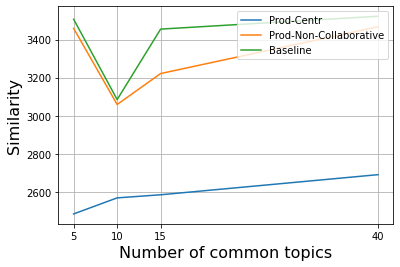

In [21]:
plt.plot(frozen_topics_list, sim_thetas_centralized, label="Prod-Centr")
plt.plot(frozen_topics_list, sim_thetas_non_colab, label="Prod-Non-Collaborative")
plt.plot(frozen_topics_list, sim_thetas_baseline, label="Baseline")
plt.legend(loc="upper right")

plt.xlabel('Number of common topics', fontsize=16)
plt.ylabel('Similarity', fontsize=16)
plt.xticks(frozen_topics_list, [5,10,15,40])
plt.grid()
plt.show()